# Setup

In [0]:
# connecting google drive with google colab
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import gc
import time
import numpy as np
import pandas as pd
from contextlib import contextmanager
import multiprocessing as mp
from functools import partial
from scipy.stats import kurtosis, iqr, skew

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score

# Suppress warnings 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [0]:
""" FEATURE ENGINEERING FUNCTIONS"""        
def do_mean(df, group_cols, counted, agg_name):
  gp = df[group_cols + [counted]].groupby(group_cols)[counted].mean().reset_index().rename(
      columns={counted: agg_name})
  df = df.merge(gp, on=group_cols, how='left')
  del gp
  gc.collect()
  return df

def do_median(df, group_cols, counted, agg_name):
  gp = df[group_cols + [counted]].groupby(group_cols)[counted].median().reset_index().rename(
      columns={counted: agg_name})
  df = df.merge(gp, on=group_cols, how='left')
  del gp
  gc.collect()
  return df

def do_std(df, group_cols, counted, agg_name):
  gp = df[group_cols + [counted]].groupby(group_cols)[counted].std().reset_index().rename(
      columns={counted: agg_name})
  df = df.merge(gp, on=group_cols, how='left')
  del gp
  gc.collect()
  return df

def do_sum(df, group_cols, counted, agg_name):
  gp = df[group_cols + [counted]].groupby(group_cols)[counted].sum().reset_index().rename(
      columns={counted: agg_name})
  df = df.merge(gp, on=group_cols, how='left')
  del gp
  gc.collect()
  return df
  
def label_encoder(df, categorical_columns=None):
  """Encode categorical values as integers (0,1,2,3...) with pandas.factorize. """
  if not categorical_columns:
      categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
  for col in categorical_columns:
      df[col], uniques = pd.factorize(df[col])
  return df, categorical_columns


def one_hot_encoder(df, categorical_columns=None, nan_as_category=True):
  """Create a new column for each categorical value in categorical columns. """
  original_columns = list(df.columns)
  if not categorical_columns:# if not auto "ohe" object-type features
      categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
  df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
  categorical_columns = [c for c in df.columns if c not in original_columns]
  return df, categorical_columns

def group(df_to_agg, prefix, aggregations, aggregate_by= 'SK_ID_CURR'):
  """Grouping by SK_ID_CURR with formated aggregations """
  agg_df = df_to_agg.groupby(aggregate_by).agg(aggregations)
  # change columns names
  agg_df.columns = pd.Index(['{}{}_{}'.format(prefix, e[0], e[1].upper())
                             for e in agg_df.columns.tolist()])
  return agg_df.reset_index()

def group_and_merge(df_to_agg, df_to_merge, prefix, aggregations, aggregate_by= 'SK_ID_CURR'):
  agg_df = group(df_to_agg, prefix, aggregations, aggregate_by= aggregate_by)
  return df_to_merge.merge(agg_df, how='left', on= aggregate_by)
  


#1st-FE
only application (train & test ) table:
- model have generated new features


In [0]:
def get_age_label(days_birth):
    """ Return the age group label (int). """
    age_years = -days_birth / 365
    if age_years < 27: return 1
    elif age_years < 40: return 2
    elif age_years < 50: return 3
    elif age_years < 65: return 4
    elif age_years < 99: return 5
    else: return 0

def get_apply_train_test(path, num_rows = None):
    """ Process application_train.csv and application_test.csv and return a pandas dataframe. """
    train = pd.read_csv(os.path.join(path, 'application_train.csv'), nrows= num_rows)
    test = pd.read_csv(os.path.join(path, 'application_test.csv'), nrows= num_rows)    
    df = train.append(test)
    del train, test; gc.collect()
    
    # Data cleaning
    df = df[df['CODE_GENDER'] != 'XNA']  # 4 people with XNA code gender
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    df['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)
    df['DAYS_ID_PUBLISH'].replace(0, np.nan, inplace=True)
    df['DAYS_REGISTRATION'].replace(0, np.nan, inplace=True)

    df = df[df['AMT_INCOME_TOTAL'] < 20000000]  # Max income in test is 4M; train has a 117M value
    
    # Categorical age - based on target=1 plot
    df['AGE_RANGE'] = df['DAYS_BIRTH'].apply(lambda x: get_age_label(x))    
    
    # Flag_document features - count and kurtosis
    docs = [f for f in df.columns if 'FLAG_DOC' in f]
    df['DOCUMENT_COUNT'] = df[docs].sum(axis=1)
    df['NEW_DOC_KURT'] = df[docs].kurtosis(axis=1)
    
    # New features based on External sources
    df['EXT_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['EXT_SOURCES_WEIGHTED'] = df.EXT_SOURCE_1 * 2 + df.EXT_SOURCE_2 * 1 + df.EXT_SOURCE_3 * 3
    np.warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')
    for function_name in ['min', 'max', 'mean', 'nanmedian', 'var']:
        feature_name = 'EXT_SOURCES_{}'.format(function_name.upper())
        df[feature_name] = eval('np.{}'.format(function_name))(
            df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)

    # Credit ratios
    df['CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    df['CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    
    # Income ratios
    df['ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    df['INCOME_TO_EMPLOYED_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_EMPLOYED']
    df['INCOME_TO_BIRTH_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_BIRTH']
    
    # Time ratios
    df['EMPLOYED_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['ID_TO_BIRTH_RATIO'] = df['DAYS_ID_PUBLISH'] / df['DAYS_BIRTH']
    df['CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
    df['CAR_TO_EMPLOYED_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
    df['PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']

    # Groupby: Statistics for applications in the same group
    group = ['ORGANIZATION_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 
             'AGE_RANGE', 'CODE_GENDER']
    df = do_median(df, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_MEDIAN')
    df = do_std(df, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_STD')
    df = do_mean(df, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_MEAN')
    df = do_std(df, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_STD')
    df = do_mean(df, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_MEAN')
    df = do_std(df, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_STD')
    df = do_mean(df, group, 'AMT_CREDIT', 'GROUP_CREDIT_MEAN')
    df = do_mean(df, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_MEAN')
    df = do_std(df, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_STD')

    # Encode categorical features (LabelEncoder)
    df, le_encoded_cols = label_encoder(df, None)
    
    # Dropping less information features
    df = drop_application_columns(df)
    return df

def drop_application_columns(df):
    """ Drop features based on permutation feature importance. """
    drop_list = [
        # categorical features        
        'FLAG_EMP_PHONE', 'FLAG_MOBIL', 'FLAG_CONT_MOBILE', 'FLAG_EMAIL', 'FLAG_PHONE',
        'FLAG_OWN_REALTY',
        
        # continous
        'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 
        'HOUR_APPR_PROCESS_START',
        
         
        'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_WORK_CITY',
        'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
        'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_YEAR',
        
        'FONDKAPREMONT_MODE','HOUSETYPE_MODE', 'EMERGENCYSTATE_MODE',
        'COMMONAREA_MODE', 'NONLIVINGAREA_MODE', 'LIVINGAPARTMENTS_MODE',
        'ELEVATORS_MODE','LANDAREA_MODE','FLOORSMIN_MODE', 
        'BASEMENTAREA_MODE','NONLIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
        'YEARS_BEGINEXPLUATATION_MODE','ENTRANCES_MODE','YEARS_BUILD_MODE',
        
        'FLOORSMIN_MEDI',  'NONLIVINGAREA_MEDI',  'NONLIVINGAPARTMENTS_MEDI', 
        'BASEMENTAREA_MEDI', 'COMMONAREA_MEDI',  'LIVINGAPARTMENTS_MEDI',
        'ELEVATORS_MEDI', 'LIVINGAREA_MEDI', 'YEARS_BUILD_MEDI','LANDAREA_MEDI',
        
        'NONLIVINGAREA_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',         
        'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'BASEMENTAREA_AVG',        
        'LIVINGAPARTMENTS_AVG', 'ELEVATORS_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 
        'NONLIVINGAPARTMENTS_AVG'
    ]
    # Drop most flag document columns
    for doc_num in [2,4,5,6,7,9,10,11,12,13,14,15,16,17,19,20,21]:
        drop_list.append('FLAG_DOCUMENT_{}'.format(doc_num))
    df.drop(drop_list, axis=1, inplace=True)
    return df



      

In [0]:
DATA_DIRECTORY = "drive/My Drive/Kaggle/home credit/data/"
#num_rows = 30000 if debug else None
debug = False #True
num_rows = 30000 if debug else None

if __name__ == "__main__":
  with timer("application_train and application_test"):
    df = get_apply_train_test(DATA_DIRECTORY, num_rows= num_rows)
    print("Application dataframe shape: ", df.shape)
    

Application dataframe shape:  (356250, 83)
application_train and application_test - done in 38s


# 2nd-FE
build DF uses all table, but don't have new features.

In [0]:
# Application table
def get_age_label(days_birth):
  """ Return the age group label (int). """
  age_years = -days_birth / 365
  if age_years < 27: return 1
  elif age_years < 40: return 2
  elif age_years < 50: return 3
  elif age_years < 65: return 4
  elif age_years < 99: return 5
  else: return 0

def get_apply_train_test_2(path, num_rows = None):
  """ Process application_train.csv and application_test.csv and return a pandas dataframe. """
  train = pd.read_csv(os.path.join(path, 'application_train.csv'), nrows= num_rows)
  test = pd.read_csv(os.path.join(path, 'application_test.csv'), nrows= num_rows)    
  df = train.append(test)
  del train, test; gc.collect()

  # Data cleaning
  df = df[df['CODE_GENDER'] != 'XNA']  # 4 people with XNA code gender
  df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
  df['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)
  df['DAYS_ID_PUBLISH'].replace(0, np.nan, inplace=True)
  df['DAYS_REGISTRATION'].replace(0, np.nan, inplace=True)

  df = df[df['AMT_INCOME_TOTAL'] < 20000000]  # Max income in test is 4M; train has a 117M value

  # Categorical age - based on target=1 plot
  df['AGE_RANGE'] = df['DAYS_BIRTH'].apply(lambda x: get_age_label(x)) 

  # Encode categorical features (LabelEncoder)
  df, le_encoded_cols = label_encoder(df, None)
  return df
  
# Previous application
def get_previous_applications_2(path, num_rows= None):
  """ Process previous_application.csv and return a pandas dataframe. """
  prev = pd.read_csv(os.path.join(path, 'previous_application.csv'), nrows= num_rows)

  # One-hot encode most important categorical features -> 85 cols
  ohe_columns = [
      'NAME_CONTRACT_STATUS', 'NAME_CONTRACT_TYPE', 'CHANNEL_TYPE',
      'NAME_TYPE_SUITE', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
      'NAME_PRODUCT_TYPE', 'NAME_CLIENT_TYPE', 'NAME_PORTFOLIO',
         'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_INSURED_ON_APPROVAL']
  prev, categorical_cols = one_hot_encoder(prev, ohe_columns, nan_as_category= False)


  # Change 365.243 values to nan (missing) 
  prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
  prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
  prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
  prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
  prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)

  # Grouping by SK_ID_PREV
  # Categorical features
  categorical_agg = {key: ['mean'] for key in categorical_cols}
  # Perform general aggregations
  PREVIOUS_AGG = {
  'SK_ID_PREV': ['nunique'],
  'AMT_ANNUITY': ['min', 'max', 'mean'],
  'AMT_APPLICATION': ['min', 'max', 'mean'],
  'AMT_CREDIT': ['min', 'max', 'mean'],
  'AMT_DOWN_PAYMENT': ['max', 'mean'],
  'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
  'RATE_DOWN_PAYMENT': ['max', 'mean'],
  'RATE_INTEREST_PRIMARY': ['max', 'mean'],
  'RATE_INTEREST_PRIVILEGED': ['max', 'mean'],
  'DAYS_DECISION': ['min', 'max', 'mean'],
  'DAYS_LAST_DUE_1ST_VERSION': ['max'],
  'DAYS_LAST_DUE': ['max'],       
  'CNT_PAYMENT': ['max', 'mean'],
  'DAYS_TERMINATION': ['max'],}    
  agg_prev = group(prev, 'PREV_', {**PREVIOUS_AGG, **categorical_agg})
  return agg_prev
  
def get_installment_payments_2(path, num_rows= None):  
  """ Process installments_payments.csv and return a pandas dataframe. """
  pay = pd.read_csv(os.path.join(path, 'installments_payments.csv'), nrows= num_rows)

  INSTALLMENTS_AGG = {
  'SK_ID_PREV': ['size', 'nunique'],
  'DAYS_ENTRY_PAYMENT': ['min', 'max', 'mean'],     
  'DAYS_ENTRY_PAYMENT': ['min', 'max', 'mean'], 
  'AMT_INSTALMENT': ['min', 'max', 'mean', 'sum'],
  'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],}    
  pay_agg = group(pay, 'INS_', INSTALLMENTS_AGG)
  return pay_agg

def get_credit_card_2(path, num_rows= None):
  """ Process credit_card_balance.csv and return a pandas dataframe. """
  cc = pd.read_csv(os.path.join(path, 'credit_card_balance.csv'), nrows= num_rows)
  ohe_columns = [col for col in cc.columns if cc[col].dtype == 'object']
  cc, cat_cols = one_hot_encoder(cc,ohe_columns, nan_as_category=False)
  
  # Aggregations by SK_ID_CURR
  # Categorical features
  cat_agg = {key: ['mean'] for key in cat_cols}  
  CREDIT_CARD_AGG = {      
      'MONTHS_BALANCE': ['min'],
      'AMT_BALANCE': ['max'],
      'AMT_CREDIT_LIMIT_ACTUAL': ['max'],
      'AMT_DRAWINGS_OTHER_CURRENT': ['max', 'sum'],      
      'AMT_DRAWINGS_ATM_CURRENT': ['max', 'sum'],
      'AMT_DRAWINGS_CURRENT': ['max', 'sum'],
      'AMT_DRAWINGS_POS_CURRENT': ['max', 'sum'],      
      'AMT_INST_MIN_REGULARITY': ['max', 'mean'],
      'AMT_PAYMENT_TOTAL_CURRENT': ['max', 'mean', 'sum', 'var'],
      'AMT_TOTAL_RECEIVABLE': ['max', 'mean'],      
      'AMT_PAYMENT_CURRENT': ['max', 'sum'],      
      'CNT_DRAWINGS_ATM_CURRENT': ['max', 'mean', 'sum'],
      'CNT_DRAWINGS_CURRENT': ['max', 'mean', 'sum'],
      'CNT_DRAWINGS_POS_CURRENT': ['mean'],
      'CNT_DRAWINGS_OTHER_CURRENT': ['max', 'mean', 'sum'],  
      'SK_DPD': ['mean', 'max', 'sum'],
      'SK_DPD_DEF': ['max', 'sum'],}
  
  cc_agg = group(cc, 'CC_', {**CREDIT_CARD_AGG, **cat_agg})
  return cc_agg

def get_pos_cash_2(path, num_rows= None):
  """ Process POS_CASH_balance.csv and return a pandas dataframe. """
  pos = pd.read_csv(os.path.join(path, 'POS_CASH_balance.csv'), nrows= num_rows)
  pos, categorical_cols = one_hot_encoder(pos, nan_as_category= False)
  POS_CASH_AGG = {      
      'SK_ID_PREV': ['nunique'],
      'CNT_INSTALMENT':['max', 'mean', 'sum'],
      'CNT_INSTALMENT_FUTURE':['max', 'mean', 'sum'],
      'MONTHS_BALANCE': ['min', 'max', 'size'],
      'SK_DPD': ['max', 'mean', 'sum', 'var'],
      'SK_DPD_DEF': ['max', 'mean', 'sum'],}

  # Aggregate by SK_ID_CURR
  categorical_agg = {key: ['mean'] for key in categorical_cols}
  pos_agg = group(pos, 'POS_', {**POS_CASH_AGG, **categorical_agg})
  return pos_agg

def get_bureau_balance_2(path, num_rows= None):  
  bb = pd.read_csv(os.path.join(path, 'bureau_balance.csv'), nrows= num_rows)
  bb, categorical_cols = one_hot_encoder(bb, nan_as_category= False)
  
  # Calculate rate for each category with decay
  bb_processed = bb.groupby('SK_ID_BUREAU')[categorical_cols].mean().reset_index()
  # Min, Max, Count and mean duration of payments (months)
  agg = {'MONTHS_BALANCE': ['min', 'max', 'mean', 'size']}
  bb_processed = group_and_merge(bb, bb_processed, '', agg, 'SK_ID_BUREAU')
  del bb; gc.collect()
  return bb_processed

def get_bureau_2(path, num_rows= None):
    """ Process bureau.csv and bureau_balance.csv and return a pandas dataframe. """
    bureau = pd.read_csv(os.path.join(path, 'bureau.csv'), nrows= num_rows)
    # One-hot encoder
    bureau, categorical_cols = one_hot_encoder(bureau, nan_as_category= False)
    # Join bureau balance features
    bureau = bureau.merge(get_bureau_balance_2(path, num_rows), how='left', on='SK_ID_BUREAU')
    
    BUREAU_AGG = {
    'SK_ID_BUREAU': ['nunique'],
    'DAYS_CREDIT': ['min', 'max', 'mean'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
    'AMT_ANNUITY': ['mean'],
    'MONTHS_BALANCE_MEAN': ['mean', 'var'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum'],}
    
    # General loans aggregations
    agg_bureau = group(bureau, 'BUREAU_', BUREAU_AGG)    
    return agg_bureau

In [0]:
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(name, time.time() - t0))

DATA_DIRECTORY = "drive/My Drive/Kaggle/home credit/data/"
#num_rows = 30000 if debug else None
debug = False #True
num_rows = 30000 if debug else None

if __name__ == "__main__":
  with timer("application_train and application_test"):
    df = get_apply_train_test_2(DATA_DIRECTORY, num_rows= num_rows)
    print("Application dataframe shape: ", df.shape)
  with timer("previous_application"):
    prev_df = get_previous_applications_2(DATA_DIRECTORY, num_rows)
    df = pd.merge(df, prev_df, on='SK_ID_CURR', how='left')
    print("Previous dataframe shape: ", prev_df.shape)
    print("Final dataframe shape: ", df.shape)
    del prev_df; gc.collect()
  with timer("Installments dataframe"):
    ins = get_installment_payments_2(DATA_DIRECTORY, num_rows)
    df = pd.merge(df, ins, on='SK_ID_CURR', how='left')
    print("Installments dataframe shape: ", ins.shape)
    print("Final dataframe shape: ", df.shape)
    del ins; gc.collect()
  with timer("Credit card dataframe"):
    cc = get_credit_card_2(DATA_DIRECTORY, num_rows)
    df = pd.merge(df, cc, on='SK_ID_CURR', how='left')
    print("CC shape: ", cc.shape)
    print("Final dataframe shape: ", df.shape)
    del cc; gc.collect()
  with timer("POS CASH dataframe"):
    pos = get_pos_cash_2(DATA_DIRECTORY, num_rows)
    df = pd.merge(df, pos, on='SK_ID_CURR', how='left')
    print("POS CASH shape: ", pos.shape)
    print("Final dataframe shape: ", df.shape)
    del pos; gc.collect()
  with timer("bureau dataframe"):
    bureau = get_bureau_2(DATA_DIRECTORY, num_rows)
    df = pd.merge(df, bureau, on='SK_ID_CURR', how='left')
    print("bureau shape: ", bureau.shape)
    print("Final dataframe shape: ", df.shape)
    del bureau; gc.collect()

    

Application dataframe shape:  (356250, 123)
application_train and application_test - done in 9s
Previous dataframe shape:  (338857, 91)
Final dataframe shape:  (356250, 213)
previous_application - done in 20s
Installments dataframe shape:  (339587, 14)
Final dataframe shape:  (356250, 226)
Installments dataframe - done in 43s
CC shape:  (103558, 44)
Final dataframe shape:  (356250, 269)
Credit card dataframe - done in 17s
POS CASH shape:  (337252, 27)
Final dataframe shape:  (356250, 295)
POS CASH dataframe - done in 38s
bureau shape:  (305811, 23)
Final dataframe shape:  (356250, 317)
bureau dataframe - done in 39s


# 4th-FE

In [0]:
def get_age_label(days_birth):
    """ Return the age group label (int). """
    age_years = -days_birth / 365
    if age_years < 27: return 1
    elif age_years < 40: return 2
    elif age_years < 50: return 3
    elif age_years < 65: return 4
    elif age_years < 99: return 5
    else: return 0

def get_apply_train_test_4(path, num_rows = None):
    """ Process application_train.csv and application_test.csv and return a pandas dataframe. """
    train = pd.read_csv(os.path.join(path, 'application_train.csv'), nrows= num_rows)
    test = pd.read_csv(os.path.join(path, 'application_test.csv'), nrows= num_rows)    
    df = train.append(test)
    del train, test; gc.collect()
    
    # Data cleaning
    df = df[df['CODE_GENDER'] != 'XNA']  # 4 people with XNA code gender
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    df['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)
    df['DAYS_ID_PUBLISH'].replace(0, np.nan, inplace=True)
    df['DAYS_REGISTRATION'].replace(0, np.nan, inplace=True)

    df = df[df['AMT_INCOME_TOTAL'] < 20000000]  # Max income in test is 4M; train has a 117M value
    
    # Categorical age - based on target=1 plot
    df['AGE_RANGE'] = df['DAYS_BIRTH'].apply(lambda x: get_age_label(x))    
    
    # Flag_document features - count and kurtosis
    docs = [f for f in df.columns if 'FLAG_DOC' in f]
    df['DOCUMENT_COUNT'] = df[docs].sum(axis=1)
    df['NEW_DOC_KURT'] = df[docs].kurtosis(axis=1)
    
    # New features based on External sources
    df['EXT_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['EXT_SOURCES_WEIGHTED'] = df.EXT_SOURCE_1 * 2 + df.EXT_SOURCE_2 * 1 + df.EXT_SOURCE_3 * 3
    np.warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')
    for function_name in ['min', 'max', 'mean', 'nanmedian', 'var']:
        feature_name = 'EXT_SOURCES_{}'.format(function_name.upper())
        df[feature_name] = eval('np.{}'.format(function_name))(
            df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)

    # Credit ratios
    df['CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    df['CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    
    # Income ratios
    df['ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    df['INCOME_TO_EMPLOYED_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_EMPLOYED']
    df['INCOME_TO_BIRTH_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_BIRTH']
    
    # Time ratios
    df['EMPLOYED_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['ID_TO_BIRTH_RATIO'] = df['DAYS_ID_PUBLISH'] / df['DAYS_BIRTH']
    df['CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
    df['CAR_TO_EMPLOYED_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
    df['PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']

    # Groupby: Statistics for applications in the same group
    group = ['ORGANIZATION_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 
             'AGE_RANGE', 'CODE_GENDER']
    df = do_median(df, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_MEDIAN')
    df = do_std(df, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_STD')
    df = do_mean(df, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_MEAN')
    df = do_std(df, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_STD')
    df = do_mean(df, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_MEAN')
    df = do_std(df, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_STD')
    df = do_mean(df, group, 'AMT_CREDIT', 'GROUP_CREDIT_MEAN')
    df = do_mean(df, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_MEAN')
    df = do_std(df, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_STD')

    # Encode categorical features (LabelEncoder)
    df, le_encoded_cols = label_encoder(df, None)
    
    # Dropping less information features
    df = drop_application_columns(df)
    return df

def drop_application_columns(df):
    """ Drop features based on permutation feature importance. """
    drop_list = [
        # categorical features        
        'FLAG_EMP_PHONE', 'FLAG_MOBIL', 'FLAG_CONT_MOBILE', 'FLAG_EMAIL', 'FLAG_PHONE',
        'FLAG_OWN_REALTY',
        
        # continous
        'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 
        'HOUR_APPR_PROCESS_START',
        
         
        'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_WORK_CITY',
        'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
        'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_YEAR',
        
        'FONDKAPREMONT_MODE','HOUSETYPE_MODE', 'EMERGENCYSTATE_MODE',
        'COMMONAREA_MODE', 'NONLIVINGAREA_MODE', 'LIVINGAPARTMENTS_MODE',
        'ELEVATORS_MODE','LANDAREA_MODE','FLOORSMIN_MODE', 
        'BASEMENTAREA_MODE','NONLIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
        'YEARS_BEGINEXPLUATATION_MODE','ENTRANCES_MODE','YEARS_BUILD_MODE',
        
        'FLOORSMIN_MEDI',  'NONLIVINGAREA_MEDI',  'NONLIVINGAPARTMENTS_MEDI', 
        'BASEMENTAREA_MEDI', 'COMMONAREA_MEDI',  'LIVINGAPARTMENTS_MEDI',
        'ELEVATORS_MEDI', 'LIVINGAREA_MEDI', 'YEARS_BUILD_MEDI','LANDAREA_MEDI',
        
        'NONLIVINGAREA_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',         
        'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'BASEMENTAREA_AVG',        
        'LIVINGAPARTMENTS_AVG', 'ELEVATORS_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 
        'NONLIVINGAPARTMENTS_AVG'
    ]
    # Drop most flag document columns
    for doc_num in [2,4,5,6,7,9,10,11,12,13,14,15,16,17,19,20,21]:
        drop_list.append('FLAG_DOCUMENT_{}'.format(doc_num))
    df.drop(drop_list, axis=1, inplace=True)
    return df      

In [0]:
def get_bureau_balance_4(path, num_rows= None):  
  bb = pd.read_csv(os.path.join(path, 'bureau_balance.csv'), nrows= num_rows)
  # One-hot encoder  
  bb, categorical_cols = one_hot_encoder(bb, nan_as_category= False)  
  # Calculate rate for each category with decay
  bb_processed = bb.groupby('SK_ID_BUREAU')[categorical_cols].mean().reset_index()
  # Min, Max, Count and mean duration of payments (months)
  agg = {'MONTHS_BALANCE': ['min', 'max', 'mean', 'size']}
  bb_processed = group_and_merge(bb, bb_processed, '', agg, 'SK_ID_BUREAU')
  # Flag months with late payments (days past due)
  bb_processed['STATUS_12345'] = 0
  for i in range(1,6):
    bb_processed['STATUS_12345'] += bb_processed['STATUS_{}'.format(i)]      
  del bb; gc.collect()
  return bb_processed

def get_bureau_4(path, num_rows= None):
  """ Process bureau.csv and bureau_balance.csv and return a pandas dataframe. """
  bureau = pd.read_csv(os.path.join(path, 'bureau.csv'), nrows= num_rows)

  # DOMAIN KNOWLEDGE FEATURES
  # Credit duration and credit/account end date difference
  bureau['CREDIT_DURATION'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_CREDIT']
  bureau['ENDDATE_DIF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
  # Credit to debt ratio and difference
  bureau['CREDIT_DEBT_RATIO'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_CREDIT_SUM_DEBT']
  bureau['DEBT_CREDIT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']

  bureau['DEBT_TO_LIMIT_RATIO'] = bureau['AMT_CREDIT_SUM_DEBT'] / bureau['AMT_CREDIT_SUM_LIMIT']
  bureau['CREDIT_LIMIT_RATIO'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_CREDIT_SUM_LIMIT']

  bureau['CREDIT_TO_ANNUITY_RATIO'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_ANNUITY']
  bureau['LIMIT_TO_ANNUITY_RATIO'] = bureau['AMT_CREDIT_SUM_LIMIT'] / bureau['AMT_ANNUITY']


  # One-hot encoder
  #ohe_columns = ['CREDIT_ACTIVE']
  bureau, categorical_cols = one_hot_encoder(bureau, nan_as_category= False)

  # Join bureau balance features
  bb = get_bureau_balance_4(path, num_rows)
  categorical_cols = categorical_cols + ['STATUS_C','STATUS_0','STATUS_X','STATUS_12345']
#   + [f for f in bb.columns if 'STATUS_' in f]
  bureau = bureau.merge(bb, how='left', on='SK_ID_BUREAU')

  BUREAU_AGG = {                
      'SK_ID_BUREAU': ['nunique'],
      'DAYS_CREDIT': ['min', 'max', 'mean'],
      'DAYS_CREDIT_ENDDATE': ['min', 'max'],
      'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
      'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
      'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
      'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
      'AMT_ANNUITY': ['mean', 'sum'],
      'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
      'MONTHS_BALANCE_MEAN': ['mean', 'var'],
      'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
      # new features
      'CREDIT_DURATION': ['min', 'max'],
      'ENDDATE_DIF': ['min', 'max'],
      'CREDIT_DEBT_RATIO': ['mean'],
      'DEBT_CREDIT_DIFF': ['max', 'mean', 'sum'],
      'DEBT_TO_LIMIT_RATIO': ['mean'],
      'CREDIT_LIMIT_RATIO': ['mean'],
      'CREDIT_TO_ANNUITY_RATIO': ['mean'],
      'LIMIT_TO_ANNUITY_RATIO': ['mean'], }

  # Aggregate by SK_ID_CURR
  categorical_agg = {key: ['mean'] for key in categorical_cols}
  # General loans aggregations
  agg_bureau = group(bureau, 'BUREAU_',  {**BUREAU_AGG, **categorical_agg}) 

  # Time based aggregations: last x months
  for time_frame in [12, 24, 48]:
    prefix = "BUREAU_LAST{}M_".format(time_frame)
    time_frame_df = bureau[bureau['DAYS_CREDIT'] >= -30*time_frame]
    BUREAU_TIME_AGG = {
        'AMT_CREDIT_SUM': ['mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean', 'sum'], 
        'CREDIT_DEBT_RATIO': ['mean'], 
        'DEBT_CREDIT_DIFF': ['mean'],
        'DEBT_TO_LIMIT_RATIO': ['mean'], 
        'DAYS_CREDIT': ['min', 'max', 'mean'],
        'DAYS_CREDIT_ENDDATE': ['max'],}      
    agg_bureau = group_and_merge(time_frame_df, agg_bureau, prefix, BUREAU_TIME_AGG)
    del time_frame_df; gc.collect()

  """ CATEGORIES """
  # Active and closed loans aggregations
  active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
  BUREAU_ACTIVE_AGG = {        
      'DAYS_CREDIT': ['max', 'mean'],
      'DAYS_CREDIT_ENDDATE': ['max'],
      'DAYS_CREDIT_UPDATE': ['max'],
      'ENDDATE_DIF': ['mean'], 
      'CREDIT_DEBT_RATIO': ['mean'],        
      'DEBT_CREDIT_DIFF': ['mean'],
      'DEBT_TO_LIMIT_RATIO': ['mean'],  
      'AMT_CREDIT_SUM': ['mean', 'sum'],
      'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
      'AMT_CREDIT_SUM_OVERDUE': ['mean', 'sum'],    }
  agg_bureau = group_and_merge(active,agg_bureau,'BUREAU_ACTIVE_',BUREAU_ACTIVE_AGG)
  closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
  BUREAU_CLOSED_AGG = {
      'DAYS_CREDIT': ['max', 'mean'],
      'DAYS_CREDIT_ENDDATE': ['max'],
      'DAYS_CREDIT_UPDATE': ['max'],
      'ENDDATE_DIF': ['mean'], 
      'CREDIT_DEBT_RATIO': ['mean'],        
      'DEBT_CREDIT_DIFF': ['mean'],
      'DEBT_TO_LIMIT_RATIO': ['mean'],  
      'AMT_CREDIT_SUM': ['mean', 'sum'],
      'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
      'AMT_CREDIT_SUM_OVERDUE': ['mean', 'sum'],    }
  agg_bureau = group_and_merge(closed,agg_bureau,'BUREAU_CLOSED_',BUREAU_CLOSED_AGG)
  del active, closed; gc.collect()

  # Aggregations for the main loan types
  for credit_type in ['Consumer credit', 'Credit card']: #, 'Mortgage', 'Car loan', 'Microloan']:
    type_df = bureau[bureau['CREDIT_TYPE_' + credit_type] == 1]
    prefix = 'BUREAU_' + credit_type.split(' ')[0].upper() + '_'        
    BUREAU_LOAN_TYPE_AGG = {
      'DAYS_CREDIT': ['max', 'mean'],
      'DAYS_CREDIT_ENDDATE': ['max'],
      'DAYS_CREDIT_UPDATE': ['max'],
      'ENDDATE_DIF': ['mean'], 
      'CREDIT_DEBT_RATIO': ['mean'],        
      'DEBT_CREDIT_DIFF': ['mean'],
      'DEBT_TO_LIMIT_RATIO': ['mean'],  
      'AMT_CREDIT_SUM': ['mean', 'sum'],
      'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
      'AMT_CREDIT_SUM_OVERDUE': ['mean', 'sum'],    }
    agg_bureau = group_and_merge(type_df, agg_bureau, prefix, BUREAU_LOAN_TYPE_AGG)
    del type_df; gc.collect()

  # Last loan max overdue
  sort_bureau = bureau.sort_values(by=['DAYS_CREDIT'])
  gr = sort_bureau.groupby('SK_ID_CURR')['AMT_CREDIT_MAX_OVERDUE'].last().reset_index()
  gr.rename({'AMT_CREDIT_MAX_OVERDUE': 'BUREAU_LAST_LOAN_MAX_OVERDUE'}, inplace=True)
  agg_bureau = agg_bureau.merge(gr, on='SK_ID_CURR', how='left')

  # Ratios: total debt/total credit and active loans debt/ active loans credit
  agg_bureau['BUREAU_DEBT_OVER_CREDIT'] = (agg_bureau['BUREAU_AMT_CREDIT_SUM_DEBT_SUM']/
                                           agg_bureau['BUREAU_AMT_CREDIT_SUM_SUM'])
  agg_bureau['BUREAU_ACTIVE_DEBT_OVER_CREDIT'] = (agg_bureau['BUREAU_ACTIVE_AMT_CREDIT_SUM_DEBT_SUM']/
                                                  agg_bureau['BUREAU_ACTIVE_AMT_CREDIT_SUM_SUM'])
  
  agg_bureau = drop_bureau_cols(agg_bureau)  
  return agg_bureau

def drop_bureau_cols(df):
    """ Drop features based on permutation feature importance. """
    drop_list = ['BUREAU_CREDIT_ACTIVE_Bad debt_MEAN',
       'BUREAU_CREDIT_CURRENCY_currency 1_MEAN',
       'BUREAU_CREDIT_CURRENCY_currency 2_MEAN',
       'BUREAU_CREDIT_CURRENCY_currency 3_MEAN',
       'BUREAU_CREDIT_CURRENCY_currency 4_MEAN',
       'BUREAU_CREDIT_TYPE_Another type of loan_MEAN',
       'BUREAU_CREDIT_TYPE_Cash loan (non-earmarked)_MEAN',
       'BUREAU_CREDIT_TYPE_Interbank credit_MEAN',
       'BUREAU_CREDIT_TYPE_Loan for business development_MEAN',
       'BUREAU_CREDIT_TYPE_Loan for purchase of shares (margin lending)_MEAN',
       'BUREAU_CREDIT_TYPE_Loan for the purchase of equipment_MEAN',
       'BUREAU_CREDIT_TYPE_Loan for working capital replenishment_MEAN',
       'BUREAU_CREDIT_TYPE_Mobile operator loan_MEAN',
       'BUREAU_CREDIT_TYPE_Real estate loan_MEAN',
       'BUREAU_CREDIT_TYPE_Unknown type of loan_MEAN',
       'BUREAU_ACTIVE_ENDDATE_DIF_MEAN',
       'BUREAU_CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN',
       'BUREAU_CLOSED_AMT_CREDIT_SUM_OVERDUE_SUM',
       'BUREAU_CONSUMER_DEBT_TO_LIMIT_RATIO_MEAN',]
    df.drop(drop_list, axis=1, inplace=True)
    return df

In [0]:
"""
PREVIOUS APPLICATION
"""
def get_previous_applications_4(path, num_rows= None):
  """ Process previous_application.csv and return a pandas dataframe. """
  prev = pd.read_csv(os.path.join(path, 'previous_application.csv'), nrows= num_rows)
  pay = pd.read_csv(os.path.join(path, 'installments_payments.csv'), nrows= num_rows)

  # One-hot encode most important categorical features -> 85 cols
  ohe_columns = [
      'NAME_CONTRACT_STATUS', 'NAME_CONTRACT_TYPE', 'CHANNEL_TYPE',
      'NAME_TYPE_SUITE', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
      'NAME_PRODUCT_TYPE', 'NAME_CLIENT_TYPE', 'NAME_PORTFOLIO',
         'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_INSURED_ON_APPROVAL']
  prev, cat_cols = one_hot_encoder(prev, ohe_columns, nan_as_category= False)

  # Feature engineering: ratios and difference
  prev['APPLICATION_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
  prev['APPLICATION_CREDIT_RATIO'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
  prev['CREDIT_TO_ANNUITY_RATIO'] = prev['AMT_CREDIT'] / prev['AMT_ANNUITY']
  prev['DOWN_PAYMENT_TO_CREDIT'] = prev['AMT_DOWN_PAYMENT'] / prev['AMT_CREDIT']
  prev['DOWN_PAYMENT_TO_ANNUITY'] = prev['AMT_DOWN_PAYMENT'] / prev['AMT_ANNUITY']

  # Interest ratio on previous application (simplified)
  prev['TOTAL_PAYMENT'] = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
  prev['SIMPLE_INTERESTS'] = (prev['TOTAL_PAYMENT']/prev['AMT_CREDIT'] - 1)/prev['CNT_PAYMENT']

  """
  Connecting with install_payment.csv to take all informations 
  related to previous PAYMENT of clients who had approved loans and not complete yet"""
  # Active loans - approved and not complete yet (last_due 365243)
  approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
  active_df = approved[approved['DAYS_LAST_DUE'] == 365243]
  # Find how much was already payed in active loans (using installments csv)
  active_pay = pay[pay['SK_ID_PREV'].isin(active_df['SK_ID_PREV'])]
  active_pay_agg = active_pay.groupby('SK_ID_PREV')[['AMT_INSTALMENT', 'AMT_PAYMENT']].sum()
  active_pay_agg.reset_index(inplace= True)    
  # Active loans: difference of what was payed and installments
  active_pay_agg['INSTALMENT_PAYMENT_DIFF'] = active_pay_agg['AMT_INSTALMENT'] - active_pay_agg['AMT_PAYMENT']
  # Merge with active_df
  active_df = active_df.merge(active_pay_agg, on= 'SK_ID_PREV', how= 'left')
  active_df['REMAINING_DEBT'] = active_df['AMT_CREDIT'] - active_df['AMT_PAYMENT']
  active_df['REPAYMENT_RATIO'] = active_df['AMT_PAYMENT'] / active_df['AMT_CREDIT']
  # Perform aggregations for active applications
  PREVIOUS_ACTIVE_AGG = {
      'SK_ID_PREV': ['nunique'],
      'SIMPLE_INTERESTS': ['mean'],
      'AMT_ANNUITY': ['max', 'sum'],
      'AMT_APPLICATION': ['max', 'mean'],
      'AMT_CREDIT': ['sum'],
      'AMT_DOWN_PAYMENT': ['max', 'mean'],
      'DAYS_DECISION': ['min', 'mean'],
      'CNT_PAYMENT': ['mean', 'sum'],
      'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
      # Engineered features
      'AMT_PAYMENT': ['sum'],
      'INSTALMENT_PAYMENT_DIFF': ['mean', 'max'],
      'REMAINING_DEBT': ['max', 'mean', 'sum'],
      'REPAYMENT_RATIO': ['mean'],}
  active_agg_df = group(active_df, 'PREV_ACTIVE_', PREVIOUS_ACTIVE_AGG)
  active_agg_df['TOTAL_REPAYMENT_RATIO'] = (active_agg_df['PREV_ACTIVE_AMT_PAYMENT_SUM'] /
                                           active_agg_df['PREV_ACTIVE_AMT_CREDIT_SUM'])
  del active_pay, active_pay_agg, active_df; gc.collect()

  # Change 365.243 values to nan (missing) 
  prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
  prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
  prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
  prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
  prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
  # Days last due difference (scheduled x done)
  prev['DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']
  approved['DAYS_LAST_DUE_DIFF'] = approved['DAYS_LAST_DUE_1ST_VERSION'] - approved['DAYS_LAST_DUE']

  # Grouping by SK_ID_PREV
  # Categorical features
  cat_agg = {key: ['mean'] for key in cat_cols}
  # Perform general aggregations
  PREVIOUS_AGG = {        
      'SK_ID_PREV': ['size','nunique'],
      'AMT_ANNUITY': ['min', 'max', 'mean'],
      'AMT_APPLICATION': ['min', 'max', 'mean'],
      'AMT_CREDIT': ['min', 'max', 'mean'],
      'AMT_DOWN_PAYMENT': ['max', 'mean'],
      'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
      'RATE_DOWN_PAYMENT': ['max', 'mean'],
      'RATE_INTEREST_PRIMARY': ['max', 'mean'],
      'RATE_INTEREST_PRIVILEGED': ['max', 'mean'],
      'DAYS_DECISION': ['min', 'max', 'mean'],
      'DAYS_LAST_DUE_1ST_VERSION': ['max'],
      'DAYS_LAST_DUE': ['max'],       
      'CNT_PAYMENT': ['max', 'mean'],
      'DAYS_TERMINATION': ['max', 'mean'],
      # new features
      'CREDIT_TO_ANNUITY_RATIO': ['mean', 'max'],
      'APPLICATION_CREDIT_DIFF': ['min', 'max', 'mean'],
      'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean', 'var'],
      'DOWN_PAYMENT_TO_CREDIT': ['mean'],
      'DOWN_PAYMENT_TO_ANNUITY': ['mean'],   }    
  agg_prev = group(prev, 'PREV_', {**PREVIOUS_AGG, **cat_agg})

  """ Merge active loans dataframe on agg_prev """
  agg_prev = agg_prev.merge(active_agg_df, how='left', on='SK_ID_CURR')
  del active_agg_df; gc.collect()

  # Aggregations for approved and refused loans
  PREVIOUS_APPROVED_AGG = {        
      'SK_ID_PREV': ['nunique'],
      'AMT_ANNUITY': ['min', 'max', 'mean'],
      'AMT_CREDIT': ['min', 'max', 'mean'],
      'AMT_DOWN_PAYMENT': ['max'],
      'AMT_GOODS_PRICE': ['max'],
      'HOUR_APPR_PROCESS_START': ['min', 'max'],
      'DAYS_DECISION': ['min', 'mean'],
      'CNT_PAYMENT': ['max', 'mean'],
      'DAYS_TERMINATION': ['mean'],
      # Engineered features
      'CREDIT_TO_ANNUITY_RATIO': ['mean', 'max'],
      'APPLICATION_CREDIT_DIFF': ['max'],
      'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean'],
      # The following features are only for approved applications
      'DAYS_FIRST_DRAWING': ['max', 'mean'],
      'DAYS_FIRST_DUE': ['min', 'mean'],
      'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
      'DAYS_LAST_DUE': ['max', 'mean'],
      'DAYS_LAST_DUE_DIFF': ['min', 'max', 'mean'],
      'SIMPLE_INTERESTS': ['min', 'max', 'mean'],    }
  agg_prev = group_and_merge(approved, agg_prev, 'APPROVED_', PREVIOUS_APPROVED_AGG)
  refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
  PREVIOUS_REFUSED_AGG = {
      'AMT_APPLICATION': ['max', 'mean'],
      'AMT_CREDIT': ['min', 'max'],
      'DAYS_DECISION': ['min', 'max', 'mean'],
      'CNT_PAYMENT': ['max', 'mean'],
      # Engineered features
      'APPLICATION_CREDIT_DIFF': ['min', 'max', 'mean', 'var'],
      'APPLICATION_CREDIT_RATIO': ['min', 'mean'],
      'NAME_CONTRACT_TYPE_Consumer loans': ['mean'],
      'NAME_CONTRACT_TYPE_Cash loans': ['mean'],
      'NAME_CONTRACT_TYPE_Revolving loans': ['mean'],    }
  agg_prev = group_and_merge(refused, agg_prev, 'REFUSED_', PREVIOUS_REFUSED_AGG)
  del approved, refused; gc.collect()

  # Aggregations for Consumer loans and Cash loans
  for loan_type in ['Consumer loans', 'Cash loans']:
      type_df = prev[prev['NAME_CONTRACT_TYPE_{}'.format(loan_type)] == 1]
      PREVIOUS_LOAN_TYPE_AGG = {            
          'AMT_CREDIT': ['sum'],
          'AMT_ANNUITY': ['mean', 'max'],
          'SIMPLE_INTERESTS': ['min', 'mean', 'max', 'var'],
          'APPLICATION_CREDIT_DIFF': ['min', 'var'],
          'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean'],
          'DAYS_DECISION': ['max'],
          'DAYS_LAST_DUE_1ST_VERSION': ['max', 'mean'],
          'CNT_PAYMENT': ['mean'],        }
      prefix = 'PREV_' + loan_type.split(" ")[0] + '_'
      agg_prev = group_and_merge(type_df, agg_prev, prefix, PREVIOUS_LOAN_TYPE_AGG)
      del type_df; gc.collect()

  # Get the SK_ID_PREV for loans with late payments (days past due)
  pay['DPD'] = pay['DAYS_ENTRY_PAYMENT'] - pay['DAYS_INSTALMENT']
  pay['FLAG_LATE_PAYMENT'] = np.where(pay['DPD'] > 0, 1, 0)
  #pay['LATE_PAYMENT'] = pay['LATE_PAYMENT'].apply(lambda x: 1 if x > 0 else 0)
  dpd_id = pay[pay['FLAG_LATE_PAYMENT'] > 0]['SK_ID_PREV'].unique()
  # Aggregations for loans with late payments    
  PREVIOUS_LATE_PAYMENTS_AGG = {        
      'DAYS_DECISION': ['min', 'max', 'mean'],
      'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
      # Engineered features
      'APPLICATION_CREDIT_DIFF': ['min'],
      'NAME_CONTRACT_TYPE_Consumer loans': ['mean'],
      'NAME_CONTRACT_TYPE_Cash loans': ['mean'],
      'NAME_CONTRACT_TYPE_Revolving loans': ['mean'],    }
  agg_dpd = group_and_merge(prev[prev['SK_ID_PREV'].isin(dpd_id)], agg_prev,
                                  'PREV_LATE_', PREVIOUS_LATE_PAYMENTS_AGG)
  del agg_dpd, dpd_id; gc.collect()

  # Aggregations for loans in the last x months
  for time_frame in [12, 24]:    
    time_frame_df = prev[prev['DAYS_DECISION'] >= -30*time_frame]
    prefix = 'PREV_LAST{}M_'.format(time_frame)
    PREVIOUS_TIME_AGG = {                        
        'AMT_CREDIT': ['sum'],
        'AMT_ANNUITY': ['mean', 'max'],
        'SIMPLE_INTERESTS': ['mean', 'max'],
        'DAYS_DECISION': ['min', 'mean'],
        'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
        # Engineered features
        'APPLICATION_CREDIT_DIFF': ['min'],
        'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean'],
        'NAME_CONTRACT_TYPE_Consumer loans': ['mean'],
        'NAME_CONTRACT_TYPE_Cash loans': ['mean'],
        'NAME_CONTRACT_TYPE_Revolving loans': ['mean'],        }
    agg_prev = group_and_merge(time_frame_df, agg_prev, prefix, PREVIOUS_TIME_AGG)
    del time_frame_df; gc.collect()
  del prev; gc.collect()
  
  agg_prev = drop_preapp_cols(agg_prev)  
  return agg_prev

def drop_preapp_cols(df):
    """ Drop features based on permutation feature importance. """
    drop_list = ['PREV_SK_ID_PREV_NUNIQUE',
       'PREV_NAME_CONTRACT_STATUS_Unused offer_MEAN',
       'PREV_NAME_CONTRACT_TYPE_XNA_MEAN', 'PREV_CHANNEL_TYPE_Car dealer_MEAN',
       'PREV_PRODUCT_COMBINATION_POS mobile without interest_MEAN',
       'PREV_PRODUCT_COMBINATION_POS others without interest_MEAN',
       'PREV_NAME_CLIENT_TYPE_XNA_MEAN', 'PREV_NAME_PORTFOLIO_Cars_MEAN',
       'PREV_FLAG_LAST_APPL_PER_CONTRACT_Y_MEAN',
       'PREV_ACTIVE_AMT_DOWN_PAYMENT_MEAN', 'APPROVED_DAYS_FIRST_DRAWING_MAX',]
    df.drop(drop_list, axis=1, inplace=True)
    return df


"""
INSTALLMENT PAYMENTS
"""
def get_installment_payments_4(path, num_rows= None):  
  """ Process installments_payments.csv and return a pandas dataframe. """
  pay = pd.read_csv(os.path.join(path, 'installments_payments.csv'), nrows= num_rows)
  
  # Group payments and get Payment difference
  # 'AMT_PAYMENT_GROUPED' với từng lần chi trả thì TỔNG số tiền trả là bao nhiêu?
  pay = do_sum(pay, ['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'], 'AMT_PAYMENT', 'AMT_PAYMENT_GROUPED')
  # số tiền còn thiếu sau mỗi lần trả góp
  pay['PAYMENT_DIFFERENCE'] = pay['AMT_INSTALMENT'] - pay['AMT_PAYMENT_GROUPED']
  # tỉ lệ chi trả = số tiền phải trả / tổng tiền trả
  pay['PAYMENT_RATIO'] = np.where(pay['AMT_PAYMENT_GROUPED'] <= 0, 0, 
                                  (pay['AMT_INSTALMENT'] / pay['AMT_PAYMENT_GROUPED']))
  # trả nhiều hơn số tiền cần trả góp
  pay['PAID_OVER_AMOUNT'] = pay['AMT_PAYMENT'] - pay['AMT_INSTALMENT']
  pay['FLAG_PAID_OVER'] = (pay['PAID_OVER_AMOUNT'] > 0).astype(int)
  # Percentage of payments that were late
  pay['INSTALMENT_PAYMENT_RATIO'] = np.where(pay['AMT_INSTALMENT'] <= 0, 0, 
                                  (pay['AMT_PAYMENT'] / pay['AMT_INSTALMENT']))
  # Payment Entry: Days past due (lấy mốc từ hạn, dương là thiếu, âm là dư)
  pay['DPD'] = pay['DAYS_ENTRY_PAYMENT'] - pay['DAYS_INSTALMENT']
  pay['DPD'] = np.where(pay['DPD'] <= 0, 0, pay['DPD'])
  pay['DAYS_DIFF'] = abs(pay['DAYS_INSTALMENT'] - pay['DAYS_ENTRY_PAYMENT'])
  # Flag late payment
  pay['FLAG_LATE_PAYMENT'] = np.where(pay['DPD'] > 0, 1, 0)
  # Khả năng xoay tiền = (số tiền trả)/số giữa ngày tới hạn và ngày chi 
  # trả abs(DAYS_INSTALMENT - DAYS_ENTRY_PAYMENT)
  pay['POS_PAYMENT_RATIO'] = np.where(pay['DAYS_DIFF'] <= 0, pay['AMT_PAYMENT'], 
                                  (pay['AMT_PAYMENT'] / pay['DAYS_DIFF']))
  # Percentage of payments that were late
  pay['LATE_PAYMENT_RATIO'] = np.where(pay['FLAG_LATE_PAYMENT'] == 1, 
                                       pay['INSTALMENT_PAYMENT_RATIO'] , 0)
  # Flag late payments that have a significant amount
  pay['SIGNIFICANT_LATE_PAYMENT'] =  np.where(pay['LATE_PAYMENT_RATIO'] > 0.05 ,1,0)
  # Flag k threshold late payments (a week, two week)
  pay['DPD_7'] = np.where(pay['DPD'] >= 7 ,1,0)
  pay['DPD_15'] = np.where(pay['DPD'] >= 15 ,1,0)
  
  INSTALLMENTS_AGG = {
  'SK_ID_PREV': ['nunique'],
  'DAYS_INSTALMENT': ['min', 'max', 'mean'],     
  'DAYS_ENTRY_PAYMENT': ['min', 'max', 'mean'], 
  'AMT_INSTALMENT': ['min', 'max', 'mean', 'sum'],
  'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
   # Engineered features
  'DPD': ['max', 'mean', 'var'],
  'DAYS_DIFF': ['max', 'mean'],
  'PAYMENT_DIFFERENCE': ['mean'],
  'PAYMENT_RATIO': ['mean'],
  'FLAG_LATE_PAYMENT': ['mean', 'sum'],
  'SIGNIFICANT_LATE_PAYMENT': ['mean', 'sum'],
  'LATE_PAYMENT_RATIO': ['mean'],
  'DPD_7': ['mean'],
  'DPD_15': ['mean'],
  'FLAG_PAID_OVER': ['mean'],
  'POS_PAYMENT_RATIO':['mean','sum']}
    
  pay_agg = group(pay, 'INS_', INSTALLMENTS_AGG)
  # Aggregations for loans in the last x months
  for time_frame in [12, 24]:    
    time_frame_df = pay[pay['DAYS_ENTRY_PAYMENT'] >= -30*time_frame]
    prefix = 'PAY_LAST{}M_'.format(time_frame)
    PREVIOUS_TIME_AGG = {          
        'AMT_PAYMENT': ['mean','sum'],
        'AMT_INSTALMENT': ['mean', 'max'],
        'DAYS_INSTALMENT': ['min', 'max', 'mean'],
        # Engineered features
        'DPD': ['mean'],
        'PAYMENT_RATIO': ['mean'],
        'LATE_PAYMENT_RATIO': ['mean'],
        'LATE_PAYMENT_RATIO': ['mean'],
        'FLAG_PAID_OVER': ['mean'],      }
    pay_agg = group_and_merge(time_frame_df, pay_agg, prefix, PREVIOUS_TIME_AGG)
    del time_frame_df; gc.collect()
  return pay_agg


"""
CREDIT CARD
"""
def get_credit_card_4(path, num_rows= None):
  """ Process credit_card_balance.csv and return a pandas dataframe. """
  cc = pd.read_csv(os.path.join(path, 'credit_card_balance.csv'), nrows= num_rows)
  #ohe_columns = [col for col in cc.columns if cc[col].dtype == 'object']
  cc, cat_cols = one_hot_encoder(cc, nan_as_category=False)
  
  # Aggregations by SK_ID_CURR
  # Categorical features
  cat_agg = {key: ['mean'] for key in cat_cols}

  # Amount used from the limited amount of cc
  cc['LIMIT_USE_RATIO'] = cc['AMT_BALANCE'] / cc['AMT_CREDIT_LIMIT_ACTUAL']
  # Current payment / Min payment
  cc['PAYMENT_TO_MIN_RATIO'] = cc['AMT_PAYMENT_CURRENT'] / cc['AMT_INST_MIN_REGULARITY']
  # Total Drawing amount
  cc['AMT_TOTAL_DRAWING'] = (cc['AMT_DRAWINGS_ATM_CURRENT'] + cc['AMT_DRAWINGS_CURRENT'] 
                             + cc['AMT_DRAWINGS_OTHER_CURRENT'] + cc['AMT_DRAWINGS_POS_CURRENT'])
  # Total drawing / credit limit
  cc['TDRAWING_LIMIT_RATIO'] = cc['AMT_TOTAL_DRAWING'] / cc['AMT_CREDIT_LIMIT_ACTUAL']
  # How much drawing of limit
  cc['DRAWING_LIMIT_RATIO'] = cc['AMT_DRAWINGS_ATM_CURRENT'] / cc['AMT_CREDIT_LIMIT_ACTUAL']
  # total drawing / total payment
  cc['TDRAWING_TPAYMENT_RATIO'] = cc['AMT_TOTAL_DRAWING'] / cc['AMT_PAYMENT_TOTAL_CURRENT']
  # total drawing / balance
  cc['TDRAWING_BALANCE_RATIO'] = cc['AMT_TOTAL_DRAWING'] / cc['AMT_BALANCE']
  # Late payment
  cc['FLAG_LATE_PAYMENT'] = np.where(cc['SK_DPD'] > 0,1,0)
  #cc['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)

  CREDIT_CARD_AGG = {  
      'SK_ID_PREV': ['nunique'],
      'MONTHS_BALANCE': ['min'],
      'AMT_BALANCE': ['max'],
      'AMT_CREDIT_LIMIT_ACTUAL': ['max'],
      'AMT_DRAWINGS_OTHER_CURRENT': ['max', 'sum'],      
      'AMT_DRAWINGS_ATM_CURRENT': ['max', 'sum'],
      'AMT_DRAWINGS_CURRENT': ['max', 'sum'],
      'AMT_DRAWINGS_POS_CURRENT': ['max', 'sum'],
      
      'AMT_INST_MIN_REGULARITY': ['max', 'mean'],
      'AMT_PAYMENT_TOTAL_CURRENT': ['max', 'mean', 'sum', 'var'],
      'AMT_TOTAL_RECEIVABLE': ['max', 'mean'],
      
      'AMT_PAYMENT_CURRENT': ['max', 'sum'],
      
      'CNT_DRAWINGS_ATM_CURRENT': ['max', 'mean', 'sum'],
      'CNT_DRAWINGS_CURRENT': ['max', 'mean', 'sum'],
      'CNT_DRAWINGS_POS_CURRENT': ['mean'],
      'CNT_DRAWINGS_OTHER_CURRENT': ['max', 'mean', 'sum'],
      'CNT_INSTALMENT_MATURE_CUM': ['mean'], 
 
      'SK_DPD': ['mean', 'max', 'sum'],
      'SK_DPD_DEF': ['max', 'sum'],
      
      #new feature
      'AMT_TOTAL_DRAWING': ['max', 'sum'],
      'LIMIT_USE_RATIO': ['max', 'mean'],
      'PAYMENT_TO_MIN_RATIO': ['min', 'mean'],
      'TDRAWING_LIMIT_RATIO': ['mean'],
      'DRAWING_LIMIT_RATIO': ['mean'],
      'TDRAWING_TPAYMENT_RATIO': ['mean'],
      'TDRAWING_BALANCE_RATIO': ['mean'],      
      'FLAG_LATE_PAYMENT': ['mean'],  }
  cc_agg = group(cc, 'CC_', {**CREDIT_CARD_AGG, **cat_agg})
  
  # Generate more feature following the 'MONTHS_BALANCE'
  # Last month balance of each credit card application
  last_ids = cc.groupby('SK_ID_PREV')['MONTHS_BALANCE'].idxmax()
  last_months_df = cc[cc.index.isin(last_ids)] 
  cc_agg = group_and_merge(last_months_df,cc_agg,'CC_LAST_',                           
                           {'AMT_BALANCE': ['mean', 'max'],
                           'LIMIT_USE_RATIO': ['mean'],
                           'TDRAWING_LIMIT_RATIO': ['mean'],
                           'TDRAWING_TPAYMENT_RATIO': ['mean'],
                           'TDRAWING_BALANCE_RATIO': ['mean'],})

  # Aggregations for last x months
  for months in [12, 24, 48]:    
    cc_prev_id = cc[cc['MONTHS_BALANCE'] >= -months]['SK_ID_PREV'].unique()
    cc_recent = cc[cc['SK_ID_PREV'].isin(cc_prev_id)]
    prefix = 'INS_{}M_'.format(months)
    cc_agg = group_and_merge(cc_recent, cc_agg, prefix,                              
                             {'CNT_DRAWINGS_ATM_CURRENT': ['mean'],
                              'SK_DPD': ['max', 'sum'],
                              'AMT_BALANCE': ['mean', 'max'],
                              'LIMIT_USE_RATIO': ['mean'],
                              'TDRAWING_LIMIT_RATIO': ['mean'],
                              'TDRAWING_TPAYMENT_RATIO': ['mean'],
                              'TDRAWING_BALANCE_RATIO': ['mean'],})
    del cc_recent; gc.collect()
  return cc_agg


"""
POS CASH
"""
def get_pos_cash_4(path, num_rows= None):
  """ Process POS_CASH_balance.csv and return a pandas dataframe. """
  pos = pd.read_csv(os.path.join(path, 'POS_CASH_balance.csv'), nrows= num_rows)
  pos, categorical_cols = one_hot_encoder(pos, nan_as_category= False)
  
  # Late payment
  pos['FLAG_LATE_PAYMENT'] = np.where(pos['SK_DPD'] > 0,1,0)
  #pos['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)

  POS_CASH_AGG = {      
      'SK_ID_PREV': ['nunique'],
      'CNT_INSTALMENT':['max', 'mean', 'sum'],
      'CNT_INSTALMENT_FUTURE':['max', 'mean', 'sum'],
      'MONTHS_BALANCE': ['min', 'max', 'size'],
      'SK_DPD': ['max', 'mean', 'sum', 'var'],
      'SK_DPD_DEF': ['max', 'mean', 'sum'],
      'FLAG_LATE_PAYMENT': ['mean'],
  }

  # Aggregate by SK_ID_CURR
  categorical_agg = {key: ['mean'] for key in categorical_cols}
  pos_agg = group(pos, 'POS_', {**POS_CASH_AGG, **categorical_agg})
  
  # Marking clients who paid installment before mean
  df_mark = (pos.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE']).
             groupby('SK_ID_PREV', as_index=False).agg(
                 {'SK_ID_CURR':['first'],
                  'NAME_CONTRACT_STATUS_Completed': ['mean'],
                  'CNT_INSTALMENT': ['first','last'],  
                  'CNT_INSTALMENT_FUTURE' : ['last'],
                 }))
  df_mark.columns = pd.Index(['{}_{}'.format(e[0], e[1].upper())
                             for e in df_mark.columns.tolist()])
  df_mark.rename(columns={'SK_ID_PREV_': 'SK_ID_PREV', 
                        'SK_ID_CURR_FIRST': 'SK_ID_CURR',
                        'CNT_INSTALMENT_FUTURE_LAST':'REMAINING_INSTALMENTS',
                         }, inplace=True)  
  df_mark['FLAG_COMPLETED_BEFORE_MEAN'] = np.where(
      ((df_mark['CNT_INSTALMENT_FIRST'] - df_mark['CNT_INSTALMENT_LAST'] > 0) 
       & (df_mark['NAME_CONTRACT_STATUS_Completed_MEAN'] > 0)), 1, 0)
  df_mark['REMAINING_INSTALMENTS_RATIO'] = (df_mark['REMAINING_INSTALMENTS']
                                                /df_mark['CNT_INSTALMENT_LAST'])  
  pos_agg = group_and_merge(df_mark, pos_agg, 'POS_', 
                         {'FLAG_COMPLETED_BEFORE_MEAN': ['median','mean'],
                          'REMAINING_INSTALMENTS_RATIO': ['mean'],})
  del df_mark; gc.collect()  
  
  # Generate more feature following the 'MONTHS_BALANCE'
  # Last month balance of each credit card application
  last_ids = pos.groupby('SK_ID_PREV')['MONTHS_BALANCE'].idxmax()
  last_months_df = pos[pos.index.isin(last_ids)] 
  pos_agg = group_and_merge(last_months_df,pos_agg,'CC_LAST_',                           
                           {'CNT_INSTALMENT':['max', 'mean', 'sum'],
                            'CNT_INSTALMENT_FUTURE':['max', 'mean', 'sum'],
                            'FLAG_LATE_PAYMENT': ['mean'],})

  # Aggregations for last x months
  for months in [12, 24, 48]:    
    pos_prev_id = pos[pos['MONTHS_BALANCE'] >= -months]['SK_ID_PREV'].unique()
    pos_recent = pos[pos['SK_ID_PREV'].isin(pos_prev_id)]
    prefix = 'POS_{}M_'.format(months)
    pos_agg = group_and_merge(pos_recent, pos_agg, prefix,                              
                             {'CNT_INSTALMENT':['max', 'mean', 'sum'],
                              'CNT_INSTALMENT_FUTURE':['max', 'mean', 'sum'],
                              'FLAG_LATE_PAYMENT': ['mean'],})

    del pos_recent; gc.collect()
  return pos_agg
  


In [0]:
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(name, time.time() - t0))

DATA_DIRECTORY = "drive/My Drive/Kaggle/home credit/data/"
#num_rows = 30000 if debug else None
debug = False #True
num_rows = 30000 if debug else None

if __name__ == "__main__":
  with timer("application_train and application_test"):
    df = get_apply_train_test_4(DATA_DIRECTORY, num_rows= num_rows)
    print("Application dataframe shape: ", df.shape)
  with timer("previous_application"):
    prev_df = get_previous_applications_4(DATA_DIRECTORY, num_rows)
    df = pd.merge(df, prev_df, on='SK_ID_CURR', how='left')
    print("Previous dataframe shape: ", prev_df.shape)
    print("Final dataframe shape: ", df.shape)
    del prev_df; gc.collect()
  with timer("Installments dataframe"):
    ins = get_installment_payments_4(DATA_DIRECTORY, num_rows)
    df = pd.merge(df, ins, on='SK_ID_CURR', how='left')
    print("Installments dataframe shape: ", ins.shape)
    print("Final dataframe shape: ", df.shape)
    del ins; gc.collect()
  with timer("Credit card dataframe"):
    cc = get_credit_card_4(DATA_DIRECTORY, num_rows)
    df = pd.merge(df, cc, on='SK_ID_CURR', how='left')
    print("CC shape: ", cc.shape)
    print("Final dataframe shape: ", df.shape)
    del cc; gc.collect()
  with timer("POS CASH dataframe"):
    pos = get_pos_cash_4(DATA_DIRECTORY, num_rows)
    df = pd.merge(df, pos, on='SK_ID_CURR', how='left')
    print("POS CASH shape: ", pos.shape)
    print("Final dataframe shape: ", df.shape)
    del pos; gc.collect()
  with timer("bureau dataframe"):
    bureau = get_bureau_4(DATA_DIRECTORY, num_rows)
    df = pd.merge(df, bureau, on='SK_ID_CURR', how='left')
    print("bureau shape: ", bureau.shape)
    print("Final dataframe shape: ", df.shape)
    del bureau; gc.collect()

    

In [0]:
# df.to_csv('df_model3.csv')
# # Saving requirement
# # Install the PyDrive wrapper & import libraries.
# # This only needs to be done once in a notebook.
# !pip install -U -q PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# # Authenticate and create the PyDrive client.
# # This only needs to be done once in a notebook.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)
# # Create & upload a file.
# uploaded = drive.CreateFile({'title': 'df_model3.csv'})
# uploaded.SetContentFile('df_model3.csv')
# uploaded.Upload()

# 5th-FE

In [0]:
def get_age_label(days_birth):
    """ Return the age group label (int). """
    age_years = -days_birth / 365
    if age_years < 27: return 1
    elif age_years < 40: return 2
    elif age_years < 50: return 3
    elif age_years < 65: return 4
    elif age_years < 99: return 5
    else: return 0

def get_apply_train_test_5(path, num_rows = None):
    """ Process application_train.csv and application_test.csv and return a pandas dataframe. """
    train = pd.read_csv(os.path.join(path, 'application_train.csv'), nrows= num_rows)
    test = pd.read_csv(os.path.join(path, 'application_test.csv'), nrows= num_rows)    
    df = train.append(test)
    del train, test; gc.collect()
    
    # Data cleaning
    df = df[df['CODE_GENDER'] != 'XNA']  # 4 people with XNA code gender
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    df['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)
    df['DAYS_ID_PUBLISH'].replace(0, np.nan, inplace=True)
    df['DAYS_REGISTRATION'].replace(0, np.nan, inplace=True)

    df = df[df['AMT_INCOME_TOTAL'] < 20000000]  # Max income in test is 4M; train has a 117M value
    
    # Categorical age - based on target=1 plot
    df['AGE_RANGE'] = df['DAYS_BIRTH'].apply(lambda x: get_age_label(x))    
    
    # Flag_document features - count and kurtosis
    docs = [f for f in df.columns if 'FLAG_DOC' in f]
    df['DOCUMENT_COUNT'] = df[docs].sum(axis=1)
    df['NEW_DOC_KURT'] = df[docs].kurtosis(axis=1)
    
    # New features based on External sources
    df['EXT_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['EXT_SOURCES_WEIGHTED'] = df.EXT_SOURCE_1 * 2 + df.EXT_SOURCE_2 * 1 + df.EXT_SOURCE_3 * 3
    np.warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')
    for function_name in ['min', 'max', 'mean', 'nanmedian', 'var']:
        feature_name = 'EXT_SOURCES_{}'.format(function_name.upper())
        df[feature_name] = eval('np.{}'.format(function_name))(
            df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)

    # Credit ratios
    df['CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    df['CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']    
    # Income ratios
    df['ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']    
    df['INCOME_TO_EMPLOYED_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_EMPLOYED']
    df['INCOME_TO_BIRTH_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_BIRTH']
    # Family ratio
    df['INCOME_TO_FAMEMS_RATIO'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    
    
    """ Time-based ratios """
    df['DAYS_EMPLOYED_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['DAYS_ID_TO_BIRTH_RATIO'] = df['DAYS_ID_PUBLISH'] / df['DAYS_BIRTH']
    df['DAYS_CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
    df['DAYS_CAR_TO_EMPLOYED_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
    df['DAYS_PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
    df['DAYS_EMPLOYED_REGIST_DIFF'] = df['DAYS_EMPLOYED'] - df['DAYS_REGISTRATION']
    df['DAYS_BIRTH_REGIST_DIFF'] = df['DAYS_BIRTH'] - df['DAYS_REGISTRATION']
    df['DAYS_EMPLOYED_TO_CHILDREN'] = df['DAYS_EMPLOYED'] / df['CNT_CHILDREN']

    """ CATEGORICAL GROUPBY """    
    # CATEGORY Groupby: Statistics for applications in the same group
    group = ['ORGANIZATION_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 
             'AGE_RANGE', 'CODE_GENDER']
    df = do_median(df, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_MEDIAN')
    df = do_std(df, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_STD')
    df = do_mean(df, group, 'EXT_SOURCES_PROD', 'GROUP_EXT_SOURCES_PROD')
    
    df = do_mean(df, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_MEAN')
    df = do_std(df, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_STD')
    df = do_mean(df, group, 'AMT_CREDIT', 'GROUP_CREDIT_MEAN')
    df = do_mean(df, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_MEAN')
    df = do_std(df, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_STD')
    df = do_mean(df, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_MEAN')
    df = do_std(df, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_STD')
    df = do_mean(df, group, 'CREDIT_TO_INCOME_RATIO', 'GROUP_CREDIT_TO_INCOME_MEAN')
    
    df = do_mean(df, group, 'DAYS_EMPLOYED_TO_BIRTH_RATIO', 'GROUP_DAYS_EMPLOYED_TO_BIRTH_MEAN')
    
    # Encode categorical features (LabelEncoder)
    df, le_encoded_cols = label_encoder(df, None)
    
    # Dropping less information features
    df = drop_application_columns(df)
    return df

def drop_application_columns(df):
    """ Drop features based on permutation feature importance. """
    drop_list = [
        # categorical features        
        'FLAG_EMP_PHONE', 'FLAG_MOBIL', 'FLAG_CONT_MOBILE', 'FLAG_EMAIL', 'FLAG_PHONE',
        'FLAG_OWN_REALTY',
        
        # continous
        'CNT_FAM_MEMBERS', 'HOUR_APPR_PROCESS_START',        
         
        'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_WORK_CITY',
        'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
        'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_YEAR',
        
        'FONDKAPREMONT_MODE','HOUSETYPE_MODE', 'EMERGENCYSTATE_MODE',
        'COMMONAREA_MODE', 'NONLIVINGAREA_MODE', 'LIVINGAPARTMENTS_MODE',
        'ELEVATORS_MODE','LANDAREA_MODE','FLOORSMIN_MODE', 
        'BASEMENTAREA_MODE','NONLIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
        'YEARS_BEGINEXPLUATATION_MODE','ENTRANCES_MODE','YEARS_BUILD_MODE',
        
        'FLOORSMIN_MEDI',  'NONLIVINGAREA_MEDI',  'NONLIVINGAPARTMENTS_MEDI', 
        'BASEMENTAREA_MEDI', 'COMMONAREA_MEDI',  'LIVINGAPARTMENTS_MEDI',
        'ELEVATORS_MEDI', 'LIVINGAREA_MEDI', 'YEARS_BUILD_MEDI','LANDAREA_MEDI',
        
        'NONLIVINGAREA_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',         
        'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'BASEMENTAREA_AVG',        
        'LIVINGAPARTMENTS_AVG', 'ELEVATORS_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 
        'NONLIVINGAPARTMENTS_AVG'
    ]
    # Drop most flag document columns
    for doc_num in [2,4,5,6,7,9,10,11,12,13,14,15,16,17,19,20,21]:
        drop_list.append('FLAG_DOCUMENT_{}'.format(doc_num))
    df.drop(drop_list, axis=1, inplace=True)
    return df   

In [0]:
def get_bureau_balance_5(path, num_rows= None):  
  bb = pd.read_csv(os.path.join(path, 'bureau_balance.csv'), nrows= num_rows)
  # One-hot encoder  
  bb, categorical_cols = one_hot_encoder(bb, nan_as_category= False)  
  # Calculate rate for each category with decay
  bb_processed = bb.groupby('SK_ID_BUREAU')[categorical_cols].mean().reset_index()
  # Min, Max, Count and mean duration of payments (months)
  agg = {'MONTHS_BALANCE': ['min', 'max', 'mean', 'size']}
  bb_processed = group_and_merge(bb, bb_processed, '', agg, 'SK_ID_BUREAU')
  # Flag months with late payments (days past due)
  bb_processed['STATUS_12345'] = 0
  for i in range(1,6):
    bb_processed['STATUS_12345'] += bb_processed['STATUS_{}'.format(i)]      
  del bb; gc.collect()
  return bb_processed

def get_bureau_5(path, num_rows= None):
  """ Process bureau.csv and bureau_balance.csv and return a pandas dataframe. """
  bureau = pd.read_csv(os.path.join(path, 'bureau.csv'), nrows= num_rows)

  # DOMAIN KNOWLEDGE FEATURES
  # Credit duration and credit/account end date difference
  bureau['CREDIT_DURATION'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_CREDIT']
  bureau['ENDDATE_DIF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
  # Credit to debt ratio and difference
  bureau['CREDIT_DEBT_RATIO'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_CREDIT_SUM_DEBT']
  bureau['DEBT_CREDIT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']

  bureau['DEBT_TO_LIMIT_RATIO'] = bureau['AMT_CREDIT_SUM_DEBT'] / bureau['AMT_CREDIT_SUM_LIMIT']
  bureau['CREDIT_LIMIT_RATIO'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_CREDIT_SUM_LIMIT']

  bureau['CREDIT_TO_ANNUITY_RATIO'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_ANNUITY']
  bureau['LIMIT_TO_ANNUITY_RATIO'] = bureau['AMT_CREDIT_SUM_LIMIT'] / bureau['AMT_ANNUITY']


  # One-hot encoder
  #ohe_columns = ['CREDIT_ACTIVE']
  bureau, categorical_cols = one_hot_encoder(bureau, nan_as_category= False)

  """ Join bureau balance features """ 
  bb = get_bureau_balance_5(path, num_rows)
  categorical_cols = categorical_cols + ['STATUS_C','STATUS_0','STATUS_X','STATUS_12345']
#   + [f for f in bb.columns if 'STATUS_' in f]
  bureau = bureau.merge(bb, how='left', on='SK_ID_BUREAU')

  BUREAU_AGG = {                
      'SK_ID_BUREAU': ['nunique'],
      'DAYS_CREDIT': ['min', 'max', 'mean'],
      'DAYS_CREDIT_ENDDATE': ['min', 'max'],
      'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
      'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
      'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
      'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
      'AMT_ANNUITY': ['mean', 'sum'],
      'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
      'MONTHS_BALANCE_MEAN': ['mean', 'var'],
      'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
      # new features
      'CREDIT_DURATION': ['min', 'max'],
      'ENDDATE_DIF': ['min', 'max'],
      'CREDIT_DEBT_RATIO': ['mean'],
      'DEBT_CREDIT_DIFF': ['max', 'mean', 'sum'],
      'DEBT_TO_LIMIT_RATIO': ['mean'],
      'CREDIT_LIMIT_RATIO': ['mean'],
      'CREDIT_TO_ANNUITY_RATIO': ['mean'],
      'LIMIT_TO_ANNUITY_RATIO': ['mean'], }

  # Aggregate by SK_ID_CURR
  categorical_agg = {key: ['mean'] for key in categorical_cols}
  # General loans aggregations
  agg_bureau = group(bureau, 'BUREAU_',  {**BUREAU_AGG, **categorical_agg}) 

  """ Time-based ratios """
  # Time based aggregations: last x months
  for time_frame in [12, 24, 48]:
    prefix = "BUREAU_LAST{}M_".format(time_frame)
    time_frame_df = bureau[bureau['DAYS_CREDIT'] >= -30*time_frame]
    BUREAU_TIME_AGG = {
        'AMT_CREDIT_SUM': ['mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean', 'sum'], 
        'CREDIT_DEBT_RATIO': ['mean'], 
        'DEBT_CREDIT_DIFF': ['mean'],
        'DEBT_TO_LIMIT_RATIO': ['mean'], 
        'DAYS_CREDIT': ['min', 'max', 'mean'],
        'DAYS_CREDIT_ENDDATE': ['max'],}      
    agg_bureau = group_and_merge(time_frame_df, agg_bureau, prefix, BUREAU_TIME_AGG)
    del time_frame_df; gc.collect()

  """ CATEGORICAL GROUPBY"""
  # Active and closed loans aggregations
  active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
  BUREAU_ACTIVE_AGG = {        
      'DAYS_CREDIT': ['max', 'mean'],
      'DAYS_CREDIT_ENDDATE': ['max'],
      'DAYS_CREDIT_UPDATE': ['max'],
      'ENDDATE_DIF': ['mean'], 
      'CREDIT_DEBT_RATIO': ['mean'],        
      'DEBT_CREDIT_DIFF': ['mean'],
      'DEBT_TO_LIMIT_RATIO': ['mean'],  
      'AMT_CREDIT_SUM': ['mean', 'sum'],
      'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
      'AMT_CREDIT_SUM_OVERDUE': ['mean', 'sum'],    }
  agg_bureau = group_and_merge(active,agg_bureau,'BUREAU_ACTIVE_',BUREAU_ACTIVE_AGG)
  closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
  BUREAU_CLOSED_AGG = {
      'DAYS_CREDIT': ['max', 'mean'],
      'DAYS_CREDIT_ENDDATE': ['max'],
      'DAYS_CREDIT_UPDATE': ['max'],
      'ENDDATE_DIF': ['mean'], 
      'CREDIT_DEBT_RATIO': ['mean'],        
      'DEBT_CREDIT_DIFF': ['mean'],
      'DEBT_TO_LIMIT_RATIO': ['mean'],  
      'AMT_CREDIT_SUM': ['mean', 'sum'],
      'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
      'AMT_CREDIT_SUM_OVERDUE': ['mean', 'sum'],    }
  agg_bureau = group_and_merge(closed,agg_bureau,'BUREAU_CLOSED_',BUREAU_CLOSED_AGG)
  del active, closed; gc.collect()

  # Aggregations for the main loan types
  for credit_type in ['Consumer credit', 'Credit card']: #, 'Mortgage', 'Car loan', 'Microloan']:
    type_df = bureau[bureau['CREDIT_TYPE_' + credit_type] == 1]
    prefix = 'BUREAU_' + credit_type.split(' ')[0].upper() + '_'        
    BUREAU_LOAN_TYPE_AGG = {
      'DAYS_CREDIT': ['max', 'mean'],
      'DAYS_CREDIT_ENDDATE': ['max'],
      'DAYS_CREDIT_UPDATE': ['max'],
      'ENDDATE_DIF': ['mean'], 
      'CREDIT_DEBT_RATIO': ['mean'],        
      'DEBT_CREDIT_DIFF': ['mean'],
      'DEBT_TO_LIMIT_RATIO': ['mean'],  
      'AMT_CREDIT_SUM': ['mean', 'sum'],
      'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
      'AMT_CREDIT_SUM_OVERDUE': ['mean', 'sum'],    }
    agg_bureau = group_and_merge(type_df, agg_bureau, prefix, BUREAU_LOAN_TYPE_AGG)
    del type_df; gc.collect()

  # Last loan max overdue
  sort_bureau = bureau.sort_values(by=['DAYS_CREDIT'])
  gr = sort_bureau.groupby('SK_ID_CURR')['AMT_CREDIT_MAX_OVERDUE'].last().reset_index()
  gr.rename({'AMT_CREDIT_MAX_OVERDUE': 'BUREAU_LAST_LOAN_MAX_OVERDUE'}, inplace=True)
  agg_bureau = agg_bureau.merge(gr, on='SK_ID_CURR', how='left')

  # Ratios: total debt/total credit and active loans debt/ active loans credit
  agg_bureau['BUREAU_DEBT_OVER_CREDIT'] = (agg_bureau['BUREAU_AMT_CREDIT_SUM_DEBT_SUM']/
                                           agg_bureau['BUREAU_AMT_CREDIT_SUM_SUM'])
  agg_bureau['BUREAU_ACTIVE_DEBT_OVER_CREDIT'] = (agg_bureau['BUREAU_ACTIVE_AMT_CREDIT_SUM_DEBT_SUM']/
                                                  agg_bureau['BUREAU_ACTIVE_AMT_CREDIT_SUM_SUM'])
  
  agg_bureau = drop_bureau_cols(agg_bureau)  
  return agg_bureau

def drop_bureau_cols(df):
    """ Drop features based on permutation feature importance. """
    drop_list = ['BUREAU_CREDIT_ACTIVE_Bad debt_MEAN',
       'BUREAU_CREDIT_CURRENCY_currency 1_MEAN',
       'BUREAU_CREDIT_CURRENCY_currency 2_MEAN',
       'BUREAU_CREDIT_CURRENCY_currency 3_MEAN',
       'BUREAU_CREDIT_CURRENCY_currency 4_MEAN',
       'BUREAU_CREDIT_TYPE_Another type of loan_MEAN',
       'BUREAU_CREDIT_TYPE_Cash loan (non-earmarked)_MEAN',
       'BUREAU_CREDIT_TYPE_Interbank credit_MEAN',
       'BUREAU_CREDIT_TYPE_Loan for business development_MEAN',
       'BUREAU_CREDIT_TYPE_Loan for purchase of shares (margin lending)_MEAN',
       'BUREAU_CREDIT_TYPE_Loan for the purchase of equipment_MEAN',
       'BUREAU_CREDIT_TYPE_Loan for working capital replenishment_MEAN',
       'BUREAU_CREDIT_TYPE_Mobile operator loan_MEAN',
       'BUREAU_CREDIT_TYPE_Real estate loan_MEAN',
       'BUREAU_CREDIT_TYPE_Unknown type of loan_MEAN',
       'BUREAU_ACTIVE_ENDDATE_DIF_MEAN',
       'BUREAU_CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN',
       'BUREAU_CLOSED_AMT_CREDIT_SUM_OVERDUE_SUM',
       'BUREAU_CONSUMER_DEBT_TO_LIMIT_RATIO_MEAN',]
    df.drop(drop_list, axis=1, inplace=True)
    return df

In [0]:
"""
PREVIOUS APPLICATION
"""
def get_previous_applications_5(path, num_rows= None):
  """ Process previous_application.csv and return a pandas dataframe. """
  prev = pd.read_csv(os.path.join(path, 'previous_application.csv'), nrows= num_rows)
  pay = pd.read_csv(os.path.join(path, 'installments_payments.csv'), nrows= num_rows)

  # One-hot encode most important categorical features -> 85 cols
  ohe_columns = [
      'NAME_CONTRACT_STATUS', 'NAME_CONTRACT_TYPE', 'CHANNEL_TYPE',
      'NAME_TYPE_SUITE', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
      'NAME_PRODUCT_TYPE', 'NAME_CLIENT_TYPE', 'NAME_PORTFOLIO',
         'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_INSURED_ON_APPROVAL']
  prev, cat_cols = one_hot_encoder(prev, ohe_columns, nan_as_category= False)

  # Feature engineering: ratios and difference
  prev['APPLICATION_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
  prev['APPLICATION_CREDIT_RATIO'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
  prev['CREDIT_TO_ANNUITY_RATIO'] = prev['AMT_CREDIT'] / prev['AMT_ANNUITY']
  prev['DOWN_PAYMENT_TO_CREDIT'] = prev['AMT_DOWN_PAYMENT'] / prev['AMT_CREDIT']
  prev['DOWN_PAYMENT_TO_ANNUITY'] = prev['AMT_DOWN_PAYMENT'] / prev['AMT_ANNUITY']

  # Interest ratio on previous application (simplified)
  prev['TOTAL_PAYMENT'] = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
  prev['SIMPLE_INTERESTS'] = (prev['TOTAL_PAYMENT']/prev['AMT_CREDIT'] - 1)/prev['CNT_PAYMENT']

  """
  Connecting with install_payment.csv to take all informations 
  related to previous PAYMENT of clients who had approved loans and not complete yet"""
  # Active loans - approved and not complete yet (last_due 365243)
  approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
  active_df = approved[approved['DAYS_LAST_DUE'] == 365243]
  # Find how much was already payed in active loans (using installments csv)
  active_pay = pay[pay['SK_ID_PREV'].isin(active_df['SK_ID_PREV'])]
  active_pay_agg = active_pay.groupby('SK_ID_PREV')[['AMT_INSTALMENT', 'AMT_PAYMENT']].sum()
  active_pay_agg.reset_index(inplace= True)    
  # Active loans: difference of what was payed and installments
  active_pay_agg['INSTALMENT_PAYMENT_DIFF'] = active_pay_agg['AMT_INSTALMENT'] - active_pay_agg['AMT_PAYMENT']
  # Merge with active_df
  active_df = active_df.merge(active_pay_agg, on= 'SK_ID_PREV', how= 'left')
  active_df['REMAINING_DEBT'] = active_df['AMT_CREDIT'] - active_df['AMT_PAYMENT']
  active_df['REPAYMENT_RATIO'] = active_df['AMT_PAYMENT'] / active_df['AMT_CREDIT']
  # Perform aggregations for active applications
  PREVIOUS_ACTIVE_AGG = {
      'SK_ID_PREV': ['nunique'],
      'SIMPLE_INTERESTS': ['mean'],
      'AMT_ANNUITY': ['max', 'sum'],
      'AMT_APPLICATION': ['max', 'mean'],
      'AMT_CREDIT': ['sum'],
      'AMT_DOWN_PAYMENT': ['max', 'mean'],
      'DAYS_DECISION': ['min', 'mean'],
      'CNT_PAYMENT': ['mean', 'sum'],
      'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
      # Engineered features
      'AMT_PAYMENT': ['sum'],
      'INSTALMENT_PAYMENT_DIFF': ['mean', 'max'],
      'REMAINING_DEBT': ['max', 'mean', 'sum'],
      'REPAYMENT_RATIO': ['mean'],}
  active_agg_df = group(active_df, 'PREV_ACTIVE_', PREVIOUS_ACTIVE_AGG)
  active_agg_df['TOTAL_REPAYMENT_RATIO'] = (active_agg_df['PREV_ACTIVE_AMT_PAYMENT_SUM'] /
                                           active_agg_df['PREV_ACTIVE_AMT_CREDIT_SUM'])
  del active_pay, active_pay_agg, active_df; gc.collect()

  # Change 365.243 values to nan (missing) 
  prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
  prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
  prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
  prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
  prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
  # Days last due difference (scheduled x done)
  prev['DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']
  approved['DAYS_LAST_DUE_DIFF'] = approved['DAYS_LAST_DUE_1ST_VERSION'] - approved['DAYS_LAST_DUE']

  # Grouping by SK_ID_PREV
  # Categorical features
  cat_agg = {key: ['mean'] for key in cat_cols}
  # Perform general aggregations
  PREVIOUS_AGG = {        
      'SK_ID_PREV': ['size','nunique'],
      'AMT_ANNUITY': ['min', 'max', 'mean'],
      'AMT_APPLICATION': ['min', 'max', 'mean'],
      'AMT_CREDIT': ['min', 'max', 'mean'],
      'AMT_DOWN_PAYMENT': ['max', 'mean'],
      'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
      'RATE_DOWN_PAYMENT': ['max', 'mean'],
      'RATE_INTEREST_PRIMARY': ['max', 'mean'],
      'RATE_INTEREST_PRIVILEGED': ['max', 'mean'],
      'DAYS_DECISION': ['min', 'max', 'mean'],
      'DAYS_LAST_DUE_1ST_VERSION': ['max'],
      'DAYS_LAST_DUE': ['max'],       
      'CNT_PAYMENT': ['max', 'mean'],
      'DAYS_TERMINATION': ['max', 'mean'],
      # new features
      'CREDIT_TO_ANNUITY_RATIO': ['mean', 'max'],
      'APPLICATION_CREDIT_DIFF': ['min', 'max', 'mean'],
      'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean', 'var'],
      'DOWN_PAYMENT_TO_CREDIT': ['mean'],
      'DOWN_PAYMENT_TO_ANNUITY': ['mean'],   }    
  agg_prev = group(prev, 'PREV_', {**PREVIOUS_AGG, **cat_agg})

  """ Merge active loans dataframe on agg_prev """
  agg_prev = agg_prev.merge(active_agg_df, how='left', on='SK_ID_CURR')
  del active_agg_df; gc.collect()

  # Aggregations for approved and refused loans
  PREVIOUS_APPROVED_AGG = {        
      'SK_ID_PREV': ['nunique'],
      'AMT_ANNUITY': ['min', 'max', 'mean'],
      'AMT_CREDIT': ['min', 'max', 'mean'],
      'AMT_DOWN_PAYMENT': ['max'],
      'AMT_GOODS_PRICE': ['max'],
      'HOUR_APPR_PROCESS_START': ['min', 'max'],
      'DAYS_DECISION': ['min', 'mean'],
      'CNT_PAYMENT': ['max', 'mean'],
      'DAYS_TERMINATION': ['mean'],
      # Engineered features
      'CREDIT_TO_ANNUITY_RATIO': ['mean', 'max'],
      'APPLICATION_CREDIT_DIFF': ['max'],
      'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean'],
      # The following features are only for approved applications
      'DAYS_FIRST_DRAWING': ['max', 'mean'],
      'DAYS_FIRST_DUE': ['min', 'mean'],
      'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
      'DAYS_LAST_DUE': ['max', 'mean'],
      'DAYS_LAST_DUE_DIFF': ['min', 'max', 'mean'],
      'SIMPLE_INTERESTS': ['min', 'max', 'mean'],    }
  agg_prev = group_and_merge(approved, agg_prev, 'APPROVED_', PREVIOUS_APPROVED_AGG)
  refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
  PREVIOUS_REFUSED_AGG = {
      'AMT_APPLICATION': ['max', 'mean'],
      'AMT_CREDIT': ['min', 'max'],
      'DAYS_DECISION': ['min', 'max', 'mean'],
      'CNT_PAYMENT': ['max', 'mean'],
      # Engineered features
      'APPLICATION_CREDIT_DIFF': ['min', 'max', 'mean', 'var'],
      'APPLICATION_CREDIT_RATIO': ['min', 'mean'],
      'NAME_CONTRACT_TYPE_Consumer loans': ['mean'],
      'NAME_CONTRACT_TYPE_Cash loans': ['mean'],
      'NAME_CONTRACT_TYPE_Revolving loans': ['mean'],    }
  agg_prev = group_and_merge(refused, agg_prev, 'REFUSED_', PREVIOUS_REFUSED_AGG)
  del approved, refused; gc.collect()

  # Aggregations for Consumer loans and Cash loans
  for loan_type in ['Consumer loans', 'Cash loans']:
      type_df = prev[prev['NAME_CONTRACT_TYPE_{}'.format(loan_type)] == 1]
      PREVIOUS_LOAN_TYPE_AGG = {            
          'AMT_CREDIT': ['sum'],
          'AMT_ANNUITY': ['mean', 'max'],
          'SIMPLE_INTERESTS': ['min', 'mean', 'max', 'var'],
          'APPLICATION_CREDIT_DIFF': ['min', 'var'],
          'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean'],
          'DAYS_DECISION': ['max'],
          'DAYS_LAST_DUE_1ST_VERSION': ['max', 'mean'],
          'CNT_PAYMENT': ['mean'],        }
      prefix = 'PREV_' + loan_type.split(" ")[0] + '_'
      agg_prev = group_and_merge(type_df, agg_prev, prefix, PREVIOUS_LOAN_TYPE_AGG)
      del type_df; gc.collect()

  # Get the SK_ID_PREV for loans with late payments (days past due)
  pay['DPD'] = pay['DAYS_ENTRY_PAYMENT'] - pay['DAYS_INSTALMENT']
  pay['FLAG_LATE_PAYMENT'] = np.where(pay['DPD'] > 0, 1, 0)
  #pay['LATE_PAYMENT'] = pay['LATE_PAYMENT'].apply(lambda x: 1 if x > 0 else 0)
  dpd_id = pay[pay['FLAG_LATE_PAYMENT'] > 0]['SK_ID_PREV'].unique()
  # Aggregations for loans with late payments    
  PREVIOUS_LATE_PAYMENTS_AGG = {        
      'DAYS_DECISION': ['min', 'max', 'mean'],
      'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
      # Engineered features
      'APPLICATION_CREDIT_DIFF': ['min'],
      'NAME_CONTRACT_TYPE_Consumer loans': ['mean'],
      'NAME_CONTRACT_TYPE_Cash loans': ['mean'],
      'NAME_CONTRACT_TYPE_Revolving loans': ['mean'],    }
  agg_dpd = group_and_merge(prev[prev['SK_ID_PREV'].isin(dpd_id)], agg_prev,
                                  'PREV_LATE_', PREVIOUS_LATE_PAYMENTS_AGG)
  del agg_dpd, dpd_id; gc.collect()

  # Aggregations for loans in the last x months
  for time_frame in [12, 24]:    
    time_frame_df = prev[prev['DAYS_DECISION'] >= -30*time_frame]
    prefix = 'PREV_LAST{}M_'.format(time_frame)
    PREVIOUS_TIME_AGG = {                        
        'AMT_CREDIT': ['sum'],
        'AMT_ANNUITY': ['mean', 'max'],
        'SIMPLE_INTERESTS': ['mean', 'max'],
        'DAYS_DECISION': ['min', 'mean'],
        'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
        # Engineered features
        'APPLICATION_CREDIT_DIFF': ['min'],
        'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean'],
        'NAME_CONTRACT_TYPE_Consumer loans': ['mean'],
        'NAME_CONTRACT_TYPE_Cash loans': ['mean'],
        'NAME_CONTRACT_TYPE_Revolving loans': ['mean'],        }
    agg_prev = group_and_merge(time_frame_df, agg_prev, prefix, PREVIOUS_TIME_AGG)
    del time_frame_df; gc.collect()
  del prev; gc.collect()
  
  agg_prev = drop_preapp_cols(agg_prev)  
  return agg_prev

def drop_preapp_cols(df):
    """ Drop features based on permutation feature importance. """
    drop_list = ['PREV_SK_ID_PREV_NUNIQUE',
       'PREV_NAME_CONTRACT_STATUS_Unused offer_MEAN',
       'PREV_NAME_CONTRACT_TYPE_XNA_MEAN', 'PREV_CHANNEL_TYPE_Car dealer_MEAN',
       'PREV_PRODUCT_COMBINATION_POS mobile without interest_MEAN',
       'PREV_PRODUCT_COMBINATION_POS others without interest_MEAN',
       'PREV_NAME_CLIENT_TYPE_XNA_MEAN', 'PREV_NAME_PORTFOLIO_Cars_MEAN',
       'PREV_FLAG_LAST_APPL_PER_CONTRACT_Y_MEAN',
       'PREV_ACTIVE_AMT_DOWN_PAYMENT_MEAN', 'APPROVED_DAYS_FIRST_DRAWING_MAX',]
    df.drop(drop_list, axis=1, inplace=True)
    return df


"""
INSTALLMENT PAYMENTS
"""
def get_installment_payments_5(path, num_rows= None):  
  """ Process installments_payments.csv and return a pandas dataframe. """
  pay = pd.read_csv(os.path.join(path, 'installments_payments.csv'), nrows= num_rows)
  
  # Group payments and get Payment difference
  # 'AMT_PAYMENT_GROUPED' với từng lần chi trả thì TỔNG số tiền trả là bao nhiêu?
  pay = do_sum(pay, ['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'], 'AMT_PAYMENT', 'AMT_PAYMENT_GROUPED')
  # số tiền còn thiếu sau mỗi lần trả góp
  pay['PAYMENT_DIFFERENCE'] = pay['AMT_INSTALMENT'] - pay['AMT_PAYMENT_GROUPED']
  # tỉ lệ chi trả = số tiền phải trả / tổng tiền trả
  pay['PAYMENT_RATIO'] = np.where(pay['AMT_PAYMENT_GROUPED'] <= 0, 0, 
                                  (pay['AMT_INSTALMENT'] / pay['AMT_PAYMENT_GROUPED']))
  # trả nhiều hơn số tiền cần trả góp
  pay['PAID_OVER_AMOUNT'] = pay['AMT_PAYMENT'] - pay['AMT_INSTALMENT']
  pay['FLAG_PAID_OVER'] = (pay['PAID_OVER_AMOUNT'] > 0).astype(int)
  # Percentage of payments that were late
  pay['INSTALMENT_PAYMENT_RATIO'] = np.where(pay['AMT_INSTALMENT'] <= 0, 0, 
                                  (pay['AMT_PAYMENT'] / pay['AMT_INSTALMENT']))
  # Payment Entry: Days past due (lấy mốc từ hạn, dương là thiếu, âm là dư)
  pay['DPD'] = pay['DAYS_ENTRY_PAYMENT'] - pay['DAYS_INSTALMENT']
  pay['DPD'] = np.where(pay['DPD'] <= 0, 0, pay['DPD'])
  pay['DAYS_DIFF'] = abs(pay['DAYS_INSTALMENT'] - pay['DAYS_ENTRY_PAYMENT'])
  # Flag late payment
  pay['FLAG_LATE_PAYMENT'] = np.where(pay['DPD'] > 0, 1, 0)
  # Khả năng xoay tiền = (số tiền trả)/số giữa ngày tới hạn và ngày chi 
  # trả abs(DAYS_INSTALMENT - DAYS_ENTRY_PAYMENT)
  pay['POS_PAYMENT_RATIO'] = np.where(pay['DAYS_DIFF'] <= 0, pay['AMT_PAYMENT'], 
                                  (pay['AMT_PAYMENT'] / pay['DAYS_DIFF']))
  # Percentage of payments that were late
  pay['LATE_PAYMENT_RATIO'] = np.where(pay['FLAG_LATE_PAYMENT'] == 1, 
                                       pay['INSTALMENT_PAYMENT_RATIO'] , 0)
  # Flag late payments that have a significant amount
  pay['SIGNIFICANT_LATE_PAYMENT'] =  np.where(pay['LATE_PAYMENT_RATIO'] > 0.05 ,1,0)
  # Flag k threshold late payments (a week, two week)
  pay['DPD_7'] = np.where(pay['DPD'] >= 7 ,1,0)
  pay['DPD_15'] = np.where(pay['DPD'] >= 15 ,1,0)
  
  INSTALLMENTS_AGG = {
  'SK_ID_PREV': ['nunique'],
  'DAYS_INSTALMENT': ['min', 'max', 'mean'],     
  'DAYS_ENTRY_PAYMENT': ['min', 'max', 'mean'], 
  'AMT_INSTALMENT': ['min', 'max', 'mean', 'sum'],
  'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
   # Engineered features
  'DPD': ['max', 'mean', 'var'],
  'DAYS_DIFF': ['max', 'mean'],
  'PAYMENT_DIFFERENCE': ['mean'],
  'PAYMENT_RATIO': ['mean'],
  'FLAG_LATE_PAYMENT': ['mean', 'sum'],
  'SIGNIFICANT_LATE_PAYMENT': ['mean', 'sum'],
  'LATE_PAYMENT_RATIO': ['mean'],
  'DPD_7': ['mean'],
  'DPD_15': ['mean'],
  'FLAG_PAID_OVER': ['mean'],
  'POS_PAYMENT_RATIO':['mean','sum']}
    
  pay_agg = group(pay, 'INS_', INSTALLMENTS_AGG)
  # Aggregations for loans in the last x months
  for time_frame in [12, 24]:    
    time_frame_df = pay[pay['DAYS_ENTRY_PAYMENT'] >= -30*time_frame]
    prefix = 'PAY_LAST{}M_'.format(time_frame)
    PREVIOUS_TIME_AGG = {          
        'AMT_PAYMENT': ['mean','sum'],
        'AMT_INSTALMENT': ['mean', 'max'],
        'DAYS_INSTALMENT': ['min', 'max', 'mean'],
        # Engineered features
        'DPD': ['mean'],
        'PAYMENT_RATIO': ['mean'],
        'LATE_PAYMENT_RATIO': ['mean'],
        'LATE_PAYMENT_RATIO': ['mean'],
        'FLAG_PAID_OVER': ['mean'],      }
    pay_agg = group_and_merge(time_frame_df, pay_agg, prefix, PREVIOUS_TIME_AGG)
    del time_frame_df; gc.collect()
  return pay_agg


"""
CREDIT CARD
"""
def get_credit_card_5(path, num_rows= None):
  """ Process credit_card_balance.csv and return a pandas dataframe. """
  cc = pd.read_csv(os.path.join(path, 'credit_card_balance.csv'), nrows= num_rows)
  #ohe_columns = [col for col in cc.columns if cc[col].dtype == 'object']
  cc, cat_cols = one_hot_encoder(cc, nan_as_category=False)
  
  # Aggregations by SK_ID_CURR
  # Categorical features
  cat_agg = {key: ['mean'] for key in cat_cols}

  # Amount used from the limited amount of cc
  cc['LIMIT_USE_RATIO'] = cc['AMT_BALANCE'] / cc['AMT_CREDIT_LIMIT_ACTUAL']
  # Current payment / Min payment
  cc['PAYMENT_TO_MIN_RATIO'] = cc['AMT_PAYMENT_CURRENT'] / cc['AMT_INST_MIN_REGULARITY']
  # Total Drawing amount
  cc['AMT_TOTAL_DRAWING'] = (cc['AMT_DRAWINGS_ATM_CURRENT'] + cc['AMT_DRAWINGS_CURRENT'] 
                             + cc['AMT_DRAWINGS_OTHER_CURRENT'] + cc['AMT_DRAWINGS_POS_CURRENT'])
  # Total drawing / credit limit
  cc['TDRAWING_LIMIT_RATIO'] = cc['AMT_TOTAL_DRAWING'] / cc['AMT_CREDIT_LIMIT_ACTUAL']
  # How much drawing of limit
  cc['DRAWING_LIMIT_RATIO'] = cc['AMT_DRAWINGS_ATM_CURRENT'] / cc['AMT_CREDIT_LIMIT_ACTUAL']
  # total drawing / total payment
  cc['TDRAWING_TPAYMENT_RATIO'] = cc['AMT_TOTAL_DRAWING'] / cc['AMT_PAYMENT_TOTAL_CURRENT']
  # total drawing / balance
  cc['TDRAWING_BALANCE_RATIO'] = cc['AMT_TOTAL_DRAWING'] / cc['AMT_BALANCE']
  # Late payment
  cc['FLAG_LATE_PAYMENT'] = np.where(cc['SK_DPD'] > 0,1,0)
  #cc['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)

  CREDIT_CARD_AGG = {  
      'SK_ID_PREV': ['nunique'],
      'MONTHS_BALANCE': ['min'],
      'AMT_BALANCE': ['max'],
      'AMT_CREDIT_LIMIT_ACTUAL': ['max'],
      'AMT_DRAWINGS_OTHER_CURRENT': ['max', 'sum'],      
      'AMT_DRAWINGS_ATM_CURRENT': ['max', 'sum'],
      'AMT_DRAWINGS_CURRENT': ['max', 'sum'],
      'AMT_DRAWINGS_POS_CURRENT': ['max', 'sum'],
      
      'AMT_INST_MIN_REGULARITY': ['max', 'mean'],
      'AMT_PAYMENT_TOTAL_CURRENT': ['max', 'mean', 'sum', 'var'],
      'AMT_TOTAL_RECEIVABLE': ['max', 'mean'],
      
      'AMT_PAYMENT_CURRENT': ['max', 'sum'],
      
      'CNT_DRAWINGS_ATM_CURRENT': ['max', 'mean', 'sum'],
      'CNT_DRAWINGS_CURRENT': ['max', 'mean', 'sum'],
      'CNT_DRAWINGS_POS_CURRENT': ['mean'],
      'CNT_DRAWINGS_OTHER_CURRENT': ['max', 'mean', 'sum'],
      'CNT_INSTALMENT_MATURE_CUM': ['mean'], 
 
      'SK_DPD': ['mean', 'max', 'sum'],
      'SK_DPD_DEF': ['max', 'sum'],
      
      #new feature
      'AMT_TOTAL_DRAWING': ['max', 'sum'],
      'LIMIT_USE_RATIO': ['max', 'mean'],
      'PAYMENT_TO_MIN_RATIO': ['min', 'mean'],
      'TDRAWING_LIMIT_RATIO': ['mean'],
      'DRAWING_LIMIT_RATIO': ['mean'],
      'TDRAWING_TPAYMENT_RATIO': ['mean'],
      'TDRAWING_BALANCE_RATIO': ['mean'],      
      'FLAG_LATE_PAYMENT': ['mean'],  }
  cc_agg = group(cc, 'CC_', {**CREDIT_CARD_AGG, **cat_agg})
  
  # Generate more feature following the 'MONTHS_BALANCE'
  # Last month balance of each credit card application
  last_ids = cc.groupby('SK_ID_PREV')['MONTHS_BALANCE'].idxmax()
  last_months_df = cc[cc.index.isin(last_ids)] 
  cc_agg = group_and_merge(last_months_df,cc_agg,'CC_LAST_',                           
                           {'AMT_BALANCE': ['mean', 'max'],
                           'LIMIT_USE_RATIO': ['mean'],
                           'TDRAWING_LIMIT_RATIO': ['mean'],
                           'TDRAWING_TPAYMENT_RATIO': ['mean'],
                           'TDRAWING_BALANCE_RATIO': ['mean'],})

  # Aggregations for last x months
  for months in [12, 24, 48]:    
    cc_prev_id = cc[cc['MONTHS_BALANCE'] >= -months]['SK_ID_PREV'].unique()
    cc_recent = cc[cc['SK_ID_PREV'].isin(cc_prev_id)]
    prefix = 'INS_{}M_'.format(months)
    cc_agg = group_and_merge(cc_recent, cc_agg, prefix,                              
                             {'CNT_DRAWINGS_ATM_CURRENT': ['mean'],
                              'SK_DPD': ['max', 'sum'],
                              'AMT_BALANCE': ['mean', 'max'],
                              'LIMIT_USE_RATIO': ['mean'],
                              'TDRAWING_LIMIT_RATIO': ['mean'],
                              'TDRAWING_TPAYMENT_RATIO': ['mean'],
                              'TDRAWING_BALANCE_RATIO': ['mean'],})
    del cc_recent; gc.collect()
  return cc_agg


"""
POS CASH
"""
def get_pos_cash_5(path, num_rows= None):
  """ Process POS_CASH_balance.csv and return a pandas dataframe. """
  pos = pd.read_csv(os.path.join(path, 'POS_CASH_balance.csv'), nrows= num_rows)
  pos, categorical_cols = one_hot_encoder(pos, nan_as_category= False)
  
  # Late payment
  pos['FLAG_LATE_PAYMENT'] = np.where(pos['SK_DPD'] > 0,1,0)
  #pos['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)

  POS_CASH_AGG = {      
      'SK_ID_PREV': ['nunique'],
      'CNT_INSTALMENT':['max', 'mean', 'sum'],
      'CNT_INSTALMENT_FUTURE':['max', 'mean', 'sum'],
      'MONTHS_BALANCE': ['min', 'max', 'size'],
      'SK_DPD': ['max', 'mean', 'sum', 'var'],
      'SK_DPD_DEF': ['max', 'mean', 'sum'],
      'FLAG_LATE_PAYMENT': ['mean'],
  }

  # Aggregate by SK_ID_CURR
  categorical_agg = {key: ['mean'] for key in categorical_cols}
  pos_agg = group(pos, 'POS_', {**POS_CASH_AGG, **categorical_agg})
  
  # Marking clients who paid installment before mean
  df_mark = (pos.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE']).
             groupby('SK_ID_PREV', as_index=False).agg(
                 {'SK_ID_CURR':['first'],
                  'NAME_CONTRACT_STATUS_Completed': ['mean'],
                  'CNT_INSTALMENT': ['first','last'],  
                  'CNT_INSTALMENT_FUTURE' : ['last'],
                 }))
  df_mark.columns = pd.Index(['{}_{}'.format(e[0], e[1].upper())
                             for e in df_mark.columns.tolist()])
  df_mark.rename(columns={'SK_ID_PREV_': 'SK_ID_PREV', 
                        'SK_ID_CURR_FIRST': 'SK_ID_CURR',
                        'CNT_INSTALMENT_FUTURE_LAST':'REMAINING_INSTALMENTS',
                         }, inplace=True)  
  df_mark['FLAG_COMPLETED_BEFORE_MEAN'] = np.where(
      ((df_mark['CNT_INSTALMENT_FIRST'] - df_mark['CNT_INSTALMENT_LAST'] > 0) 
       & (df_mark['NAME_CONTRACT_STATUS_Completed_MEAN'] > 0)), 1, 0)
  df_mark['REMAINING_INSTALMENTS_RATIO'] = (df_mark['REMAINING_INSTALMENTS']
                                                /df_mark['CNT_INSTALMENT_LAST'])  
  pos_agg = group_and_merge(df_mark, pos_agg, 'POS_', 
                         {'FLAG_COMPLETED_BEFORE_MEAN': ['median','mean'],
                          'REMAINING_INSTALMENTS_RATIO': ['mean'],})
  del df_mark; gc.collect()  
  
  # Generate more feature following the 'MONTHS_BALANCE'
  # Last month balance of each credit card application
  last_ids = pos.groupby('SK_ID_PREV')['MONTHS_BALANCE'].idxmax()
  last_months_df = pos[pos.index.isin(last_ids)] 
  pos_agg = group_and_merge(last_months_df,pos_agg,'CC_LAST_',                           
                           {'CNT_INSTALMENT':['max', 'mean', 'sum'],
                            'CNT_INSTALMENT_FUTURE':['max', 'mean', 'sum'],
                            'FLAG_LATE_PAYMENT': ['mean'],})

  # Aggregations for last x months
  for months in [12, 24, 48]:    
    pos_prev_id = pos[pos['MONTHS_BALANCE'] >= -months]['SK_ID_PREV'].unique()
    pos_recent = pos[pos['SK_ID_PREV'].isin(pos_prev_id)]
    prefix = 'POS_{}M_'.format(months)
    pos_agg = group_and_merge(pos_recent, pos_agg, prefix,                              
                             {'CNT_INSTALMENT':['max', 'mean', 'sum'],
                              'CNT_INSTALMENT_FUTURE':['max', 'mean', 'sum'],
                              'FLAG_LATE_PAYMENT': ['mean'],})

    del pos_recent; gc.collect()
  return pos_agg
  


In [0]:
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(name, time.time() - t0))

DATA_DIRECTORY = "drive/My Drive/Kaggle/home credit/data/"
#num_rows = 30000 if debug else None
debug = False #True
num_rows = 30000 if debug else None

if __name__ == "__main__":
  with timer("application_train and application_test"):
    df = get_apply_train_test_5(DATA_DIRECTORY, num_rows= num_rows)
    print("Application dataframe shape: ", df.shape)
  with timer("previous_application"):
    prev_df = get_previous_applications_5(DATA_DIRECTORY, num_rows)
    df = pd.merge(df, prev_df, on='SK_ID_CURR', how='left')
    print("Previous dataframe shape: ", prev_df.shape)
    print("Final dataframe shape: ", df.shape)
    del prev_df; gc.collect()
  with timer("Installments dataframe"):
    ins = get_installment_payments_5(DATA_DIRECTORY, num_rows)
    df = pd.merge(df, ins, on='SK_ID_CURR', how='left')
    print("Installments dataframe shape: ", ins.shape)
    print("Final dataframe shape: ", df.shape)
    del ins; gc.collect()
  with timer("Credit card dataframe"):
    cc = get_credit_card_5(DATA_DIRECTORY, num_rows)
    df = pd.merge(df, cc, on='SK_ID_CURR', how='left')
    print("CC shape: ", cc.shape)
    print("Final dataframe shape: ", df.shape)
    del cc; gc.collect()
  with timer("POS CASH dataframe"):
    pos = get_pos_cash_5(DATA_DIRECTORY, num_rows)
    df = pd.merge(df, pos, on='SK_ID_CURR', how='left')
    print("POS CASH shape: ", pos.shape)
    print("Final dataframe shape: ", df.shape)
    del pos; gc.collect()
  with timer("bureau dataframe"):
    bureau = get_bureau_5(DATA_DIRECTORY, num_rows)
    df = pd.merge(df, bureau, on='SK_ID_CURR', how='left')
    print("bureau shape: ", bureau.shape)
    print("Final dataframe shape: ", df.shape)
    del bureau; gc.collect()

    

Application dataframe shape:  (356250, 91)
application_train and application_test - done in 53s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Previous dataframe shape:  (338857, 238)
Final dataframe shape:  (356250, 328)
previous_application - done in 60s
Installments dataframe shape:  (339587, 55)
Final dataframe shape:  (356250, 382)
Installments dataframe - done in 104s
CC shape:  (103558, 90)
Final dataframe shape:  (356250, 471)
Credit card dataframe - done in 53s
POS CASH shape:  (337252, 59)
Final dataframe shape:  (356250, 529)
POS CASH dataframe - done in 207s
bureau shape:  (305811, 144)
Final dataframe shape:  (356250, 672)
bureau dataframe - done in 49s


In [0]:
df.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,...,DAYS_CREDIT_MEAN_TO_EMPLOYED,CURRENT_TO_APPROVED_ANNUITY_MAX_RATIO,CURRENT_TO_APPROVED_ANNUITY_MEAN_RATIO,PAYMENT_MIN_TO_ANNUITY_RATIO,PAYMENT_MAX_TO_ANNUITY_RATIO,PAYMENT_MEAN_TO_ANNUITY_RATIO,CTA_CREDIT_TO_ANNUITY_MAX_RATIO,CTA_CREDIT_TO_ANNUITY_MEAN_RATIO,DAYS_DECISION_MEAN_TO_BIRTH,DAYS_DECISION_MEAN_TO_EMPLOYED
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0247,0.0250,0.0252,...,1.372057,0.374558,0.374558,0.374558,2.149501,0.467976,1.175716,1.175716,0.064052,0.951334
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0959,0.0968,0.0924,...,1.179082,2.755214,1.584212,0.186646,15.710334,1.813930,0.290662,0.239484,0.077841,1.098485
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,NaN,NaN,NaN,...,3.853333,0.793667,0.793667,0.793667,1.566513,1.051282,0.187652,0.187652,0.042791,3.622222
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.345881,0.735762,0.083638,23.303080,2.120394,2.643133,1.497703,0.018185,0.113722
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,NaN,NaN,NaN,...,0.378209,1.037195,0.561561,0.000008,1.037195,0.558600,0.931669,0.538926,0.061350,0.402513


In [0]:
def add_ratios_features(df):  

  """ BUREAU """
  # CREDIT TO INCOME RATIO
  df['BUREAU_INCOME_CREDIT_RATIO'] = df['BUREAU_AMT_CREDIT_SUM_MEAN'] / df['AMT_INCOME_TOTAL']
  df['BUREAU_ACTIVE_CREDIT_TO_INCOME_RATIO'] = df['BUREAU_ACTIVE_AMT_CREDIT_SUM_SUM'] / df['AMT_INCOME_TOTAL']
  
  # PREVIOUS TO CURRENT CREDIT RATIO
  df['CURRENT_TO_APPROVED_CREDIT_MIN_RATIO'] = df['APPROVED_AMT_CREDIT_MIN'] / df['AMT_CREDIT']
  df['CURRENT_TO_APPROVED_CREDIT_MAX_RATIO'] = df['APPROVED_AMT_CREDIT_MAX'] / df['AMT_CREDIT']
  df['CURRENT_TO_APPROVED_CREDIT_MEAN_RATIO'] = df['APPROVED_AMT_CREDIT_MEAN'] / df['AMT_CREDIT']
  
  # DAYS DIFFERENCES AND RATIOS
  df['DAYS_CREDIT_MEAN_TO_BIRTH'] = df['BUREAU_DAYS_CREDIT_MEAN'] / df['DAYS_BIRTH']
  df['DAYS_CREDIT_MEAN_TO_EMPLOYED'] = df['BUREAU_DAYS_CREDIT_MEAN'] / df['DAYS_EMPLOYED']

  """ PREVIOUS """
  # PREVIOUS TO CURRENT ANNUITY RATIO
  df['CURRENT_TO_APPROVED_ANNUITY_MAX_RATIO'] = df['APPROVED_AMT_ANNUITY_MAX'] / df['AMT_ANNUITY']
  df['CURRENT_TO_APPROVED_ANNUITY_MEAN_RATIO'] = df['APPROVED_AMT_ANNUITY_MEAN'] / df['AMT_ANNUITY']
  df['PAYMENT_MIN_TO_ANNUITY_RATIO'] = df['INS_AMT_PAYMENT_MIN'] / df['AMT_ANNUITY']
  df['PAYMENT_MAX_TO_ANNUITY_RATIO'] = df['INS_AMT_PAYMENT_MAX'] / df['AMT_ANNUITY']
  df['PAYMENT_MEAN_TO_ANNUITY_RATIO'] = df['INS_AMT_PAYMENT_MEAN'] / df['AMT_ANNUITY']

  # PREVIOUS TO CURRENT CREDIT TO ANNUITY RATIO
  df['CTA_CREDIT_TO_ANNUITY_MAX_RATIO'] = df['APPROVED_CREDIT_TO_ANNUITY_RATIO_MAX'] / df[
      'CREDIT_TO_ANNUITY_RATIO']
  df['CTA_CREDIT_TO_ANNUITY_MEAN_RATIO'] = df['APPROVED_CREDIT_TO_ANNUITY_RATIO_MEAN'] / df[
      'CREDIT_TO_ANNUITY_RATIO']

  # DAYS DIFFERENCES AND RATIOS
  df['DAYS_DECISION_MEAN_TO_BIRTH'] = df['APPROVED_DAYS_DECISION_MEAN'] / df['DAYS_BIRTH']
  df['DAYS_DECISION_MEAN_TO_EMPLOYED'] = df['APPROVED_DAYS_DECISION_MEAN'] / df['DAYS_EMPLOYED']


  print('Final dataframe shape: ', df.shape)
  return df

In [0]:
df = add_ratios_features(df)

Final dataframe shape:  (356250, 688)


In [0]:
group = ['ORGANIZATION_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 
         'AGE_RANGE', 'CODE_GENDER']

df = do_mean(df, group, 'BUREAU_INCOME_CREDIT_RATIO', 'GROUP_BUREAU_INCOME_CREDIT_RATIO_MEDIAN')
df = do_mean(df, group, 'DAYS_CREDIT_MEAN_TO_BIRTH', 'GROUP_DAYS_CREDIT_MEAN_TO_BIRTH_MEDIAN')
df = do_mean(df, group, 'BUREAU_INCOME_CREDIT_RATIO', 'GROUP_BUREAU_INCOME_CREDIT_RATIO_MEDIAN')

print('Final dataframe shape: ', df.shape)

Final dataframe shape:  (356250, 691)


In [0]:
def reduce_memory(df):
    """Reduce memory usage of a dataframe by setting data types. """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Initial df memory usage is {:.2f} MB for {} columns'
          .format(start_mem, len(df.columns)))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type != object:
            cmin = df[col].min()
            cmax = df[col].max()
            if str(col_type)[:3] == 'int':
                # Can use unsigned int here too
                if cmin > np.iinfo(np.int8).min and cmax < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif cmin > np.iinfo(np.int16).min and cmax < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif cmin > np.iinfo(np.int32).min and cmax < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif cmin > np.iinfo(np.int64).min and cmax < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if cmin > np.finfo(np.float16).min and cmax < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif cmin > np.finfo(np.float32).min and cmax < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    memory_reduction = 100 * (start_mem - end_mem) / start_mem
    print('Final memory usage is: {:.2f} MB - decreased by {:.1f}%'.format(end_mem, memory_reduction))
    return df

In [0]:
df = reduce_memory(df)

Initial df memory usage is 1880.84 MB for 691 columns
Final memory usage is: 751.52 MB - decreased by 60.0%


In [0]:
# df.to_csv('df_model3.csv')
# # Saving requirement
# # Install the PyDrive wrapper & import libraries.
# # This only needs to be done once in a notebook.
# !pip install -U -q PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# # Authenticate and create the PyDrive client.
# # This only needs to be done once in a notebook.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)
# # Create & upload a file.
# uploaded = drive.CreateFile({'title': 'df_model3.csv'})
# uploaded.SetContentFile('df_model3.csv')
# uploaded.Upload()

# 6th-FE

In [0]:
def get_age_label(days_birth):
    """ Return the age group label (int). """
    age_years = -days_birth / 365
    if age_years < 27: return 1
    elif age_years < 40: return 2
    elif age_years < 50: return 3
    elif age_years < 65: return 4
    elif age_years < 99: return 5
    else: return 0

def get_apply_train_test_6(path, num_rows = None):
    """ Process application_train.csv and application_test.csv and return a pandas dataframe. """
    train = pd.read_csv(os.path.join(path, 'application_train.csv'), nrows= num_rows)
    test = pd.read_csv(os.path.join(path, 'application_test.csv'), nrows= num_rows)    
    df = train.append(test)
    del train, test; gc.collect()
    
    # Data cleaning
    df = df[df['CODE_GENDER'] != 'XNA']  # 4 people with XNA code gender
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    df['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)
    df['DAYS_ID_PUBLISH'].replace(0, np.nan, inplace=True)
    df['DAYS_REGISTRATION'].replace(0, np.nan, inplace=True)

    df = df[df['AMT_INCOME_TOTAL'] < 20000000]  # Max income in test is 4M; train has a 117M value
    
    # Categorical age - based on target=1 plot
    df['AGE_RANGE'] = df['DAYS_BIRTH'].apply(lambda x: get_age_label(x))    
    
    # Flag_document features - count and kurtosis
    docs = [f for f in df.columns if 'FLAG_DOC' in f]
    df['DOCUMENT_COUNT'] = df[docs].sum(axis=1)
    df['NEW_DOC_KURT'] = df[docs].kurtosis(axis=1)
    
    # New features based on External sources
    df['EXT_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['EXT_SOURCES_WEIGHTED'] = df.EXT_SOURCE_1 * 2 + df.EXT_SOURCE_2 * 1 + df.EXT_SOURCE_3 * 3
    np.warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')
    for function_name in ['min', 'max', 'mean', 'nanmedian', 'var']:
        feature_name = 'EXT_SOURCES_{}'.format(function_name.upper())
        df[feature_name] = eval('np.{}'.format(function_name))(
            df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)

    # Credit ratios
    df['CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    df['CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']    
    # Income ratios
    df['ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']    
    df['INCOME_TO_EMPLOYED_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_EMPLOYED']
    df['INCOME_TO_BIRTH_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_BIRTH']
    # Family ratio
    df['INCOME_TO_FAMEMS_RATIO'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    
    
    """ Time-based ratios """
    df['DAYS_EMPLOYED_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['DAYS_ID_TO_BIRTH_RATIO'] = df['DAYS_ID_PUBLISH'] / df['DAYS_BIRTH']
    df['DAYS_CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
    df['DAYS_CAR_TO_EMPLOYED_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
    df['DAYS_PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
    df['DAYS_EMPLOYED_REGIST_DIFF'] = df['DAYS_EMPLOYED'] - df['DAYS_REGISTRATION']
    df['DAYS_BIRTH_REGIST_DIFF'] = df['DAYS_BIRTH'] - df['DAYS_REGISTRATION']
    df['DAYS_EMPLOYED_TO_CHILDREN'] = df['DAYS_EMPLOYED'] / df['CNT_CHILDREN']

    """ CATEGORICAL GROUPBY """    
    # CATEGORY Groupby: Statistics for applications in the same group
    group = ['ORGANIZATION_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 
             'AGE_RANGE', 'CODE_GENDER']
    df = do_median(df, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_MEDIAN')
    df = do_std(df, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_STD')
    df = do_mean(df, group, 'EXT_SOURCES_PROD', 'GROUP_EXT_SOURCES_PROD')
    
    df = do_mean(df, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_MEAN')
    df = do_std(df, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_STD')
    df = do_mean(df, group, 'AMT_CREDIT', 'GROUP_CREDIT_MEAN')
    df = do_mean(df, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_MEAN')
    df = do_std(df, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_STD')
    df = do_mean(df, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_MEAN')
    df = do_std(df, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_STD')
    df = do_mean(df, group, 'CREDIT_TO_INCOME_RATIO', 'GROUP_CREDIT_TO_INCOME_MEAN')
    
    df = do_mean(df, group, 'DAYS_EMPLOYED_TO_BIRTH_RATIO', 'GROUP_DAYS_EMPLOYED_TO_BIRTH_MEAN')
    
    # Encode categorical features (LabelEncoder)
    df, le_encoded_cols = label_encoder(df, None)
    
    # Dropping less information features
    df = drop_application_columns(df)
    return df

def drop_application_columns(df):
    """ Drop features based on permutation feature importance. """
    drop_list = [
        # categorical features        
        'FLAG_EMP_PHONE', 'FLAG_MOBIL', 'FLAG_CONT_MOBILE', 'FLAG_EMAIL', 'FLAG_PHONE',
        'FLAG_OWN_REALTY',
        
        # continous
        'CNT_FAM_MEMBERS', 'HOUR_APPR_PROCESS_START',        
         
        'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_WORK_CITY',
        'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
        'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_YEAR',
        
        'FONDKAPREMONT_MODE','HOUSETYPE_MODE', 'EMERGENCYSTATE_MODE',
        'COMMONAREA_MODE', 'NONLIVINGAREA_MODE', 'LIVINGAPARTMENTS_MODE',
        'ELEVATORS_MODE','LANDAREA_MODE','FLOORSMIN_MODE', 
        'BASEMENTAREA_MODE','NONLIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
        'YEARS_BEGINEXPLUATATION_MODE','ENTRANCES_MODE','YEARS_BUILD_MODE',
        
        'FLOORSMIN_MEDI',  'NONLIVINGAREA_MEDI',  'NONLIVINGAPARTMENTS_MEDI', 
        'BASEMENTAREA_MEDI', 'COMMONAREA_MEDI',  'LIVINGAPARTMENTS_MEDI',
        'ELEVATORS_MEDI', 'LIVINGAREA_MEDI', 'YEARS_BUILD_MEDI','LANDAREA_MEDI',
        
        'NONLIVINGAREA_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',         
        'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'BASEMENTAREA_AVG',        
        'LIVINGAPARTMENTS_AVG', 'ELEVATORS_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 
        'NONLIVINGAPARTMENTS_AVG'
    ]
    # Drop most flag document columns
    for doc_num in [2,4,5,6,7,9,10,11,12,13,14,15,16,17,19,20,21]:
        drop_list.append('FLAG_DOCUMENT_{}'.format(doc_num))
    df.drop(drop_list, axis=1, inplace=True)
    return df   

In [0]:
"""
PREVIOUS APPLICATION
"""
def get_previous_applications_6(path, num_rows= None):
  """ Process previous_application.csv and return a pandas dataframe. """
  prev = pd.read_csv(os.path.join(path, 'previous_application.csv'), nrows= num_rows)
  pay = pd.read_csv(os.path.join(path, 'installments_payments.csv'), nrows= num_rows)

  # One-hot encode most important categorical features -> 85 cols
  ohe_columns = [
      'NAME_CONTRACT_STATUS', 'NAME_CONTRACT_TYPE', 'CHANNEL_TYPE',
      'NAME_TYPE_SUITE', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
      'NAME_PRODUCT_TYPE', 'NAME_CLIENT_TYPE', 'NAME_PORTFOLIO',
         'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_INSURED_ON_APPROVAL']
  prev, cat_cols = one_hot_encoder(prev, ohe_columns, nan_as_category= False)

  # Feature engineering: ratios and difference
  prev['APPLICATION_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
  prev['APPLICATION_CREDIT_RATIO'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
  prev['CREDIT_TO_ANNUITY_RATIO'] = prev['AMT_CREDIT'] / prev['AMT_ANNUITY']
  prev['DOWN_PAYMENT_TO_CREDIT'] = prev['AMT_DOWN_PAYMENT'] / prev['AMT_CREDIT']
  prev['DOWN_PAYMENT_TO_ANNUITY'] = prev['AMT_DOWN_PAYMENT'] / prev['AMT_ANNUITY']

  # Interest ratio on previous application (simplified)
  prev['TOTAL_PAYMENT'] = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
  prev['SIMPLE_INTERESTS'] = (prev['TOTAL_PAYMENT']/prev['AMT_CREDIT'] - 1)/prev['CNT_PAYMENT']

  """
  Connecting with install_payment.csv to take all informations 
  related to previous PAYMENT of clients who had approved loans and not complete yet"""
  # Active loans - approved and not complete yet (last_due 365243)
  approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
  active_df = approved[approved['DAYS_LAST_DUE'] == 365243]
  # Find how much was already payed in active loans (using installments csv)
  active_pay = pay[pay['SK_ID_PREV'].isin(active_df['SK_ID_PREV'])]
  active_pay_agg = active_pay.groupby('SK_ID_PREV')[['AMT_INSTALMENT', 'AMT_PAYMENT']].sum()
  active_pay_agg.reset_index(inplace= True)    
  # Active loans: difference of what was payed and installments
  active_pay_agg['INSTALMENT_PAYMENT_DIFF'] = active_pay_agg['AMT_INSTALMENT'] - active_pay_agg['AMT_PAYMENT']
  # Merge with active_df
  active_df = active_df.merge(active_pay_agg, on= 'SK_ID_PREV', how= 'left')
  active_df['REMAINING_DEBT'] = active_df['AMT_CREDIT'] - active_df['AMT_PAYMENT']
  active_df['REPAYMENT_RATIO'] = active_df['AMT_PAYMENT'] / active_df['AMT_CREDIT']
  # Perform aggregations for active applications
  PREVIOUS_ACTIVE_AGG = {
      'SK_ID_PREV': ['nunique'],
      'SIMPLE_INTERESTS': ['mean'],
      'AMT_ANNUITY': ['max', 'sum'],
      'AMT_APPLICATION': ['max', 'mean'],
      'AMT_CREDIT': ['sum'],
      'AMT_DOWN_PAYMENT': ['max', 'mean'],
      'DAYS_DECISION': ['min', 'mean'],
      'CNT_PAYMENT': ['mean', 'sum'],
      'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
      # Engineered features
      'AMT_PAYMENT': ['sum'],
      'INSTALMENT_PAYMENT_DIFF': ['mean', 'max'],
      'REMAINING_DEBT': ['max', 'mean', 'sum'],
      'REPAYMENT_RATIO': ['mean'],}
  active_agg_df = group(active_df, 'PREV_ACTIVE_', PREVIOUS_ACTIVE_AGG)
  active_agg_df['TOTAL_REPAYMENT_RATIO'] = (active_agg_df['PREV_ACTIVE_AMT_PAYMENT_SUM'] /
                                           active_agg_df['PREV_ACTIVE_AMT_CREDIT_SUM'])
  del active_pay, active_pay_agg, active_df; gc.collect()

  # Change 365.243 values to nan (missing) 
  prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
  prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
  prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
  prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
  prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
  # Days last due difference (scheduled x done)
  prev['DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']
  approved['DAYS_LAST_DUE_DIFF'] = approved['DAYS_LAST_DUE_1ST_VERSION'] - approved['DAYS_LAST_DUE']

  # Grouping by SK_ID_PREV
  # Categorical features
  cat_agg = {key: ['mean'] for key in cat_cols}
  # Perform general aggregations
  PREVIOUS_AGG = {        
      'SK_ID_PREV': ['size','nunique'],
      'AMT_ANNUITY': ['min', 'max', 'mean'],
      'AMT_APPLICATION': ['min', 'max', 'mean'],
      'AMT_CREDIT': ['min', 'max', 'mean'],
      'AMT_DOWN_PAYMENT': ['max', 'mean'],
      'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
      'RATE_DOWN_PAYMENT': ['max', 'mean'],
      'RATE_INTEREST_PRIMARY': ['max', 'mean'],
      'RATE_INTEREST_PRIVILEGED': ['max', 'mean'],
      'DAYS_DECISION': ['min', 'max', 'mean'],
      'DAYS_LAST_DUE_1ST_VERSION': ['max'],
      'DAYS_LAST_DUE': ['max'],       
      'CNT_PAYMENT': ['max', 'mean'],
      'DAYS_TERMINATION': ['max', 'mean'],
      # new features
      'CREDIT_TO_ANNUITY_RATIO': ['mean', 'max'],
      'APPLICATION_CREDIT_DIFF': ['min', 'max', 'mean'],
      'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean', 'var'],
      'DOWN_PAYMENT_TO_CREDIT': ['mean'],
      'DOWN_PAYMENT_TO_ANNUITY': ['mean'],   }    
  agg_prev = group(prev, 'PREV_', {**PREVIOUS_AGG, **cat_agg})

  """ Merge active loans dataframe on agg_prev """
  agg_prev = agg_prev.merge(active_agg_df, how='left', on='SK_ID_CURR')
  del active_agg_df; gc.collect()

  # Aggregations for approved and refused loans
  PREVIOUS_APPROVED_AGG = {        
      'SK_ID_PREV': ['nunique'],
      'AMT_ANNUITY': ['min', 'max', 'mean'],
      'AMT_CREDIT': ['min', 'max', 'mean'],
      'AMT_DOWN_PAYMENT': ['max'],
      'AMT_GOODS_PRICE': ['max'],
      'HOUR_APPR_PROCESS_START': ['min', 'max'],
      'DAYS_DECISION': ['min', 'mean'],
      'CNT_PAYMENT': ['max', 'mean'],
      'DAYS_TERMINATION': ['mean'],
      # Engineered features
      'CREDIT_TO_ANNUITY_RATIO': ['mean', 'max'],
      'APPLICATION_CREDIT_DIFF': ['max'],
      'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean'],
      # The following features are only for approved applications
      'DAYS_FIRST_DRAWING': ['max', 'mean'],
      'DAYS_FIRST_DUE': ['min', 'mean'],
      'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
      'DAYS_LAST_DUE': ['max', 'mean'],
      'DAYS_LAST_DUE_DIFF': ['min', 'max', 'mean'],
      'SIMPLE_INTERESTS': ['min', 'max', 'mean'],    }
  agg_prev = group_and_merge(approved, agg_prev, 'APPROVED_', PREVIOUS_APPROVED_AGG)
  refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
  PREVIOUS_REFUSED_AGG = {
      'AMT_APPLICATION': ['max', 'mean'],
      'AMT_CREDIT': ['min', 'max'],
      'DAYS_DECISION': ['min', 'max', 'mean'],
      'CNT_PAYMENT': ['max', 'mean'],
      # Engineered features
      'APPLICATION_CREDIT_DIFF': ['min', 'max', 'mean', 'var'],
      'APPLICATION_CREDIT_RATIO': ['min', 'mean'],
      'NAME_CONTRACT_TYPE_Consumer loans': ['mean'],
      'NAME_CONTRACT_TYPE_Cash loans': ['mean'],
      'NAME_CONTRACT_TYPE_Revolving loans': ['mean'],    }
  agg_prev = group_and_merge(refused, agg_prev, 'REFUSED_', PREVIOUS_REFUSED_AGG)
  del approved, refused; gc.collect()

  # Aggregations for Consumer loans and Cash loans
  for loan_type in ['Consumer loans', 'Cash loans']:
      type_df = prev[prev['NAME_CONTRACT_TYPE_{}'.format(loan_type)] == 1]
      PREVIOUS_LOAN_TYPE_AGG = {            
          'AMT_CREDIT': ['sum'],
          'AMT_ANNUITY': ['mean', 'max'],
          'SIMPLE_INTERESTS': ['min', 'mean', 'max', 'var'],
          'APPLICATION_CREDIT_DIFF': ['min', 'var'],
          'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean'],
          'DAYS_DECISION': ['max'],
          'DAYS_LAST_DUE_1ST_VERSION': ['max', 'mean'],
          'CNT_PAYMENT': ['mean'],        }
      prefix = 'PREV_' + loan_type.split(" ")[0] + '_'
      agg_prev = group_and_merge(type_df, agg_prev, prefix, PREVIOUS_LOAN_TYPE_AGG)
      del type_df; gc.collect()

  # Get the SK_ID_PREV for loans with late payments (days past due)
  pay['DPD'] = pay['DAYS_ENTRY_PAYMENT'] - pay['DAYS_INSTALMENT']
  pay['FLAG_LATE_PAYMENT'] = np.where(pay['DPD'] > 0, 1, 0)
  #pay['LATE_PAYMENT'] = pay['LATE_PAYMENT'].apply(lambda x: 1 if x > 0 else 0)
  dpd_id = pay[pay['FLAG_LATE_PAYMENT'] > 0]['SK_ID_PREV'].unique()
  # Aggregations for loans with late payments    
  PREVIOUS_LATE_PAYMENTS_AGG = {        
      'DAYS_DECISION': ['min', 'max', 'mean'],
      'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
      # Engineered features
      'APPLICATION_CREDIT_DIFF': ['min'],
      'NAME_CONTRACT_TYPE_Consumer loans': ['mean'],
      'NAME_CONTRACT_TYPE_Cash loans': ['mean'],
      'NAME_CONTRACT_TYPE_Revolving loans': ['mean'],    }
  agg_dpd = group_and_merge(prev[prev['SK_ID_PREV'].isin(dpd_id)], agg_prev,
                                  'PREV_LATE_', PREVIOUS_LATE_PAYMENTS_AGG)
  del agg_dpd, dpd_id; gc.collect()

  # Aggregations for loans in the last x months
  for time_frame in [12, 24]:    
    time_frame_df = prev[prev['DAYS_DECISION'] >= -30*time_frame]
    prefix = 'PREV_LAST{}M_'.format(time_frame)
    PREVIOUS_TIME_AGG = {                        
        'AMT_CREDIT': ['sum'],
        'AMT_ANNUITY': ['mean', 'max'],
        'SIMPLE_INTERESTS': ['mean', 'max'],
        'DAYS_DECISION': ['min', 'mean'],
        'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
        # Engineered features
        'APPLICATION_CREDIT_DIFF': ['min'],
        'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean'],
        'NAME_CONTRACT_TYPE_Consumer loans': ['mean'],
        'NAME_CONTRACT_TYPE_Cash loans': ['mean'],
        'NAME_CONTRACT_TYPE_Revolving loans': ['mean'],        }
    agg_prev = group_and_merge(time_frame_df, agg_prev, prefix, PREVIOUS_TIME_AGG)
    del time_frame_df; gc.collect()
  del prev; gc.collect()
  
  agg_prev = drop_preapp_cols(agg_prev)  
  return agg_prev

def drop_preapp_cols(df):
    """ Drop features based on permutation feature importance. """
    drop_list = ['PREV_SK_ID_PREV_NUNIQUE',
       'PREV_NAME_CONTRACT_STATUS_Unused offer_MEAN',
       'PREV_NAME_CONTRACT_TYPE_XNA_MEAN', 'PREV_CHANNEL_TYPE_Car dealer_MEAN',
       'PREV_PRODUCT_COMBINATION_POS mobile without interest_MEAN',
       'PREV_PRODUCT_COMBINATION_POS others without interest_MEAN',
       'PREV_NAME_CLIENT_TYPE_XNA_MEAN', 'PREV_NAME_PORTFOLIO_Cars_MEAN',
       'PREV_FLAG_LAST_APPL_PER_CONTRACT_Y_MEAN',
       'PREV_ACTIVE_AMT_DOWN_PAYMENT_MEAN', 'APPROVED_DAYS_FIRST_DRAWING_MAX',]
    df.drop(drop_list, axis=1, inplace=True)
    return df


"""
INSTALLMENT PAYMENTS
"""
def get_installment_payments_6(path, num_rows= None):  
  """ Process installments_payments.csv and return a pandas dataframe. """
  pay = pd.read_csv(os.path.join(path, 'installments_payments.csv'), nrows= num_rows)
  
  # Group payments and get Payment difference
  # 'AMT_PAYMENT_GROUPED' với từng lần chi trả thì TỔNG số tiền trả là bao nhiêu?
  pay = do_sum(pay, ['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'], 'AMT_PAYMENT', 'AMT_PAYMENT_GROUPED')
  # số tiền còn thiếu sau mỗi lần trả góp
  pay['PAYMENT_DIFFERENCE'] = pay['AMT_INSTALMENT'] - pay['AMT_PAYMENT_GROUPED']
  # tỉ lệ chi trả = số tiền phải trả / tổng tiền trả
  pay['PAYMENT_RATIO'] = np.where(pay['AMT_PAYMENT_GROUPED'] <= 0, 0, 
                                  (pay['AMT_INSTALMENT'] / pay['AMT_PAYMENT_GROUPED']))
  # trả nhiều hơn số tiền cần trả góp
  pay['PAID_OVER_AMOUNT'] = pay['AMT_PAYMENT'] - pay['AMT_INSTALMENT']
  pay['FLAG_PAID_OVER'] = (pay['PAID_OVER_AMOUNT'] > 0).astype(int)
  # Percentage of payments that were late
  pay['INSTALMENT_PAYMENT_RATIO'] = np.where(pay['AMT_INSTALMENT'] <= 0, 0, 
                                  (pay['AMT_PAYMENT'] / pay['AMT_INSTALMENT']))
  # Payment Entry: Days past due (lấy mốc từ hạn, dương là thiếu, âm là dư)
  pay['DPD'] = pay['DAYS_ENTRY_PAYMENT'] - pay['DAYS_INSTALMENT']
  pay['DPD'] = np.where(pay['DPD'] <= 0, 0, pay['DPD'])
  pay['DAYS_DIFF'] = abs(pay['DAYS_INSTALMENT'] - pay['DAYS_ENTRY_PAYMENT'])
  # Flag late payment
  pay['FLAG_LATE_PAYMENT'] = np.where(pay['DPD'] > 0, 1, 0)
  # Khả năng xoay tiền = (số tiền trả)/số giữa ngày tới hạn và ngày chi 
  # trả abs(DAYS_INSTALMENT - DAYS_ENTRY_PAYMENT)
  pay['POS_PAYMENT_RATIO'] = np.where(pay['DAYS_DIFF'] <= 0, pay['AMT_PAYMENT'], 
                                  (pay['AMT_PAYMENT'] / pay['DAYS_DIFF']))
  # Percentage of payments that were late
  pay['LATE_PAYMENT_RATIO'] = np.where(pay['FLAG_LATE_PAYMENT'] == 1, 
                                       pay['INSTALMENT_PAYMENT_RATIO'] , 0)
  # Flag late payments that have a significant amount
  pay['SIGNIFICANT_LATE_PAYMENT'] =  np.where(pay['LATE_PAYMENT_RATIO'] > 0.05 ,1,0)
  # Flag k threshold late payments (a week, two week)
  pay['DPD_7'] = np.where(pay['DPD'] >= 7 ,1,0)
  pay['DPD_15'] = np.where(pay['DPD'] >= 15 ,1,0)
  
  INSTALLMENTS_AGG = {
  'SK_ID_PREV': ['nunique'],
  'DAYS_INSTALMENT': ['min', 'max', 'mean'],     
  'DAYS_ENTRY_PAYMENT': ['min', 'max', 'mean'], 
  'AMT_INSTALMENT': ['min', 'max', 'mean', 'sum'],
  'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
   # Engineered features
  'DPD': ['max', 'mean', 'var'],
  'DAYS_DIFF': ['max', 'mean'],
  'PAYMENT_DIFFERENCE': ['mean'],
  'PAYMENT_RATIO': ['mean'],
  'FLAG_LATE_PAYMENT': ['mean', 'sum'],
  'SIGNIFICANT_LATE_PAYMENT': ['mean', 'sum'],
  'LATE_PAYMENT_RATIO': ['mean'],
  'DPD_7': ['mean'],
  'DPD_15': ['mean'],
  'FLAG_PAID_OVER': ['mean'],
  'POS_PAYMENT_RATIO':['mean','sum']}
    
  pay_agg = group(pay, 'INS_', INSTALLMENTS_AGG)
  # Aggregations for loans in the last x months
  for time_frame in [12, 24]:    
    time_frame_df = pay[pay['DAYS_ENTRY_PAYMENT'] >= -30*time_frame]
    prefix = 'PAY_LAST{}M_'.format(time_frame)
    PREVIOUS_TIME_AGG = {          
        'AMT_PAYMENT': ['mean','sum'],
        'AMT_INSTALMENT': ['mean', 'max'],
        'DAYS_INSTALMENT': ['min', 'max', 'mean'],
        # Engineered features
        'DPD': ['mean'],
        'PAYMENT_RATIO': ['mean'],
        'LATE_PAYMENT_RATIO': ['mean'],
        'LATE_PAYMENT_RATIO': ['mean'],
        'FLAG_PAID_OVER': ['mean'],      }
    pay_agg = group_and_merge(time_frame_df, pay_agg, prefix, PREVIOUS_TIME_AGG)
    del time_frame_df; gc.collect()
  return pay_agg


"""
CREDIT CARD
"""
def get_credit_card_6(path, num_rows= None):
  """ Process credit_card_balance.csv and return a pandas dataframe. """
  cc = pd.read_csv(os.path.join(path, 'credit_card_balance.csv'), nrows= num_rows)
  #ohe_columns = [col for col in cc.columns if cc[col].dtype == 'object']
  cc, cat_cols = one_hot_encoder(cc, nan_as_category=False)
  
  # Aggregations by SK_ID_CURR
  # Categorical features
  cat_agg = {key: ['mean'] for key in cat_cols}

  # Amount used from the limited amount of cc
  cc['LIMIT_USE_RATIO'] = cc['AMT_BALANCE'] / cc['AMT_CREDIT_LIMIT_ACTUAL']
  # Current payment / Min payment
  cc['PAYMENT_TO_MIN_RATIO'] = cc['AMT_PAYMENT_CURRENT'] / cc['AMT_INST_MIN_REGULARITY']
  # Total Drawing amount
  cc['AMT_TOTAL_DRAWING'] = (cc['AMT_DRAWINGS_ATM_CURRENT'] + cc['AMT_DRAWINGS_CURRENT'] 
                             + cc['AMT_DRAWINGS_OTHER_CURRENT'] + cc['AMT_DRAWINGS_POS_CURRENT'])
  # Total drawing / credit limit
  cc['TDRAWING_LIMIT_RATIO'] = cc['AMT_TOTAL_DRAWING'] / cc['AMT_CREDIT_LIMIT_ACTUAL']
  # How much drawing of limit
  cc['DRAWING_LIMIT_RATIO'] = cc['AMT_DRAWINGS_ATM_CURRENT'] / cc['AMT_CREDIT_LIMIT_ACTUAL']
  # total drawing / total payment
  cc['TDRAWING_TPAYMENT_RATIO'] = cc['AMT_TOTAL_DRAWING'] / cc['AMT_PAYMENT_TOTAL_CURRENT']
  # total drawing / balance
  cc['TDRAWING_BALANCE_RATIO'] = cc['AMT_TOTAL_DRAWING'] / cc['AMT_BALANCE']
  # Late payment
  cc['FLAG_LATE_PAYMENT'] = np.where(cc['SK_DPD'] > 0,1,0)
  #cc['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)

  CREDIT_CARD_AGG = {  
      'SK_ID_PREV': ['nunique'],
      'MONTHS_BALANCE': ['min'],
      'AMT_BALANCE': ['max'],
      'AMT_CREDIT_LIMIT_ACTUAL': ['max'],
      'AMT_DRAWINGS_OTHER_CURRENT': ['max', 'sum'],      
      'AMT_DRAWINGS_ATM_CURRENT': ['max', 'sum'],
      'AMT_DRAWINGS_CURRENT': ['max', 'sum'],
      'AMT_DRAWINGS_POS_CURRENT': ['max', 'sum'],
      
      'AMT_INST_MIN_REGULARITY': ['max', 'mean'],
      'AMT_PAYMENT_TOTAL_CURRENT': ['max', 'mean', 'sum', 'var'],
      'AMT_TOTAL_RECEIVABLE': ['max', 'mean'],
      
      'AMT_PAYMENT_CURRENT': ['max', 'sum'],
      
      'CNT_DRAWINGS_ATM_CURRENT': ['max', 'mean', 'sum'],
      'CNT_DRAWINGS_CURRENT': ['max', 'mean', 'sum'],
      'CNT_DRAWINGS_POS_CURRENT': ['mean'],
      'CNT_DRAWINGS_OTHER_CURRENT': ['max', 'mean', 'sum'],
      'CNT_INSTALMENT_MATURE_CUM': ['mean'], 
 
      'SK_DPD': ['mean', 'max', 'sum'],
      'SK_DPD_DEF': ['max', 'sum'],
      
      #new feature
      'AMT_TOTAL_DRAWING': ['max', 'sum'],
      'LIMIT_USE_RATIO': ['max', 'mean'],
      'PAYMENT_TO_MIN_RATIO': ['min', 'mean'],
      'TDRAWING_LIMIT_RATIO': ['mean'],
      'DRAWING_LIMIT_RATIO': ['mean'],
      'TDRAWING_TPAYMENT_RATIO': ['mean'],
      'TDRAWING_BALANCE_RATIO': ['mean'],      
      'FLAG_LATE_PAYMENT': ['mean'],  }
  cc_agg = group(cc, 'CC_', {**CREDIT_CARD_AGG, **cat_agg})
  
  # Generate more feature following the 'MONTHS_BALANCE'
  # Last month balance of each credit card application
  last_ids = cc.groupby('SK_ID_PREV')['MONTHS_BALANCE'].idxmax()
  last_months_df = cc[cc.index.isin(last_ids)] 
  cc_agg = group_and_merge(last_months_df,cc_agg,'CC_LAST_',                           
                           {'AMT_BALANCE': ['mean', 'max'],
                           'LIMIT_USE_RATIO': ['mean'],
                           'TDRAWING_LIMIT_RATIO': ['mean'],
                           'TDRAWING_TPAYMENT_RATIO': ['mean'],
                           'TDRAWING_BALANCE_RATIO': ['mean'],})

  # Aggregations for last x months
  for months in [12, 24, 48]:    
    cc_prev_id = cc[cc['MONTHS_BALANCE'] >= -months]['SK_ID_PREV'].unique()
    cc_recent = cc[cc['SK_ID_PREV'].isin(cc_prev_id)]
    prefix = 'INS_{}M_'.format(months)
    cc_agg = group_and_merge(cc_recent, cc_agg, prefix,                              
                             {'CNT_DRAWINGS_ATM_CURRENT': ['mean'],
                              'SK_DPD': ['max', 'sum'],
                              'AMT_BALANCE': ['mean', 'max'],
                              'LIMIT_USE_RATIO': ['mean'],
                              'TDRAWING_LIMIT_RATIO': ['mean'],
                              'TDRAWING_TPAYMENT_RATIO': ['mean'],
                              'TDRAWING_BALANCE_RATIO': ['mean'],})
    del cc_recent; gc.collect()
  return cc_agg


"""
POS CASH
"""
def get_pos_cash_6(path, num_rows= None):
  """ Process POS_CASH_balance.csv and return a pandas dataframe. """
  pos = pd.read_csv(os.path.join(path, 'POS_CASH_balance.csv'), nrows= num_rows)
  pos, categorical_cols = one_hot_encoder(pos, nan_as_category= False)
  
  # Late payment
  pos['FLAG_LATE_PAYMENT'] = np.where(pos['SK_DPD'] > 0,1,0)
  #pos['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)

  POS_CASH_AGG = {      
      'SK_ID_PREV': ['nunique'],
      'CNT_INSTALMENT':['max', 'mean', 'sum'],
      'CNT_INSTALMENT_FUTURE':['max', 'mean', 'sum'],
      'MONTHS_BALANCE': ['min', 'max', 'size'],
      'SK_DPD': ['max', 'mean', 'sum', 'var'],
      'SK_DPD_DEF': ['max', 'mean', 'sum'],
      'FLAG_LATE_PAYMENT': ['mean'],
  }

  # Aggregate by SK_ID_CURR
  categorical_agg = {key: ['mean'] for key in categorical_cols}
  pos_agg = group(pos, 'POS_', {**POS_CASH_AGG, **categorical_agg})
  
  # Marking clients who paid installment before mean
  df_mark = (pos.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE']).
             groupby('SK_ID_PREV', as_index=False).agg(
                 {'SK_ID_CURR':['first'],
                  'NAME_CONTRACT_STATUS_Completed': ['mean'],
                  'CNT_INSTALMENT': ['first','last'],  
                  'CNT_INSTALMENT_FUTURE' : ['last'],
                 }))
  df_mark.columns = pd.Index(['{}_{}'.format(e[0], e[1].upper())
                             for e in df_mark.columns.tolist()])
  df_mark.rename(columns={'SK_ID_PREV_': 'SK_ID_PREV', 
                        'SK_ID_CURR_FIRST': 'SK_ID_CURR',
                        'CNT_INSTALMENT_FUTURE_LAST':'REMAINING_INSTALMENTS',
                         }, inplace=True)  
  df_mark['FLAG_COMPLETED_BEFORE_MEAN'] = np.where(
      ((df_mark['CNT_INSTALMENT_FIRST'] - df_mark['CNT_INSTALMENT_LAST'] > 0) 
       & (df_mark['NAME_CONTRACT_STATUS_Completed_MEAN'] > 0)), 1, 0)
  df_mark['REMAINING_INSTALMENTS_RATIO'] = (df_mark['REMAINING_INSTALMENTS']
                                                /df_mark['CNT_INSTALMENT_LAST'])  
  pos_agg = group_and_merge(df_mark, pos_agg, 'POS_', 
                         {'FLAG_COMPLETED_BEFORE_MEAN': ['median','mean'],
                          'REMAINING_INSTALMENTS_RATIO': ['mean'],})
  del df_mark; gc.collect()  
  
  # Generate more feature following the 'MONTHS_BALANCE'
  # Last month balance of each credit card application
  last_ids = pos.groupby('SK_ID_PREV')['MONTHS_BALANCE'].idxmax()
  last_months_df = pos[pos.index.isin(last_ids)] 
  pos_agg = group_and_merge(last_months_df,pos_agg,'CC_LAST_',                           
                           {'CNT_INSTALMENT':['max', 'mean', 'sum'],
                            'CNT_INSTALMENT_FUTURE':['max', 'mean', 'sum'],
                            'FLAG_LATE_PAYMENT': ['mean'],})

  # Aggregations for last x months
  for months in [12, 24, 48]:    
    pos_prev_id = pos[pos['MONTHS_BALANCE'] >= -months]['SK_ID_PREV'].unique()
    pos_recent = pos[pos['SK_ID_PREV'].isin(pos_prev_id)]
    prefix = 'POS_{}M_'.format(months)
    pos_agg = group_and_merge(pos_recent, pos_agg, prefix,                              
                             {'CNT_INSTALMENT':['max', 'mean', 'sum'],
                              'CNT_INSTALMENT_FUTURE':['max', 'mean', 'sum'],
                              'FLAG_LATE_PAYMENT': ['mean'],})

    del pos_recent; gc.collect()
  return pos_agg
  


In [0]:
def get_bureau_balance_6(path, num_rows= None):  
  bb = pd.read_csv(os.path.join(path, 'bureau_balance.csv'), nrows= num_rows)
  # One-hot encoder  
  bb, categorical_cols = one_hot_encoder(bb, nan_as_category= False)  
  # Calculate rate for each category with decay
  bb_processed = bb.groupby('SK_ID_BUREAU')[categorical_cols].mean().reset_index()
  # Min, Max, Count and mean duration of payments (months)
  agg = {'MONTHS_BALANCE': ['min', 'max', 'mean', 'size']}
  bb_processed = group_and_merge(bb, bb_processed, '', agg, 'SK_ID_BUREAU')
  # Flag months with late payments (days past due)
  bb_processed['STATUS_12345'] = 0
  for i in range(1,6):
    bb_processed['STATUS_12345'] += bb_processed['STATUS_{}'.format(i)]      
  del bb; gc.collect()
  return bb_processed

def get_bureau_6(path, num_rows= None):
  """ Process bureau.csv and bureau_balance.csv and return a pandas dataframe. """
  bureau = pd.read_csv(os.path.join(path, 'bureau.csv'), nrows= num_rows)

  # DOMAIN KNOWLEDGE FEATURES
  # Credit duration and credit/account end date difference
  bureau['CREDIT_DURATION'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_CREDIT']
  bureau['ENDDATE_DIF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
  # Credit to debt ratio and difference
  bureau['CREDIT_DEBT_RATIO'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_CREDIT_SUM_DEBT']
  bureau['DEBT_CREDIT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']

  bureau['DEBT_TO_LIMIT_RATIO'] = bureau['AMT_CREDIT_SUM_DEBT'] / bureau['AMT_CREDIT_SUM_LIMIT']
  bureau['CREDIT_LIMIT_RATIO'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_CREDIT_SUM_LIMIT']

  bureau['CREDIT_TO_ANNUITY_RATIO'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_ANNUITY']
  bureau['LIMIT_TO_ANNUITY_RATIO'] = bureau['AMT_CREDIT_SUM_LIMIT'] / bureau['AMT_ANNUITY']


  # One-hot encoder
  #ohe_columns = ['CREDIT_ACTIVE']
  bureau, categorical_cols = one_hot_encoder(bureau, nan_as_category= False)

  """ Join bureau balance features """ 
  bb = get_bureau_balance_6(path, num_rows)
  categorical_cols = categorical_cols + ['STATUS_C','STATUS_0','STATUS_X','STATUS_12345']
#   + [f for f in bb.columns if 'STATUS_' in f]
  bureau = bureau.merge(bb, how='left', on='SK_ID_BUREAU')

  BUREAU_AGG = {                
      'SK_ID_BUREAU': ['nunique'],
      'DAYS_CREDIT': ['min', 'max', 'mean'],
      'DAYS_CREDIT_ENDDATE': ['min', 'max'],
      'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
      'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
      'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
      'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
      'AMT_ANNUITY': ['mean', 'sum'],
      'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
      'MONTHS_BALANCE_MEAN': ['mean', 'var'],
      'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
      # new features
      'CREDIT_DURATION': ['min', 'max'],
      'ENDDATE_DIF': ['min', 'max'],
      'CREDIT_DEBT_RATIO': ['mean'],
      'DEBT_CREDIT_DIFF': ['max', 'mean', 'sum'],
      'DEBT_TO_LIMIT_RATIO': ['mean'],
      'CREDIT_LIMIT_RATIO': ['mean'],
      'CREDIT_TO_ANNUITY_RATIO': ['mean'],
      'LIMIT_TO_ANNUITY_RATIO': ['mean'], }

  # Aggregate by SK_ID_CURR
  categorical_agg = {key: ['mean'] for key in categorical_cols}
  # General loans aggregations
  agg_bureau = group(bureau, 'BUREAU_',  {**BUREAU_AGG, **categorical_agg}) 

  """ Time-based ratios """
  # Time based aggregations: last x months
  for time_frame in [12, 24, 48]:
    prefix = "BUREAU_LAST{}M_".format(time_frame)
    time_frame_df = bureau[bureau['DAYS_CREDIT'] >= -30*time_frame]
    BUREAU_TIME_AGG = {
        'AMT_CREDIT_SUM': ['mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean', 'sum'], 
        'CREDIT_DEBT_RATIO': ['mean'], 
        'DEBT_CREDIT_DIFF': ['mean'],
        'DEBT_TO_LIMIT_RATIO': ['mean'], 
        'DAYS_CREDIT': ['min', 'max', 'mean'],
        'DAYS_CREDIT_ENDDATE': ['max'],}      
    agg_bureau = group_and_merge(time_frame_df, agg_bureau, prefix, BUREAU_TIME_AGG)
    del time_frame_df; gc.collect()

  """ CATEGORICAL GROUPBY"""
  # Active and closed loans aggregations
  active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
  BUREAU_ACTIVE_AGG = {        
      'DAYS_CREDIT': ['max', 'mean'],
      'DAYS_CREDIT_ENDDATE': ['max'],
      'DAYS_CREDIT_UPDATE': ['max'],
      'ENDDATE_DIF': ['mean'], 
      'CREDIT_DEBT_RATIO': ['mean'],        
      'DEBT_CREDIT_DIFF': ['mean'],
      'DEBT_TO_LIMIT_RATIO': ['mean'],  
      'AMT_CREDIT_SUM': ['mean', 'sum'],
      'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
      'AMT_CREDIT_SUM_OVERDUE': ['mean', 'sum'],    }
  agg_bureau = group_and_merge(active,agg_bureau,'BUREAU_ACTIVE_',BUREAU_ACTIVE_AGG)
  closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
  BUREAU_CLOSED_AGG = {
      'DAYS_CREDIT': ['max', 'mean'],
      'DAYS_CREDIT_ENDDATE': ['max'],
      'DAYS_CREDIT_UPDATE': ['max'],
      'ENDDATE_DIF': ['mean'], 
      'CREDIT_DEBT_RATIO': ['mean'],        
      'DEBT_CREDIT_DIFF': ['mean'],
      'DEBT_TO_LIMIT_RATIO': ['mean'],  
      'AMT_CREDIT_SUM': ['mean', 'sum'],
      'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
      'AMT_CREDIT_SUM_OVERDUE': ['mean', 'sum'],    }
  agg_bureau = group_and_merge(closed,agg_bureau,'BUREAU_CLOSED_',BUREAU_CLOSED_AGG)
  del active, closed; gc.collect()

  # Aggregations for the main loan types
  for credit_type in ['Consumer credit', 'Credit card']: #, 'Mortgage', 'Car loan', 'Microloan']:
    type_df = bureau[bureau['CREDIT_TYPE_' + credit_type] == 1]
    prefix = 'BUREAU_' + credit_type.split(' ')[0].upper() + '_'        
    BUREAU_LOAN_TYPE_AGG = {
      'DAYS_CREDIT': ['max', 'mean'],
      'DAYS_CREDIT_ENDDATE': ['max'],
      'DAYS_CREDIT_UPDATE': ['max'],
      'ENDDATE_DIF': ['mean'], 
      'CREDIT_DEBT_RATIO': ['mean'],        
      'DEBT_CREDIT_DIFF': ['mean'],
      'DEBT_TO_LIMIT_RATIO': ['mean'],  
      'AMT_CREDIT_SUM': ['mean', 'sum'],
      'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
      'AMT_CREDIT_SUM_OVERDUE': ['mean', 'sum'],    }
    agg_bureau = group_and_merge(type_df, agg_bureau, prefix, BUREAU_LOAN_TYPE_AGG)
    del type_df; gc.collect()

  # Last loan max overdue
  sort_bureau = bureau.sort_values(by=['DAYS_CREDIT'])
  gr = sort_bureau.groupby('SK_ID_CURR')['AMT_CREDIT_MAX_OVERDUE'].last().reset_index()
  gr.rename({'AMT_CREDIT_MAX_OVERDUE': 'BUREAU_LAST_LOAN_MAX_OVERDUE'}, inplace=True)
  agg_bureau = agg_bureau.merge(gr, on='SK_ID_CURR', how='left')

  # Ratios: total debt/total credit and active loans debt/ active loans credit
  agg_bureau['BUREAU_DEBT_OVER_CREDIT'] = (agg_bureau['BUREAU_AMT_CREDIT_SUM_DEBT_SUM']/
                                           agg_bureau['BUREAU_AMT_CREDIT_SUM_SUM'])
  agg_bureau['BUREAU_ACTIVE_DEBT_OVER_CREDIT'] = (agg_bureau['BUREAU_ACTIVE_AMT_CREDIT_SUM_DEBT_SUM']/
                                                  agg_bureau['BUREAU_ACTIVE_AMT_CREDIT_SUM_SUM'])
  
  agg_bureau = drop_bureau_cols(agg_bureau)  
  return agg_bureau

def drop_bureau_cols(df):
    """ Drop features based on permutation feature importance. """
    drop_list = ['BUREAU_CREDIT_ACTIVE_Bad debt_MEAN',
       'BUREAU_CREDIT_CURRENCY_currency 1_MEAN',
       'BUREAU_CREDIT_CURRENCY_currency 2_MEAN',
       'BUREAU_CREDIT_CURRENCY_currency 3_MEAN',
       'BUREAU_CREDIT_CURRENCY_currency 4_MEAN',
       'BUREAU_CREDIT_TYPE_Another type of loan_MEAN',
       'BUREAU_CREDIT_TYPE_Cash loan (non-earmarked)_MEAN',
       'BUREAU_CREDIT_TYPE_Interbank credit_MEAN',
       'BUREAU_CREDIT_TYPE_Loan for business development_MEAN',
       'BUREAU_CREDIT_TYPE_Loan for purchase of shares (margin lending)_MEAN',
       'BUREAU_CREDIT_TYPE_Loan for the purchase of equipment_MEAN',
       'BUREAU_CREDIT_TYPE_Loan for working capital replenishment_MEAN',
       'BUREAU_CREDIT_TYPE_Mobile operator loan_MEAN',
       'BUREAU_CREDIT_TYPE_Real estate loan_MEAN',
       'BUREAU_CREDIT_TYPE_Unknown type of loan_MEAN',
       'BUREAU_ACTIVE_ENDDATE_DIF_MEAN',
       'BUREAU_CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN',
       'BUREAU_CLOSED_AMT_CREDIT_SUM_OVERDUE_SUM',
       'BUREAU_CONSUMER_DEBT_TO_LIMIT_RATIO_MEAN',]
    df.drop(drop_list, axis=1, inplace=True)
    return df

In [0]:
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(name, time.time() - t0))

DATA_DIRECTORY = "drive/My Drive/Kaggle/home credit/data/"
#num_rows = 30000 if debug else None
debug = False #True
num_rows = 30000 if debug else None

if __name__ == "__main__":
  with timer("application_train and application_test"):
    df = get_apply_train_test_6(DATA_DIRECTORY, num_rows= num_rows)
    print("Application dataframe shape: ", df.shape)
  with timer("previous_application"):
    prev_df = get_previous_applications_6(DATA_DIRECTORY, num_rows)
    df = pd.merge(df, prev_df, on='SK_ID_CURR', how='left')
    print("Previous dataframe shape: ", prev_df.shape)
    print("Final dataframe shape: ", df.shape)
    del prev_df; gc.collect()
  with timer("Installments dataframe"):
    ins = get_installment_payments_6(DATA_DIRECTORY, num_rows)
    df = pd.merge(df, ins, on='SK_ID_CURR', how='left')
    print("Installments dataframe shape: ", ins.shape)
    print("Final dataframe shape: ", df.shape)
    del ins; gc.collect()
  with timer("Credit card dataframe"):
    cc = get_credit_card_6(DATA_DIRECTORY, num_rows)
    df = pd.merge(df, cc, on='SK_ID_CURR', how='left')
    print("CC shape: ", cc.shape)
    print("Final dataframe shape: ", df.shape)
    del cc; gc.collect()
  with timer("POS CASH dataframe"):
    pos = get_pos_cash_6(DATA_DIRECTORY, num_rows)
    df = pd.merge(df, pos, on='SK_ID_CURR', how='left')
    print("POS CASH shape: ", pos.shape)
    print("Final dataframe shape: ", df.shape)
    del pos; gc.collect()
  with timer("bureau dataframe"):
    bureau = get_bureau_6(DATA_DIRECTORY, num_rows)
    df = pd.merge(df, bureau, on='SK_ID_CURR', how='left')
    print("bureau shape: ", bureau.shape)
    print("Final dataframe shape: ", df.shape)
    del bureau; gc.collect()

    

Application dataframe shape:  (356250, 91)
application_train and application_test - done in 50s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Previous dataframe shape:  (338857, 238)
Final dataframe shape:  (356250, 328)
previous_application - done in 61s
Installments dataframe shape:  (339587, 55)
Final dataframe shape:  (356250, 382)
Installments dataframe - done in 79s
CC shape:  (103558, 90)
Final dataframe shape:  (356250, 471)
Credit card dataframe - done in 47s
POS CASH shape:  (337252, 59)
Final dataframe shape:  (356250, 529)
POS CASH dataframe - done in 190s
bureau shape:  (305811, 144)
Final dataframe shape:  (356250, 672)
bureau dataframe - done in 47s


In [0]:
def add_ratios_features(df):  

  """ BUREAU """
  # CREDIT TO INCOME RATIO
  df['BUREAU_INCOME_CREDIT_RATIO'] = df['BUREAU_AMT_CREDIT_SUM_MEAN'] / df['AMT_INCOME_TOTAL']
  df['BUREAU_ACTIVE_CREDIT_TO_INCOME_RATIO'] = df['BUREAU_ACTIVE_AMT_CREDIT_SUM_SUM'] / df['AMT_INCOME_TOTAL']
  
  # PREVIOUS TO CURRENT CREDIT RATIO
  df['CURRENT_TO_APPROVED_CREDIT_MIN_RATIO'] = df['APPROVED_AMT_CREDIT_MIN'] / df['AMT_CREDIT']
  df['CURRENT_TO_APPROVED_CREDIT_MAX_RATIO'] = df['APPROVED_AMT_CREDIT_MAX'] / df['AMT_CREDIT']
  df['CURRENT_TO_APPROVED_CREDIT_MEAN_RATIO'] = df['APPROVED_AMT_CREDIT_MEAN'] / df['AMT_CREDIT']
  
  # DAYS DIFFERENCES AND RATIOS
  df['DAYS_CREDIT_MEAN_TO_BIRTH'] = df['BUREAU_DAYS_CREDIT_MEAN'] / df['DAYS_BIRTH']
  df['DAYS_CREDIT_MEAN_TO_EMPLOYED'] = df['BUREAU_DAYS_CREDIT_MEAN'] / df['DAYS_EMPLOYED']

  """ PREVIOUS """
  # PREVIOUS TO CURRENT ANNUITY RATIO
  df['CURRENT_TO_APPROVED_ANNUITY_MAX_RATIO'] = df['APPROVED_AMT_ANNUITY_MAX'] / df['AMT_ANNUITY']
  df['CURRENT_TO_APPROVED_ANNUITY_MEAN_RATIO'] = df['APPROVED_AMT_ANNUITY_MEAN'] / df['AMT_ANNUITY']
  df['PAYMENT_MIN_TO_ANNUITY_RATIO'] = df['INS_AMT_PAYMENT_MIN'] / df['AMT_ANNUITY']
  df['PAYMENT_MAX_TO_ANNUITY_RATIO'] = df['INS_AMT_PAYMENT_MAX'] / df['AMT_ANNUITY']
  df['PAYMENT_MEAN_TO_ANNUITY_RATIO'] = df['INS_AMT_PAYMENT_MEAN'] / df['AMT_ANNUITY']

  # PREVIOUS TO CURRENT CREDIT TO ANNUITY RATIO
  df['CTA_CREDIT_TO_ANNUITY_MAX_RATIO'] = df['APPROVED_CREDIT_TO_ANNUITY_RATIO_MAX'] / df[
      'CREDIT_TO_ANNUITY_RATIO']
  df['CTA_CREDIT_TO_ANNUITY_MEAN_RATIO'] = df['APPROVED_CREDIT_TO_ANNUITY_RATIO_MEAN'] / df[
      'CREDIT_TO_ANNUITY_RATIO']

  # DAYS DIFFERENCES AND RATIOS
  df['DAYS_DECISION_MEAN_TO_BIRTH'] = df['APPROVED_DAYS_DECISION_MEAN'] / df['DAYS_BIRTH']
  df['DAYS_DECISION_MEAN_TO_EMPLOYED'] = df['APPROVED_DAYS_DECISION_MEAN'] / df['DAYS_EMPLOYED']


  print('Final dataframe shape: ', df.shape)
  return df

In [0]:
df = add_ratios_features(df)

Final dataframe shape:  (356250, 688)


In [0]:
def reduce_memory(df):
    """Reduce memory usage of a dataframe by setting data types. """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Initial df memory usage is {:.2f} MB for {} columns'
          .format(start_mem, len(df.columns)))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type != object:
            cmin = df[col].min()
            cmax = df[col].max()
            if str(col_type)[:3] == 'int':
                # Can use unsigned int here too
                if cmin > np.iinfo(np.int8).min and cmax < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif cmin > np.iinfo(np.int16).min and cmax < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif cmin > np.iinfo(np.int32).min and cmax < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif cmin > np.iinfo(np.int64).min and cmax < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if cmin > np.finfo(np.float16).min and cmax < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif cmin > np.finfo(np.float32).min and cmax < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    memory_reduction = 100 * (start_mem - end_mem) / start_mem
    print('Final memory usage is: {:.2f} MB - decreased by {:.1f}%'.format(end_mem, memory_reduction))
    return df

In [0]:
df = reduce_memory(df)

Initial df memory usage is 1869.96 MB for 688 columns
Final memory usage is: 746.76 MB - decreased by 60.1%


In [0]:
# df.to_csv('df_model6.csv')
# # Saving requirement
# # Install the PyDrive wrapper & import libraries.
# # This only needs to be done once in a notebook.
# !pip install -U -q PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# # Authenticate and create the PyDrive client.
# # This only needs to be done once in a notebook.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)
# # Create & upload a file.
# uploaded = drive.CreateFile({'title': 'df_model6.csv'})
# uploaded.SetContentFile('df_model6.csv')
# uploaded.Upload()

In [0]:
DATA_DIRECTORY = "drive/My Drive/Kaggle/home credit"
df = pd.read_csv(os.path.join(DATA_DIRECTORY, 'df_model6.csv'), nrows= None)
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,...,DAYS_CREDIT_MEAN_TO_EMPLOYED,CURRENT_TO_APPROVED_ANNUITY_MAX_RATIO,CURRENT_TO_APPROVED_ANNUITY_MEAN_RATIO,PAYMENT_MIN_TO_ANNUITY_RATIO,PAYMENT_MAX_TO_ANNUITY_RATIO,PAYMENT_MEAN_TO_ANNUITY_RATIO,CTA_CREDIT_TO_ANNUITY_MAX_RATIO,CTA_CREDIT_TO_ANNUITY_MEAN_RATIO,DAYS_DECISION_MEAN_TO_BIRTH,DAYS_DECISION_MEAN_TO_EMPLOYED
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0247,0.0250,0.0252,...,1.372057,0.3745,0.3745,0.374500,2.150,0.4680,1.175716,1.175716,0.06400,0.951334
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0959,0.0968,0.0924,...,1.179082,2.7560,1.5840,0.186600,15.710,1.8130,0.290662,0.239484,0.07780,1.098485
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,NaN,NaN,NaN,...,3.853333,0.7935,0.7935,0.793500,1.566,1.0520,0.187652,0.187652,0.04280,3.622222
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.3460,0.7360,0.083600,23.300,2.1210,2.643133,1.497703,0.01819,0.113722
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,NaN,NaN,NaN,...,0.378209,1.0370,0.5615,0.000008,1.037,0.5586,0.931669,0.538926,0.06134,0.402513


# 7th-FE

In [0]:
def get_age_label(days_birth):
    """ Return the age group label (int). """
    age_years = -days_birth / 365
    if age_years < 27: return 1
    elif age_years < 40: return 2
    elif age_years < 50: return 3
    elif age_years < 65: return 4
    elif age_years < 99: return 5
    else: return 0

def get_apply_train_test_7(path, num_rows = None):
    """ Process application_train.csv and application_test.csv and return a pandas dataframe. """
    train = pd.read_csv(os.path.join(path, 'application_train.csv'), nrows= num_rows)
    test = pd.read_csv(os.path.join(path, 'application_test.csv'), nrows= num_rows)    
    df = train.append(test)
    del train, test; gc.collect()
    
    # Data cleaning
    df = df[df['CODE_GENDER'] != 'XNA']  # 4 people with XNA code gender
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    df['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)
    df['DAYS_ID_PUBLISH'].replace(0, np.nan, inplace=True)
    df['DAYS_REGISTRATION'].replace(0, np.nan, inplace=True)

    df = df[df['AMT_INCOME_TOTAL'] < 20000000]  # Max income in test is 4M; train has a 117M value
    
    # Categorical age - based on target=1 plot
    df['AGE_RANGE'] = df['DAYS_BIRTH'].apply(lambda x: get_age_label(x))    
    
    # Flag_document features - count and kurtosis
    docs = [f for f in df.columns if 'FLAG_DOC' in f]
    df['FLAG_DOC_COUNT'] = df[docs].sum(axis=1)
    df['FLAG_DOC_MEAN'] = df[docs].mean(axis=1)
    df['FLAG_DOC_KURT'] = df[docs].kurtosis(axis=1)
    
    # New features based on External sources
    df['EXT_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['EXT_SOURCES_PROD_1'] = df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['EXT_SOURCES_PROD_2'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_3']    
    df['EXT_SOURCES_GEOMEAN'] = (df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] 
                                 * df['EXT_SOURCE_3'])** (1. / 3)        
    df['EXT_SOURCES_POLY_1'] = (df['EXT_SOURCE_3'] ** (2)* df['EXT_SOURCE_2'])
    df['EXT_SOURCES_POLY_2'] = (df['EXT_SOURCE_3'] ** (2)* df['EXT_SOURCE_1'])
    df['EXT_SOURCES_POLY_3'] = (df['EXT_SOURCE_3'] ** (3))
    df['EXT_SOURCES_POLY_4'] = (df['EXT_SOURCE_2'] ** (2)* df['EXT_SOURCE_3'])    
    df['EXT_SOURCES_WEIGHTED'] = (df.EXT_SOURCE_1 * 2 + df.EXT_SOURCE_2 * 1 
                                  + df.EXT_SOURCE_3 * 3)    
    np.warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')
    for function_name in ['min', 'max', 'mean', 'nanmedian', 'var']:
        feature_name = 'EXT_SOURCES_{}'.format(function_name.upper())
        df[feature_name] = eval('np.{}'.format(function_name))(
            df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)

    # Credit ratios
    df['CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    df['CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']    
    # Income ratios
    df['ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL'] 
    df['GOODS_TO_INCOME_RATIO'] = df['AMT_GOODS_PRICE'] / df['AMT_INCOME_TOTAL']    
    
    df['INCOME_TO_EMPLOYED_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_EMPLOYED']
    df['INCOME_TO_BIRTH_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_BIRTH']    
    # Family ratio
    df['CREDIT_TO_FAMEMS_RATIO'] = df['AMT_CREDIT'] / df['CNT_FAM_MEMBERS']
    df['GOODS_TO_FAMEMS_RATIO'] = df['AMT_GOODS_PRICE'] / df['CNT_FAM_MEMBERS']   
    df['INCOME_TO_FAMEMS_RATIO'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']    
    
    """ Time-based ratios """
    df['DAYS_EMPLOYED_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['DAYS_ID_TO_BIRTH_RATIO'] = df['DAYS_ID_PUBLISH'] / df['DAYS_BIRTH']
    df['DAYS_CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
    df['DAYS_CAR_TO_EMPLOYED_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
    df['DAYS_PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
    df['DAYS_EMPLOYED_REGIST_DIFF'] = df['DAYS_EMPLOYED'] - df['DAYS_REGISTRATION']
    df['DAYS_BIRTH_REGIST_DIFF'] = df['DAYS_BIRTH'] - df['DAYS_REGISTRATION']
    df['DAYS_EMPLOYED_TO_CHILDREN'] = df['DAYS_EMPLOYED'] / df['CNT_CHILDREN']

    """ CATEGORICAL GROUPBY """
    # CATEGORY Groupby: Statistics for applications in the same group
    group = ['ORGANIZATION_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 
             'AGE_RANGE', 'CODE_GENDER']
    df = do_median(df, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_MEDIAN')
    df = do_std(df, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_STD')
    df = do_mean(df, group, 'EXT_SOURCES_PROD', 'GROUP_EXT_SOURCES_PROD')    
    df = do_mean(df, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_MEAN')
    df = do_std(df, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_STD')
    df = do_mean(df, group, 'AMT_CREDIT', 'GROUP_CREDIT_MEAN')
    df = do_mean(df, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_MEAN')
    df = do_std(df, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_STD')
    df = do_mean(df, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_MEAN')
    df = do_std(df, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_STD')
    df = do_mean(df, group, 'CREDIT_TO_INCOME_RATIO', 'GROUP_CREDIT_TO_INCOME_MEAN')    
    df = do_mean(df, group, 'DAYS_EMPLOYED_TO_BIRTH_RATIO', 'GROUP_DAYS_EMPLOYED_TO_BIRTH_MEAN')
    
    # Encode categorical features (LabelEncoder)
    df, le_encoded_cols = label_encoder(df, None)
    
    # Dropping less information features
    df = drop_application_columns(df)
    return df

def drop_application_columns(df):
    """ Drop features based on permutation feature importance. """
    drop_list = [
        'CNT_FAM_MEMBERS', 'ELEVATORS_AVG', 'ELEVATORS_MEDI', 'ELEVATORS_MODE',
        'FLAG_CONT_MOBILE',  'FLAG_EMAIL', 'FLAG_EMP_PHONE',
        'FLAG_MOBIL', 'FLAG_OWN_REALTY', 'FLOORSMAX_MODE', 'FLOORSMIN_AVG',
        'LIVE_CITY_NOT_WORK_CITY', 'LIVE_REGION_NOT_WORK_REGION',
        'NAME_TYPE_SUITE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE',
        'REG_REGION_NOT_WORK_REGION'
    ]
    # Drop most flag document columns
    for doc_num in [2,4,5,6,7,9,10,11,12,13,14,15,16,17,19,20,21]:
        drop_list.append('FLAG_DOCUMENT_{}'.format(doc_num))
    df.drop(drop_list, axis=1, inplace=True)
    return df      

In [0]:
"""
PREVIOUS APPLICATION
"""
def get_previous_applications_7(path, num_rows= None):
  """ Process previous_application.csv and return a pandas dataframe. """
  prev = pd.read_csv(os.path.join(path, 'previous_application.csv'), nrows= num_rows)
  pay = pd.read_csv(os.path.join(path, 'installments_payments.csv'), nrows= num_rows)

  # One-hot encode most important categorical features -> 85 cols
  ohe_columns = [
      'NAME_CONTRACT_STATUS', 'NAME_CONTRACT_TYPE', 'CHANNEL_TYPE',
      'NAME_TYPE_SUITE', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
      'NAME_PRODUCT_TYPE', 'NAME_CLIENT_TYPE', 'NAME_PORTFOLIO',
         'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_INSURED_ON_APPROVAL']
  prev, cat_cols = one_hot_encoder(prev, ohe_columns, nan_as_category= False)

  # Feature engineering: ratios and difference
  prev['APPLICATION_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
  prev['APPLICATION_CREDIT_RATIO'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
  prev['CREDIT_TO_ANNUITY_RATIO'] = prev['AMT_CREDIT'] / prev['AMT_ANNUITY']
  prev['DOWN_PAYMENT_TO_CREDIT'] = prev['AMT_DOWN_PAYMENT'] / prev['AMT_CREDIT']
  prev['DOWN_PAYMENT_TO_ANNUITY'] = prev['AMT_DOWN_PAYMENT'] / prev['AMT_ANNUITY']

  # Interest ratio on previous application (simplified)
  prev['TOTAL_PAYMENT'] = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
  prev['SIMPLE_INTERESTS'] = (prev['TOTAL_PAYMENT']/prev['AMT_CREDIT'] - 1)/prev['CNT_PAYMENT']

  """
  Connecting with install_payment.csv to take all informations 
  related to previous PAYMENT of clients who had approved loans and not complete yet"""
  # Active loans - approved and not complete yet (last_due 365243)
  approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
  active_df = approved[approved['DAYS_LAST_DUE'] == 365243]
  # Find how much was already payed in active loans (using installments csv)
  active_pay = pay[pay['SK_ID_PREV'].isin(active_df['SK_ID_PREV'])]
  active_pay_agg = active_pay.groupby('SK_ID_PREV')[['AMT_INSTALMENT', 'AMT_PAYMENT']].sum()
  active_pay_agg.reset_index(inplace= True)    
  # Active loans: difference of what was payed and installments
  active_pay_agg['INSTALMENT_PAYMENT_DIFF'] = active_pay_agg['AMT_INSTALMENT'] - active_pay_agg['AMT_PAYMENT']
  # Merge with active_df
  active_df = active_df.merge(active_pay_agg, on= 'SK_ID_PREV', how= 'left')
  active_df['REMAINING_DEBT'] = active_df['AMT_CREDIT'] - active_df['AMT_PAYMENT']
  active_df['REPAYMENT_RATIO'] = active_df['AMT_PAYMENT'] / active_df['AMT_CREDIT']
  # Perform aggregations for active applications
  PREVIOUS_ACTIVE_AGG = {
      'SK_ID_PREV': ['nunique'],
      'SIMPLE_INTERESTS': ['mean'],
      'AMT_ANNUITY': ['max', 'sum'],
      'AMT_APPLICATION': ['max', 'mean'],
      'AMT_CREDIT': ['sum','mean','max'],
      'AMT_DOWN_PAYMENT': ['max', 'mean'],
      'DAYS_DECISION': ['min', 'mean'],
      'CNT_PAYMENT': ['mean', 'sum'],
      'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
      # Engineered features
      'AMT_PAYMENT': ['sum'],
      'INSTALMENT_PAYMENT_DIFF': ['mean', 'max'],
      'REMAINING_DEBT': ['max', 'mean', 'sum'],
      'REPAYMENT_RATIO': ['mean'],}
  active_agg_df = group(active_df, 'PREV_ACTIVE_', PREVIOUS_ACTIVE_AGG)
  active_agg_df['TOTAL_REPAYMENT_RATIO'] = (active_agg_df['PREV_ACTIVE_AMT_PAYMENT_SUM'] /
                                           active_agg_df['PREV_ACTIVE_AMT_CREDIT_SUM'])
  del active_pay, active_pay_agg, active_df; gc.collect()

  # Change 365.243 values to nan (missing) 
  prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
  prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
  prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
  prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
  prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
  # Days last due difference (scheduled x done)
  prev['DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']
  approved['DAYS_LAST_DUE_DIFF'] = approved['DAYS_LAST_DUE_1ST_VERSION'] - approved['DAYS_LAST_DUE']

  # Grouping by SK_ID_PREV
  # Categorical features
  cat_agg = {key: ['mean'] for key in cat_cols}
  # Perform general aggregations
  PREVIOUS_AGG = {        
      'SK_ID_PREV': ['size','nunique'],
      'AMT_ANNUITY': ['min', 'max', 'mean'],
      'AMT_APPLICATION': ['min', 'max', 'mean'],
      'AMT_CREDIT': ['min', 'max', 'mean'],
      'AMT_DOWN_PAYMENT': ['max', 'mean'],
      'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
      'RATE_DOWN_PAYMENT': ['max', 'mean'],
      'RATE_INTEREST_PRIMARY': ['max', 'mean'],
      'RATE_INTEREST_PRIVILEGED': ['max', 'mean'],
      'DAYS_DECISION': ['min', 'max', 'mean'],
      'DAYS_LAST_DUE_1ST_VERSION': ['max'],
      'DAYS_LAST_DUE': ['max'],       
      'CNT_PAYMENT': ['max', 'mean'],
      'DAYS_TERMINATION': ['max', 'mean'],
      # new features
      'CREDIT_TO_ANNUITY_RATIO': ['mean', 'max'],
      'APPLICATION_CREDIT_DIFF': ['min', 'max', 'mean'],
      'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean', 'var'],
      'DOWN_PAYMENT_TO_CREDIT': ['mean'],
      'DOWN_PAYMENT_TO_ANNUITY': ['mean'],   }    
  agg_prev = group(prev, 'PREV_', {**PREVIOUS_AGG, **cat_agg})

  """ Merge active loans dataframe on agg_prev """
  agg_prev = agg_prev.merge(active_agg_df, how='left', on='SK_ID_CURR')
  del active_agg_df; gc.collect()

  # Aggregations for approved and refused loans
  PREVIOUS_APPROVED_AGG = {        
      'SK_ID_PREV': ['nunique'],
      'AMT_ANNUITY': ['min', 'max', 'mean'],
      'AMT_CREDIT': ['min', 'max', 'mean'],
      'AMT_DOWN_PAYMENT': ['max'],
      'AMT_GOODS_PRICE': ['max'],
      'HOUR_APPR_PROCESS_START': ['min', 'max'],
      'DAYS_DECISION': ['min', 'mean'],
      'CNT_PAYMENT': ['max', 'mean'],
      'DAYS_TERMINATION': ['mean'],
      # Engineered features
      'CREDIT_TO_ANNUITY_RATIO': ['mean', 'max'],
      'APPLICATION_CREDIT_DIFF': ['max'],
      'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean'],
      # The following features are only for approved applications
      'DAYS_FIRST_DRAWING': ['max', 'mean'],
      'DAYS_FIRST_DUE': ['min', 'mean'],
      'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
      'DAYS_LAST_DUE': ['max', 'mean'],
      'DAYS_LAST_DUE_DIFF': ['min', 'max', 'mean'],
      'SIMPLE_INTERESTS': ['min', 'max', 'mean'],    }
  agg_prev = group_and_merge(approved, agg_prev, 'APPROVED_', PREVIOUS_APPROVED_AGG)
  refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
  PREVIOUS_REFUSED_AGG = {
      'AMT_APPLICATION': ['sum','mean', 'max'],
      'AMT_CREDIT': ['sum','mean', 'max'],
      'DAYS_DECISION': ['min', 'max', 'mean'],
      'CNT_PAYMENT': ['max', 'mean'],
      # Engineered features
      'APPLICATION_CREDIT_DIFF': ['min', 'max', 'mean', 'var'],
      'APPLICATION_CREDIT_RATIO': ['min', 'mean'],
      'NAME_CONTRACT_TYPE_Consumer loans': ['mean'],
      'NAME_CONTRACT_TYPE_Cash loans': ['mean'],
      'NAME_CONTRACT_TYPE_Revolving loans': ['mean'],    }
  agg_prev = group_and_merge(refused, agg_prev, 'REFUSED_', PREVIOUS_REFUSED_AGG)
  del approved, refused; gc.collect()

  # Aggregations for Consumer loans and Cash loans
  for loan_type in ['Consumer loans', 'Cash loans']:
      type_df = prev[prev['NAME_CONTRACT_TYPE_{}'.format(loan_type)] == 1]
      PREVIOUS_LOAN_TYPE_AGG = {            
          'AMT_CREDIT': ['sum','mean', 'max'],
          'AMT_ANNUITY': ['sum','mean', 'max'],
          'SIMPLE_INTERESTS': ['min', 'mean', 'max', 'var'],
          'APPLICATION_CREDIT_DIFF': ['min', 'var'],
          'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean'],
          'DAYS_DECISION': ['max'],
          'DAYS_LAST_DUE_1ST_VERSION': ['max', 'mean'],
          'CNT_PAYMENT': ['mean'],        }
      prefix = 'PREV_' + loan_type.split(" ")[0] + '_'
      agg_prev = group_and_merge(type_df, agg_prev, prefix, PREVIOUS_LOAN_TYPE_AGG)
      del type_df; gc.collect()

  # Get the SK_ID_PREV for loans with late payments (days past due)
  pay['DPD'] = pay['DAYS_ENTRY_PAYMENT'] - pay['DAYS_INSTALMENT']
  pay['FLAG_LATE_PAYMENT'] = np.where(pay['DPD'] > 0, 1, 0)
  #pay['LATE_PAYMENT'] = pay['LATE_PAYMENT'].apply(lambda x: 1 if x > 0 else 0)
  dpd_id = pay[pay['FLAG_LATE_PAYMENT'] > 0]['SK_ID_PREV'].unique()
  # Aggregations for loans with late payments    
  PREVIOUS_LATE_PAYMENTS_AGG = {        
      'DAYS_DECISION': ['min', 'max', 'mean'],
      'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
      # Engineered features
      'APPLICATION_CREDIT_DIFF': ['min'],
      'NAME_CONTRACT_TYPE_Consumer loans': ['mean'],
      'NAME_CONTRACT_TYPE_Cash loans': ['mean'],
      'NAME_CONTRACT_TYPE_Revolving loans': ['mean'],    }
  agg_dpd = group_and_merge(prev[prev['SK_ID_PREV'].isin(dpd_id)], agg_prev,
                                  'PREV_LATE_', PREVIOUS_LATE_PAYMENTS_AGG)
  del agg_dpd, dpd_id; gc.collect()

  # Aggregations for loans in the last x months
  for time_frame in [12, 24]:    
    time_frame_df = prev[prev['DAYS_DECISION'] >= -30*time_frame]
    prefix = 'PREV_LAST{}M_'.format(time_frame)
    PREVIOUS_TIME_AGG = {                        
        'AMT_CREDIT': ['sum','mean', 'max'],
        'AMT_ANNUITY': ['sum','mean', 'max'],
        'SIMPLE_INTERESTS': ['mean', 'max'],
        'DAYS_DECISION': ['min', 'mean'],
        'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
        # Engineered features
        'APPLICATION_CREDIT_DIFF': ['min','max'],
        'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean'],
        'NAME_CONTRACT_TYPE_Consumer loans': ['mean'],
        'NAME_CONTRACT_TYPE_Cash loans': ['mean'],
        'NAME_CONTRACT_TYPE_Revolving loans': ['mean'],        }
    agg_prev = group_and_merge(time_frame_df, agg_prev, prefix, PREVIOUS_TIME_AGG)
    del time_frame_df; gc.collect()
  del prev; gc.collect()
  
  agg_prev = drop_preapp_cols(agg_prev)  
  return agg_prev

def drop_preapp_cols(df):
    """ Drop features based on permutation feature importance. """
    drop_list = ['PREV_SK_ID_PREV_NUNIQUE',
       'PREV_NAME_CONTRACT_STATUS_Unused offer_MEAN',
       'PREV_NAME_CONTRACT_TYPE_XNA_MEAN', 'PREV_CHANNEL_TYPE_Car dealer_MEAN',
       'PREV_PRODUCT_COMBINATION_POS mobile without interest_MEAN',
       'PREV_PRODUCT_COMBINATION_POS others without interest_MEAN',
       'PREV_NAME_CLIENT_TYPE_XNA_MEAN', 'PREV_NAME_PORTFOLIO_Cars_MEAN',
       'PREV_FLAG_LAST_APPL_PER_CONTRACT_Y_MEAN',
       'PREV_ACTIVE_AMT_DOWN_PAYMENT_MEAN', 'APPROVED_DAYS_FIRST_DRAWING_MAX',]
    df.drop(drop_list, axis=1, inplace=True)
    return df


"""
INSTALLMENT PAYMENTS
"""
def get_installment_payments_7(path, num_rows= None):  
  """ Process installments_payments.csv and return a pandas dataframe. """
  pay = pd.read_csv(os.path.join(path, 'installments_payments.csv'), nrows= num_rows)
  
  # Group payments and get Payment difference
  # 'AMT_PAYMENT_GROUPED' với từng lần chi trả thì TỔNG số tiền trả là bao nhiêu?
  pay = do_sum(pay, ['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'], 'AMT_PAYMENT', 'AMT_PAYMENT_GROUPED')
  # số tiền còn thiếu sau mỗi lần trả góp
  pay['PAYMENT_DIFFERENCE'] = pay['AMT_INSTALMENT'] - pay['AMT_PAYMENT_GROUPED']
  # tỉ lệ chi trả = số tiền phải trả / tổng tiền trả
  pay['PAYMENT_RATIO'] = np.where(pay['AMT_PAYMENT_GROUPED'] <= 0, 0, 
                                  (pay['AMT_INSTALMENT'] / pay['AMT_PAYMENT_GROUPED']))
  # trả nhiều hơn số tiền cần trả góp
  pay['PAID_OVER_AMOUNT'] = pay['AMT_PAYMENT'] - pay['AMT_INSTALMENT']
  pay['FLAG_PAID_OVER'] = (pay['PAID_OVER_AMOUNT'] > 0).astype(int)
  # Percentage of payments that were late
  pay['INSTALMENT_PAYMENT_RATIO'] = np.where(pay['AMT_INSTALMENT'] <= 0, 0, 
                                  (pay['AMT_PAYMENT'] / pay['AMT_INSTALMENT']))
  # Payment Entry: Days past due (lấy mốc từ hạn, dương là thiếu, âm là dư)
  pay['DPD'] = pay['DAYS_ENTRY_PAYMENT'] - pay['DAYS_INSTALMENT']
  pay['DPD'] = np.where(pay['DPD'] <= 0, 0, pay['DPD'])
  pay['DAYS_DIFF'] = abs(pay['DAYS_INSTALMENT'] - pay['DAYS_ENTRY_PAYMENT'])
  # Flag late payment
  pay['FLAG_LATE_PAYMENT'] = np.where(pay['DPD'] > 0, 1, 0)
  # Khả năng xoay tiền = (số tiền trả)/số giữa ngày tới hạn và ngày chi 
  # trả abs(DAYS_INSTALMENT - DAYS_ENTRY_PAYMENT)
  pay['POS_PAYMENT_RATIO'] = np.where(pay['DAYS_DIFF'] <= 0, pay['AMT_PAYMENT'], 
                                  (pay['AMT_PAYMENT'] / pay['DAYS_DIFF']))
  # Percentage of payments that were late
  pay['LATE_PAYMENT_RATIO'] = np.where(pay['FLAG_LATE_PAYMENT'] == 1, 
                                       pay['INSTALMENT_PAYMENT_RATIO'] , 0)
  # Flag late payments that have a significant amount
  pay['SIGNIFICANT_LATE_PAYMENT'] =  np.where(pay['LATE_PAYMENT_RATIO'] > 0.05 ,1,0)
  # Flag k threshold late payments (a week, two week)
  pay['DPD_7'] = np.where(pay['DPD'] >= 7 ,1,0)
  pay['DPD_15'] = np.where(pay['DPD'] >= 15 ,1,0)
  
  INSTALLMENTS_AGG = {
  'SK_ID_PREV': ['nunique'],
  'DAYS_INSTALMENT': ['min', 'max', 'mean'],     
  'DAYS_ENTRY_PAYMENT': ['min', 'max', 'mean'], 
  'AMT_INSTALMENT': ['min', 'max', 'mean', 'sum'],
  'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
   # Engineered features
  'DPD': ['max', 'mean', 'var','size'],
  'DAYS_DIFF': ['max', 'mean'],
  'PAYMENT_DIFFERENCE': ['mean'],
  'PAYMENT_RATIO': ['mean'],
  'FLAG_LATE_PAYMENT': ['mean', 'sum'],
  'SIGNIFICANT_LATE_PAYMENT': ['mean', 'sum'],
  'LATE_PAYMENT_RATIO': ['mean'],
  'DPD_7': ['mean','size'],
  'DPD_15': ['mean','size'],
  'FLAG_PAID_OVER': ['mean'],
  'POS_PAYMENT_RATIO':['mean','sum']}
    
  pay_agg = group(pay, 'INS_', INSTALLMENTS_AGG)
  # Aggregations for loans in the last x months
  for time_frame in [12, 24]:    
    time_frame_df = pay[pay['DAYS_ENTRY_PAYMENT'] >= -30*time_frame]
    prefix = 'PAY_LAST{}M_'.format(time_frame)
    PREVIOUS_TIME_AGG = {          
        'AMT_PAYMENT': ['mean','sum'],
        'AMT_INSTALMENT': ['mean', 'max'],
        'DAYS_INSTALMENT': ['min', 'max', 'mean'],
        # Engineered features
        'DPD': ['mean','size'],
        'PAYMENT_RATIO': ['mean'],
        'LATE_PAYMENT_RATIO': ['mean'],
        'LATE_PAYMENT_RATIO': ['mean'],
        'FLAG_PAID_OVER': ['mean'],      }
    pay_agg = group_and_merge(time_frame_df, pay_agg, prefix, PREVIOUS_TIME_AGG)
    del time_frame_df; gc.collect()
  return pay_agg


"""
CREDIT CARD
"""
def get_credit_card_7(path, num_rows= None):
  """ Process credit_card_balance.csv and return a pandas dataframe. """
  cc = pd.read_csv(os.path.join(path, 'credit_card_balance.csv'), nrows= num_rows)
  #ohe_columns = [col for col in cc.columns if cc[col].dtype == 'object']
  cc, cat_cols = one_hot_encoder(cc, nan_as_category=False)
  
  # Aggregations by SK_ID_CURR
  # Categorical features
  cat_agg = {key: ['mean'] for key in cat_cols}

  # Amount used from the limited amount of cc
  cc['LIMIT_USE_RATIO'] = cc['AMT_BALANCE'] / cc['AMT_CREDIT_LIMIT_ACTUAL']
  # Current payment / Min payment
  cc['PAYMENT_TO_MIN_RATIO'] = cc['AMT_PAYMENT_CURRENT'] / cc['AMT_INST_MIN_REGULARITY']
  # Total Drawing amount
  cc['AMT_TOTAL_DRAWING'] = (cc['AMT_DRAWINGS_ATM_CURRENT'] + cc['AMT_DRAWINGS_CURRENT'] 
                             + cc['AMT_DRAWINGS_OTHER_CURRENT'] + cc['AMT_DRAWINGS_POS_CURRENT'])
  # Total drawing / credit limit
  cc['TDRAWING_LIMIT_RATIO'] = cc['AMT_TOTAL_DRAWING'] / cc['AMT_CREDIT_LIMIT_ACTUAL']
  # How much drawing of limit
  cc['DRAWING_LIMIT_RATIO'] = cc['AMT_DRAWINGS_ATM_CURRENT'] / cc['AMT_CREDIT_LIMIT_ACTUAL']
  # total drawing / total payment
  cc['TDRAWING_TPAYMENT_RATIO'] = cc['AMT_TOTAL_DRAWING'] / cc['AMT_PAYMENT_TOTAL_CURRENT']
  # total drawing / balance
  cc['TDRAWING_BALANCE_RATIO'] = cc['AMT_TOTAL_DRAWING'] / cc['AMT_BALANCE']
  # Late payment
  cc['FLAG_LATE_PAYMENT'] = np.where(cc['SK_DPD'] > 0,1,0)
  #cc['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)

  CREDIT_CARD_AGG = {  
      'SK_ID_PREV': ['nunique'],
      'MONTHS_BALANCE': ['min'],
      'AMT_BALANCE': ['max', 'mean', 'sum', 'var'],
      'AMT_CREDIT_LIMIT_ACTUAL': ['max', 'mean', 'sum', 'var'],
      'AMT_DRAWINGS_OTHER_CURRENT': ['max', 'sum'],      
      'AMT_DRAWINGS_ATM_CURRENT': ['max', 'sum'],
      'AMT_DRAWINGS_CURRENT': ['max', 'sum'],
      'AMT_DRAWINGS_POS_CURRENT': ['max', 'sum'],      
      'AMT_INST_MIN_REGULARITY': ['max', 'mean'],
      'AMT_PAYMENT_TOTAL_CURRENT': ['max', 'mean', 'sum', 'var'],
      'AMT_TOTAL_RECEIVABLE': ['max', 'mean'],      
      'AMT_PAYMENT_CURRENT': ['max', 'sum'],      
      'CNT_DRAWINGS_ATM_CURRENT': ['max', 'mean', 'sum'],
      'CNT_DRAWINGS_CURRENT': ['max', 'mean', 'sum'],
      'CNT_DRAWINGS_POS_CURRENT': ['mean'],
      'CNT_DRAWINGS_OTHER_CURRENT': ['max', 'mean', 'sum'],
      'CNT_INSTALMENT_MATURE_CUM': ['mean'], 
      'SK_DPD': ['mean', 'max', 'sum','size'],
      'SK_DPD_DEF': ['max', 'sum','size'],
      
      #new feature
      'AMT_TOTAL_DRAWING': ['max', 'sum'],
      'LIMIT_USE_RATIO': ['max', 'mean'],
      'PAYMENT_TO_MIN_RATIO': ['min', 'mean'],
      'TDRAWING_LIMIT_RATIO': ['mean'],
      'DRAWING_LIMIT_RATIO': ['mean'],
      'TDRAWING_TPAYMENT_RATIO': ['mean'],
      'TDRAWING_BALANCE_RATIO': ['mean'],      
      'FLAG_LATE_PAYMENT': ['mean'],  }
  cc_agg = group(cc, 'CC_', {**CREDIT_CARD_AGG, **cat_agg})
  
  # Generate more feature following the 'MONTHS_BALANCE'
  # Last month balance of each credit card application
  last_ids = cc.groupby('SK_ID_PREV')['MONTHS_BALANCE'].idxmax()
  last_months_df = cc[cc.index.isin(last_ids)] 
  cc_agg = group_and_merge(last_months_df,cc_agg,'CC_LAST_',                           
                           {'AMT_BALANCE': ['mean', 'max'],
                           'LIMIT_USE_RATIO': ['mean'],
                           'TDRAWING_LIMIT_RATIO': ['mean'],
                           'TDRAWING_TPAYMENT_RATIO': ['mean'],
                           'TDRAWING_BALANCE_RATIO': ['mean'],})

  # Aggregations for last x months
  for months in [12, 24, 48]:    
    cc_prev_id = cc[cc['MONTHS_BALANCE'] >= -months]['SK_ID_PREV'].unique()
    cc_recent = cc[cc['SK_ID_PREV'].isin(cc_prev_id)]
    prefix = 'INS_{}M_'.format(months)
    cc_agg = group_and_merge(cc_recent, cc_agg, prefix,                              
                             {'CNT_DRAWINGS_ATM_CURRENT': ['mean'],
                              'SK_DPD': ['max', 'sum','size'],
                              'AMT_BALANCE': ['mean', 'max'],
                              'LIMIT_USE_RATIO': ['mean'],
                              'TDRAWING_LIMIT_RATIO': ['mean'],
                              'TDRAWING_TPAYMENT_RATIO': ['mean'],
                              'TDRAWING_BALANCE_RATIO': ['mean'],})
    del cc_recent; gc.collect()
  return cc_agg


"""
POS CASH
"""
def get_pos_cash_7(path, num_rows= None):
  """ Process POS_CASH_balance.csv and return a pandas dataframe. """
  pos = pd.read_csv(os.path.join(path, 'POS_CASH_balance.csv'), nrows= num_rows)
  pos, categorical_cols = one_hot_encoder(pos, nan_as_category= False)
  
  # Late payment
  pos['FLAG_LATE_PAYMENT'] = np.where(pos['SK_DPD'] > 0,1,0)
  #pos['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)

  POS_CASH_AGG = {      
      'SK_ID_PREV': ['nunique'],
      'CNT_INSTALMENT':['max', 'mean', 'sum'],
      'CNT_INSTALMENT_FUTURE':['max', 'mean', 'sum'],
      'MONTHS_BALANCE': ['min', 'max', 'size'],
      'SK_DPD': ['max', 'mean', 'sum', 'var','size'],
      'SK_DPD_DEF': ['max', 'mean', 'sum','size'],
      'FLAG_LATE_PAYMENT': ['mean'],  }
  
  # Aggregate by SK_ID_CURR
  categorical_agg = {key: ['mean'] for key in categorical_cols}
  pos_agg = group(pos, 'POS_', {**POS_CASH_AGG, **categorical_agg})
  
  # Marking clients who paid installment before mean
  df_mark = (pos.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE']).
             groupby('SK_ID_PREV', as_index=False).agg(
                 {'SK_ID_CURR':['first'],
                  'NAME_CONTRACT_STATUS_Completed': ['mean'],
                  'CNT_INSTALMENT': ['first','last'],  
                  'CNT_INSTALMENT_FUTURE' : ['last'],
                 }))
  df_mark.columns = pd.Index(['{}_{}'.format(e[0], e[1].upper())
                             for e in df_mark.columns.tolist()])
  df_mark.rename(columns={'SK_ID_PREV_': 'SK_ID_PREV', 
                        'SK_ID_CURR_FIRST': 'SK_ID_CURR',
                        'CNT_INSTALMENT_FUTURE_LAST':'REMAINING_INSTALMENTS',
                         }, inplace=True)  
  df_mark['FLAG_COMPLETED_BEFORE_MEAN'] = np.where(
      ((df_mark['CNT_INSTALMENT_FIRST'] - df_mark['CNT_INSTALMENT_LAST'] > 0) 
       & (df_mark['NAME_CONTRACT_STATUS_Completed_MEAN'] > 0)), 1, 0)
  df_mark['REMAINING_INSTALMENTS_RATIO'] = (df_mark['REMAINING_INSTALMENTS']
                                                /df_mark['CNT_INSTALMENT_LAST'])  
  pos_agg = group_and_merge(df_mark, pos_agg, 'POS_', 
                         {'FLAG_COMPLETED_BEFORE_MEAN': ['median','mean'],
                          'REMAINING_INSTALMENTS_RATIO': ['mean'],})
  del df_mark; gc.collect()  
  
  # Generate more feature following the 'MONTHS_BALANCE'
  # Last month balance of each credit card application
  last_ids = pos.groupby('SK_ID_PREV')['MONTHS_BALANCE'].idxmax()
  last_months_df = pos[pos.index.isin(last_ids)] 
  pos_agg = group_and_merge(last_months_df,pos_agg,'CC_LAST_',                           
                           {'CNT_INSTALMENT':['max', 'mean', 'sum'],
                            'CNT_INSTALMENT_FUTURE':['max', 'mean', 'sum'],
                            'FLAG_LATE_PAYMENT': ['mean'],})

  # Aggregations for last x months
  for months in [12, 24, 48]:    
    pos_prev_id = pos[pos['MONTHS_BALANCE'] >= -months]['SK_ID_PREV'].unique()
    pos_recent = pos[pos['SK_ID_PREV'].isin(pos_prev_id)]
    prefix = 'POS_{}M_'.format(months)
    pos_agg = group_and_merge(pos_recent, pos_agg, prefix,                              
                             {'CNT_INSTALMENT':['max', 'mean', 'sum'],
                              'CNT_INSTALMENT_FUTURE':['max', 'mean', 'sum'],
                              'FLAG_LATE_PAYMENT': ['mean'],})

    del pos_recent; gc.collect()
  return pos_agg
  


In [0]:
def get_bureau_balance_7(path, num_rows= None):  
  bb = pd.read_csv(os.path.join(path, 'bureau_balance.csv'), nrows= num_rows)
  # One-hot encoder  
  bb, categorical_cols = one_hot_encoder(bb, nan_as_category= False)  
  # Calculate rate for each category with decay
  bb_processed = bb.groupby('SK_ID_BUREAU')[categorical_cols].mean().reset_index()
  # Min, Max, Count and mean duration of payments (months)
  agg = {'MONTHS_BALANCE': ['min', 'max', 'mean', 'size']}
  bb_processed = group_and_merge(bb, bb_processed, '', agg, 'SK_ID_BUREAU')
  # Flag months with late payments (days past due)
  bb_processed['STATUS_12345'] = 0
  for i in range(1,6):
    bb_processed['STATUS_12345'] += bb_processed['STATUS_{}'.format(i)]      
  del bb; gc.collect()
  return bb_processed

def get_bureau_7(path, num_rows= None):
  """ Process bureau.csv and bureau_balance.csv and return a pandas dataframe. """
  bureau = pd.read_csv(os.path.join(path, 'bureau.csv'), nrows= num_rows)

  # DOMAIN KNOWLEDGE FEATURES
  # Credit duration and credit/account end date difference
  bureau['CREDIT_DURATION'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_CREDIT']
  bureau['ENDDATE_DIF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
  # Credit to debt ratio and difference
  bureau['CREDIT_TO_DURATION_RATIO'] = bureau['AMT_CREDIT_SUM'] / bureau['CREDIT_DURATION']
  bureau['DEBT_TO_DURATION_RATIO'] = bureau['AMT_CREDIT_SUM_DEBT'] / bureau['CREDIT_DURATION']
  
  bureau['CREDIT_DEBT_RATIO'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_CREDIT_SUM_DEBT']
  bureau['DEBT_CREDIT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
  bureau['DEBT_TO_LIMIT_RATIO'] = bureau['AMT_CREDIT_SUM_DEBT'] / bureau['AMT_CREDIT_SUM_LIMIT']
  bureau['CREDIT_LIMIT_RATIO'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_CREDIT_SUM_LIMIT']
  bureau['CREDIT_TO_ANNUITY_RATIO'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_ANNUITY']
  bureau['LIMIT_TO_ANNUITY_RATIO'] = bureau['AMT_CREDIT_SUM_LIMIT'] / bureau['AMT_ANNUITY']


  # One-hot encoder
  #ohe_columns = ['CREDIT_ACTIVE']
  bureau, categorical_cols = one_hot_encoder(bureau, nan_as_category= False)

  """ Join bureau balance features """ 
  bb = get_bureau_balance_7(path, num_rows)
  categorical_cols = categorical_cols + ['STATUS_C','STATUS_0','STATUS_X','STATUS_12345']
#   + [f for f in bb.columns if 'STATUS_' in f]
  bureau = bureau.merge(bb, how='left', on='SK_ID_BUREAU')

  BUREAU_AGG = {                
      'SK_ID_BUREAU': ['nunique'],
      'DAYS_CREDIT': ['min', 'max', 'mean'],
      'DAYS_CREDIT_ENDDATE': ['min', 'max'],
      'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
      'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
      'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
      'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
      'AMT_ANNUITY': ['mean', 'sum'],
      'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
      'MONTHS_BALANCE_MEAN': ['mean', 'var'],
      'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
      # new features
      'CREDIT_DURATION': ['min', 'max'],
      'ENDDATE_DIF': ['min', 'max'],
      'CREDIT_DEBT_RATIO': ['mean'],
      'DEBT_CREDIT_DIFF': ['max', 'mean', 'sum'],
      'DEBT_TO_LIMIT_RATIO': ['mean'],
      'CREDIT_LIMIT_RATIO': ['mean'],
      'CREDIT_TO_ANNUITY_RATIO': ['mean'],
      'LIMIT_TO_ANNUITY_RATIO': ['mean'], }

  # Aggregate by SK_ID_CURR
  categorical_agg = {key: ['mean'] for key in categorical_cols}
  # General loans aggregations
  agg_bureau = group(bureau, 'BUREAU_',  {**BUREAU_AGG, **categorical_agg}) 

  """ Time-based ratios """
  # Time based aggregations: last x months
  for time_frame in [12, 24, 48]:
    prefix = "BUREAU_LAST{}M_".format(time_frame)
    time_frame_df = bureau[bureau['DAYS_CREDIT'] >= -30*time_frame]
    BUREAU_TIME_AGG = {
        'AMT_CREDIT_SUM': ['mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean', 'sum'], 
        'CREDIT_DEBT_RATIO': ['mean'], 
        'DEBT_CREDIT_DIFF': ['mean'],
        'DEBT_TO_LIMIT_RATIO': ['mean'], 
        'DAYS_CREDIT': ['min', 'max', 'mean'],
        'DAYS_CREDIT_ENDDATE': ['max'],}      
    agg_bureau = group_and_merge(time_frame_df, agg_bureau, prefix, BUREAU_TIME_AGG)
    del time_frame_df; gc.collect()

  """ CATEGORICAL GROUPBY"""
  # Active and closed loans aggregations
  active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
  BUREAU_ACTIVE_AGG = {        
      'DAYS_CREDIT': ['max', 'mean'],
      'DAYS_CREDIT_ENDDATE': ['max'],
      'DAYS_CREDIT_UPDATE': ['max'],
      'ENDDATE_DIF': ['mean'], 
      'CREDIT_DEBT_RATIO': ['mean'],        
      'DEBT_CREDIT_DIFF': ['mean'],
      'DEBT_TO_LIMIT_RATIO': ['mean'],  
      'AMT_CREDIT_SUM': ['mean', 'sum'],
      'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
      'AMT_CREDIT_SUM_OVERDUE': ['mean', 'sum'],    }
  agg_bureau = group_and_merge(active,agg_bureau,'BUREAU_ACTIVE_',BUREAU_ACTIVE_AGG)
  closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
  BUREAU_CLOSED_AGG = {
      'DAYS_CREDIT': ['max', 'mean'],
      'DAYS_CREDIT_ENDDATE': ['max'],
      'DAYS_CREDIT_UPDATE': ['max'],
      'ENDDATE_DIF': ['mean'], 
      'CREDIT_DEBT_RATIO': ['mean'],        
      'DEBT_CREDIT_DIFF': ['mean'],
      'DEBT_TO_LIMIT_RATIO': ['mean'],  
      'AMT_CREDIT_SUM': ['mean', 'sum'],
      'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
      'AMT_CREDIT_SUM_OVERDUE': ['mean', 'sum'],    }
  agg_bureau = group_and_merge(closed,agg_bureau,'BUREAU_CLOSED_',BUREAU_CLOSED_AGG)
  del active, closed; gc.collect()

  # Aggregations for the main loan types
  for credit_type in ['Consumer credit', 'Credit card']: #, 'Mortgage', 'Car loan', 'Microloan']:
    type_df = bureau[bureau['CREDIT_TYPE_' + credit_type] == 1]
    prefix = 'BUREAU_' + credit_type.split(' ')[0].upper() + '_'        
    BUREAU_LOAN_TYPE_AGG = {
      'DAYS_CREDIT': ['max', 'mean'],
      'DAYS_CREDIT_ENDDATE': ['max'],
      'DAYS_CREDIT_UPDATE': ['max'],
      'ENDDATE_DIF': ['mean'], 
      'CREDIT_DEBT_RATIO': ['mean'],        
      'DEBT_CREDIT_DIFF': ['mean'],
      'DEBT_TO_LIMIT_RATIO': ['mean'],  
      'AMT_CREDIT_SUM': ['mean', 'sum'],
      'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
      'AMT_CREDIT_SUM_OVERDUE': ['mean', 'sum'],    }
    agg_bureau = group_and_merge(type_df, agg_bureau, prefix, BUREAU_LOAN_TYPE_AGG)
    del type_df; gc.collect()

  # Last loan max overdue
  sort_bureau = bureau.sort_values(by=['DAYS_CREDIT'])
  gr = sort_bureau.groupby('SK_ID_CURR')['AMT_CREDIT_MAX_OVERDUE'].last().reset_index()
  gr.rename({'AMT_CREDIT_MAX_OVERDUE': 'BUREAU_LAST_LOAN_MAX_OVERDUE'}, inplace=True)
  agg_bureau = agg_bureau.merge(gr, on='SK_ID_CURR', how='left')

  # Ratios: total debt/total credit and active loans debt/ active loans credit
  agg_bureau['BUREAU_DEBT_OVER_CREDIT'] = (agg_bureau['BUREAU_AMT_CREDIT_SUM_DEBT_SUM']/
                                           agg_bureau['BUREAU_AMT_CREDIT_SUM_SUM'])
  agg_bureau['BUREAU_ACTIVE_DEBT_OVER_CREDIT'] = (agg_bureau['BUREAU_ACTIVE_AMT_CREDIT_SUM_DEBT_SUM']/
                                                  agg_bureau['BUREAU_ACTIVE_AMT_CREDIT_SUM_SUM'])
  
  agg_bureau = drop_bureau_cols(agg_bureau)  
  return agg_bureau

def drop_bureau_cols(df):
    """ Drop features based on permutation feature importance. """
    drop_list = [
       'BUREAU_CREDIT_CURRENCY_currency 3_MEAN',
       'BUREAU_CREDIT_CURRENCY_currency 4_MEAN',
       'BUREAU_CREDIT_TYPE_Another type of loan_MEAN',
       'BUREAU_CREDIT_TYPE_Cash loan (non-earmarked)_MEAN',
       'BUREAU_CREDIT_TYPE_Interbank credit_MEAN',
       'BUREAU_CREDIT_TYPE_Loan for purchase of shares (margin lending)_MEAN',
       'BUREAU_CREDIT_TYPE_Loan for the purchase of equipment_MEAN',
       'BUREAU_CREDIT_TYPE_Loan for working capital replenishment_MEAN',
       'BUREAU_CREDIT_TYPE_Mobile operator loan_MEAN',
       'BUREAU_CREDIT_TYPE_Unknown type of loan_MEAN',
]
    df.drop(drop_list, axis=1, inplace=True)
    return df

In [0]:
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(name, time.time() - t0))

DATA_DIRECTORY = "drive/My Drive/Kaggle/home credit/data/"
#num_rows = 30000 if debug else None
debug = False #True
num_rows = 30000 if debug else None

if __name__ == "__main__":
  with timer("application_train and application_test"):
    df = get_apply_train_test_7(DATA_DIRECTORY, num_rows= num_rows)
    print("Application dataframe shape: ", df.shape)
  with timer("previous_application"):
    prev_df = get_previous_applications_7(DATA_DIRECTORY, num_rows)
    df = pd.merge(df, prev_df, on='SK_ID_CURR', how='left')
    print("Previous dataframe shape: ", prev_df.shape)
    print("Final dataframe shape: ", df.shape)
    del prev_df; gc.collect()
  with timer("Installments dataframe"):
    ins = get_installment_payments_7(DATA_DIRECTORY, num_rows)
    df = pd.merge(df, ins, on='SK_ID_CURR', how='left')
    print("Installments dataframe shape: ", ins.shape)
    print("Final dataframe shape: ", df.shape)
    del ins; gc.collect()
  with timer("Credit card dataframe"):
    cc = get_credit_card_7(DATA_DIRECTORY, num_rows)
    df = pd.merge(df, cc, on='SK_ID_CURR', how='left')
    print("CC shape: ", cc.shape)
    print("Final dataframe shape: ", df.shape)
    del cc; gc.collect()
  with timer("POS CASH dataframe"):
    pos = get_pos_cash_7(DATA_DIRECTORY, num_rows)
    df = pd.merge(df, pos, on='SK_ID_CURR', how='left')
    print("POS CASH shape: ", pos.shape)
    print("Final dataframe shape: ", df.shape)
    del pos; gc.collect()
  with timer("bureau dataframe"):
    bureau = get_bureau_7(DATA_DIRECTORY, num_rows)
    df = pd.merge(df, bureau, on='SK_ID_CURR', how='left')
    print("bureau shape: ", bureau.shape)
    print("Final dataframe shape: ", df.shape)
    del bureau; gc.collect()

    

Application dataframe shape:  (356250, 136)
application_train and application_test - done in 57s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Previous dataframe shape:  (338857, 256)
Final dataframe shape:  (356250, 391)
previous_application - done in 63s
Installments dataframe shape:  (339587, 60)
Final dataframe shape:  (356250, 450)
Installments dataframe - done in 85s
CC shape:  (103558, 101)
Final dataframe shape:  (356250, 550)
Credit card dataframe - done in 50s
POS CASH shape:  (337252, 61)
Final dataframe shape:  (356250, 610)
POS CASH dataframe - done in 194s
bureau shape:  (305811, 153)
Final dataframe shape:  (356250, 762)
bureau dataframe - done in 48s


In [0]:
def add_ratios_features(df):  

  """ BUREAU """
  # CREDIT TO INCOME RATIO
  df['BUREAU_INCOME_CREDIT_RATIO'] = df['BUREAU_AMT_CREDIT_SUM_MEAN'] / df['AMT_INCOME_TOTAL']
  df['BUREAU_ACTIVE_CREDIT_TO_INCOME_RATIO'] = df['BUREAU_ACTIVE_AMT_CREDIT_SUM_SUM'] / df['AMT_INCOME_TOTAL']
  
  # PREVIOUS TO CURRENT CREDIT RATIO
  df['CURRENT_TO_APPROVED_CREDIT_MIN_RATIO'] = df['APPROVED_AMT_CREDIT_MIN'] / df['AMT_CREDIT']
  df['CURRENT_TO_APPROVED_CREDIT_MAX_RATIO'] = df['APPROVED_AMT_CREDIT_MAX'] / df['AMT_CREDIT']
  df['CURRENT_TO_APPROVED_CREDIT_MEAN_RATIO'] = df['APPROVED_AMT_CREDIT_MEAN'] / df['AMT_CREDIT']
  
  # DAYS DIFFERENCES AND RATIOS
  df['DAYS_CREDIT_MEAN_TO_BIRTH'] = df['BUREAU_DAYS_CREDIT_MEAN'] / df['DAYS_BIRTH']
  df['DAYS_CREDIT_MEAN_TO_EMPLOYED'] = df['BUREAU_DAYS_CREDIT_MEAN'] / df['DAYS_EMPLOYED']

  """ PREVIOUS """
  # PREVIOUS TO CURRENT ANNUITY RATIO
  df['CURRENT_TO_APPROVED_ANNUITY_MAX_RATIO'] = df['APPROVED_AMT_ANNUITY_MAX'] / df['AMT_ANNUITY']
  df['CURRENT_TO_APPROVED_ANNUITY_MEAN_RATIO'] = df['APPROVED_AMT_ANNUITY_MEAN'] / df['AMT_ANNUITY']
  df['PAYMENT_MIN_TO_ANNUITY_RATIO'] = df['INS_AMT_PAYMENT_MIN'] / df['AMT_ANNUITY']
  df['PAYMENT_MAX_TO_ANNUITY_RATIO'] = df['INS_AMT_PAYMENT_MAX'] / df['AMT_ANNUITY']
  df['PAYMENT_MEAN_TO_ANNUITY_RATIO'] = df['INS_AMT_PAYMENT_MEAN'] / df['AMT_ANNUITY']

  # PREVIOUS TO CURRENT CREDIT TO ANNUITY RATIO
  df['CTA_CREDIT_TO_ANNUITY_MAX_RATIO'] = df['APPROVED_CREDIT_TO_ANNUITY_RATIO_MAX'] / df[
      'CREDIT_TO_ANNUITY_RATIO']
  df['CTA_CREDIT_TO_ANNUITY_MEAN_RATIO'] = df['APPROVED_CREDIT_TO_ANNUITY_RATIO_MEAN'] / df[
      'CREDIT_TO_ANNUITY_RATIO']

  # DAYS DIFFERENCES AND RATIOS
  df['DAYS_DECISION_MEAN_TO_BIRTH'] = df['APPROVED_DAYS_DECISION_MEAN'] / df['DAYS_BIRTH']
  df['DAYS_DECISION_MEAN_TO_EMPLOYED'] = df['APPROVED_DAYS_DECISION_MEAN'] / df['DAYS_EMPLOYED']


  print('Final dataframe shape: ', df.shape)
  return df

In [0]:
df = add_ratios_features(df)

Final dataframe shape:  (356250, 778)


In [0]:
def reduce_memory(df):
    """Reduce memory usage of a dataframe by setting data types. """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Initial df memory usage is {:.2f} MB for {} columns'
          .format(start_mem, len(df.columns)))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type != object:
            cmin = df[col].min()
            cmax = df[col].max()
            if str(col_type)[:3] == 'int':
                # Can use unsigned int here too
                if cmin > np.iinfo(np.int8).min and cmax < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif cmin > np.iinfo(np.int16).min and cmax < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif cmin > np.iinfo(np.int32).min and cmax < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif cmin > np.iinfo(np.int64).min and cmax < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if cmin > np.finfo(np.float16).min and cmax < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif cmin > np.finfo(np.float32).min and cmax < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    memory_reduction = 100 * (start_mem - end_mem) / start_mem
    print('Final memory usage is: {:.2f} MB - decreased by {:.1f}%'.format(end_mem, memory_reduction))
    return df

In [0]:
df = reduce_memory(df)

Initial df memory usage is 2117.30 MB for 778 columns
Final memory usage is: 830.34 MB - decreased by 60.8%


In [0]:
# df.to_csv('df_model7.csv')
# # Saving requirement
# # Install the PyDrive wrapper & import libraries.
# # This only needs to be done once in a notebook.
# !pip install -U -q PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# # Authenticate and create the PyDrive client.
# # This only needs to be done once in a notebook.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)
# # Create & upload a file.
# uploaded = drive.CreateFile({'title': 'df_model7.csv'})
# uploaded.SetContentFile('df_model7.csv')
# uploaded.Upload()

In [0]:
DATA_DIRECTORY = "drive/My Drive/Kaggle/home credit"
df = pd.read_csv(os.path.join(DATA_DIRECTORY, 'df_model7.csv'), nrows= None)
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,DAYS_CREDIT_MEAN_TO_EMPLOYED,CURRENT_TO_APPROVED_ANNUITY_MAX_RATIO,CURRENT_TO_APPROVED_ANNUITY_MEAN_RATIO,PAYMENT_MIN_TO_ANNUITY_RATIO,PAYMENT_MAX_TO_ANNUITY_RATIO,PAYMENT_MEAN_TO_ANNUITY_RATIO,CTA_CREDIT_TO_ANNUITY_MAX_RATIO,CTA_CREDIT_TO_ANNUITY_MEAN_RATIO,DAYS_DECISION_MEAN_TO_BIRTH,DAYS_DECISION_MEAN_TO_EMPLOYED
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.372057,0.3745,0.3745,0.374500,2.150,0.4680,1.175716,1.175716,0.06400,0.951334
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.179082,2.7560,1.5840,0.186600,15.710,1.8130,0.290662,0.239484,0.07780,1.098485
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.853333,0.7935,0.7935,0.793500,1.566,1.0520,0.187652,0.187652,0.04280,3.622222
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.3460,0.7360,0.083600,23.300,2.1210,2.643133,1.497703,0.01819,0.113722
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.378209,1.0370,0.5615,0.000008,1.037,0.5586,0.931669,0.538926,0.06134,0.402513


# Modelling


In [0]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import xgboost as xgb

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

In [0]:
train = df[df['TARGET'].notnull()]
test = df[df['TARGET'].isnull()]
print("Train/valid shape: {}, test shape: {}".format(df.shape, test.shape))

Train/valid shape: (356250, 688), test shape: (48744, 688)


## XGboost - 1st
When it comes time to build our machine learning models, we will have to fill in these missing values (known as imputation). In later work, we will use models such as XGBoost that can handle missing values with no need for imputation. Another option would be to drop columns with a high percentage of missing values, although it is impossible to know ahead of time if these columns will be helpful to our model. Therefore, we will keep all of the columns for now.


In [0]:
# spliting data
del_features = ['TARGET', 'SK_ID_CURR'] #, 'SK_ID_BUREAU', 'SK_ID_PREV', 'index', 'level_0'
predictors = list(filter(lambda v: v not in del_features, train.columns))

y = train['TARGET']
X = train[predictors]

X_acttest = test[predictors]
y_acttest = test['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [0]:
%%time
# Extreme Gradient Boosting
param_int = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "max_depth":4 ,# default: 3 oly for depthwise
    "n_estimators": 2000, # default:500
    "learning_rate": 0.025,# default: 0.05
    "gamma": 0.0,
    "min_child_wweight":10, # default:1
    "subsample":0.7,
    "colsample_bytree": 0.6, # default:1.0
    "colsample_btlevel":0.5, # default:1.0
    "reg_alpha":0.0,
    "reg_lambda":1.0,
    "scale_pse_weight":1.0,
    "random_state":0,
    #
    "silent": True,
    "n_jobs":14,
    #
    "tree_method": "hist", # default: auto
    "grow_policy": "lossguide", # default: depthwise
    "max_leaves": 0, # default: 0 (unlimited)
    "max_bin": 256  # default: 256    
}
param_fit = {
    "eval_metric": "auc",
    "early_stopping_rounds": 500, # default: 10
    "verbose": 200,
    "eval_set": [(X_train,y_train),(X_val,y_val),(X_test,y_test)]
}
xgb_model = xgb.XGBClassifier(**param_int)
xgb_model.fit(X_train,y_train, **param_fit)
evals_result = xgb_model.evals_result()
evals_result



[0]	validation_0-auc:0.716621	validation_1-auc:0.718197	validation_2-auc:0.714205
Multiple eval metrics have been passed: 'validation_2-auc' will be used for early stopping.

Will train until validation_2-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.760193	validation_1-auc:0.751632	validation_2-auc:0.75126
[400]	validation_0-auc:0.778437	validation_1-auc:0.761548	validation_2-auc:0.760303
[600]	validation_0-auc:0.789598	validation_1-auc:0.764957	validation_2-auc:0.763265
[800]	validation_0-auc:0.798826	validation_1-auc:0.766384	validation_2-auc:0.764828
[1000]	validation_0-auc:0.807328	validation_1-auc:0.767458	validation_2-auc:0.765963
[1200]	validation_0-auc:0.814524	validation_1-auc:0.768129	validation_2-auc:0.766614
[1400]	validation_0-auc:0.821496	validation_1-auc:0.768431	validation_2-auc:0.766912
[1600]	validation_0-auc:0.828105	validation_1-auc:0.768532	validation_2-auc:0.766976
[1800]	validation_0-auc:0.834357	validation_1-auc:0.768777	validation_2-auc:0.766945


In [0]:
import pickle
# pickle.dump(xgb_model, open("xgb_model_v01.mod","wb"))

# # Saving requirement
# # Install the PyDrive wrapper & import libraries.
# # This only needs to be done once in a notebook.
# !pip install -U -q PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# # Authenticate and create the PyDrive client.
# # This only needs to be done once in a notebook.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)
# # Create & upload a file.
# uploaded = drive.CreateFile({'title': 'xgb_model_v01.mod'})
# uploaded.SetContentFile('xgb_model_v01.mod')
# uploaded.Upload()

xgb_model = pickle.load(open('drive/My Drive/Kaggle/home credit/xgb_model_v01.mod', 'rb'))

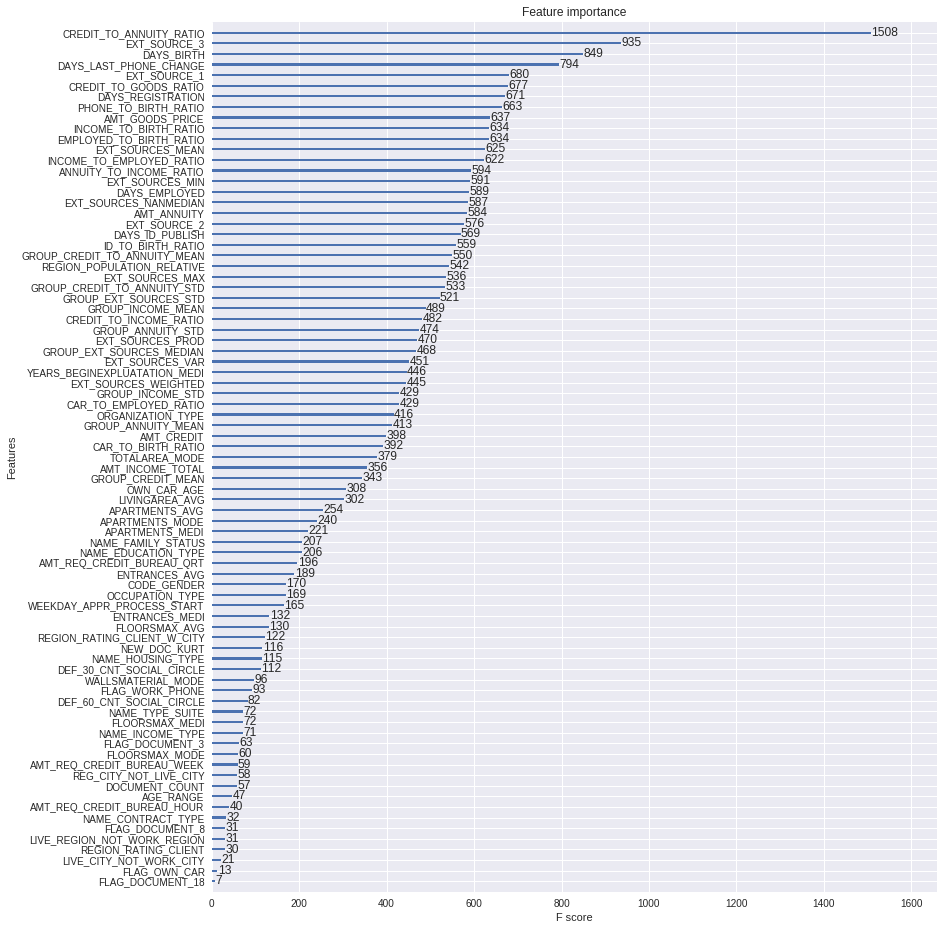

In [0]:
# plot feature importance
fig, ax = plt.subplots(figsize=(13, 16))
xgb.plot_importance(xgb_model, ax =ax)
plt.show()

In [0]:
xgb_model.best_iteration

1961

In [0]:
target_pred = xgb_model.predict_proba(test[predictors])[:, 1]
test['TARGET'] = target_pred.copy()
SUBMISSION_SUFIX = "_model_01"
test[['SK_ID_CURR', 'TARGET']].to_csv('submission{}.csv'.format(SUBMISSION_SUFIX), index=False)

In [0]:
submit = pd.read_csv("submission_model_01.csv", nrows= None)
submit.head()

,SK_ID_CURR,TARGET
0,100001,0.032680
1,100005,0.105461
2,100013,0.011710
3,100028,0.050465
4,100038,0.165538


## XGboost - 2nd

In [0]:
# spliting data
del_features = ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index', 'level_0']
predictors = list(filter(lambda v: v not in del_features, train.columns))

y = train['TARGET']
X = train[predictors]

X_acttest = test[predictors]
y_acttest = test['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [0]:
%%time
# Extreme Gradient Boosting
param_int = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "max_depth":4 ,# default: 3 oly for depthwise
    "n_estimators": 2000, # default:500
    "learning_rate": 0.025,# default: 0.05
    "gamma": 0.0,
    "min_child_wweight":10, # default:1
    "subsample":0.7,
    "colsample_bytree": 0.6, # default:1.0
    "colsample_btlevel":0.5, # default:1.0
    "reg_alpha":0.0,
    "reg_lambda":1.0,
    "scale_pse_weight":1.0,
    "random_state":0,
    #
    "silent": True,
    "n_jobs":14,
    #
    "tree_method": "hist", # default: auto
    "grow_policy": "lossguide", # default: depthwise
    "max_leaves": 0, # default: 0 (unlimited)
    "max_bin": 256  # default: 256    
}
param_fit = {
    "eval_metric": "auc",
    "early_stopping_rounds": 500, # default: 10
    "verbose": 200,
    "eval_set": [(X_train,y_train),(X_val,y_val),(X_test,y_test)]
}
xgb_model = xgb.XGBClassifier(**param_int)
xgb_model.fit(X_train,y_train, **param_fit)
evals_result = xgb_model.evals_result()
evals_result



[0]	validation_0-auc:0.681099	validation_1-auc:0.679075	validation_2-auc:0.682141
Multiple eval metrics have been passed: 'validation_2-auc' will be used for early stopping.

Will train until validation_2-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.774337	validation_1-auc:0.762307	validation_2-auc:0.758958
[400]	validation_0-auc:0.79841	validation_1-auc:0.77477	validation_2-auc:0.772008
[600]	validation_0-auc:0.811365	validation_1-auc:0.778927	validation_2-auc:0.776577
[800]	validation_0-auc:0.821468	validation_1-auc:0.781177	validation_2-auc:0.778481
[1000]	validation_0-auc:0.83037	validation_1-auc:0.782341	validation_2-auc:0.779696
[1200]	validation_0-auc:0.838525	validation_1-auc:0.783202	validation_2-auc:0.780401
[1400]	validation_0-auc:0.846078	validation_1-auc:0.783314	validation_2-auc:0.780755
[1600]	validation_0-auc:0.85288	validation_1-auc:0.783768	validation_2-auc:0.781019
[1800]	validation_0-auc:0.859108	validation_1-auc:0.783927	validation_2-auc:0.780785
[19

In [0]:
import pickle
# pickle.dump(xgb_model, open("xgb_model_v02.mod","wb"))

# # Saving requirement
# # Install the PyDrive wrapper & import libraries.
# # This only needs to be done once in a notebook.
# !pip install -U -q PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# # Authenticate and create the PyDrive client.
# # This only needs to be done once in a notebook.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)
# # Create & upload a file.
# uploaded = drive.CreateFile({'title': 'xgb_model_v02.mod'})
# uploaded.SetContentFile('xgb_model_v02.mod')
# uploaded.Upload()

xgb_model = pickle.load(open('drive/My Drive/Kaggle/home credit/xgb_model_v02.mod', 'rb'))

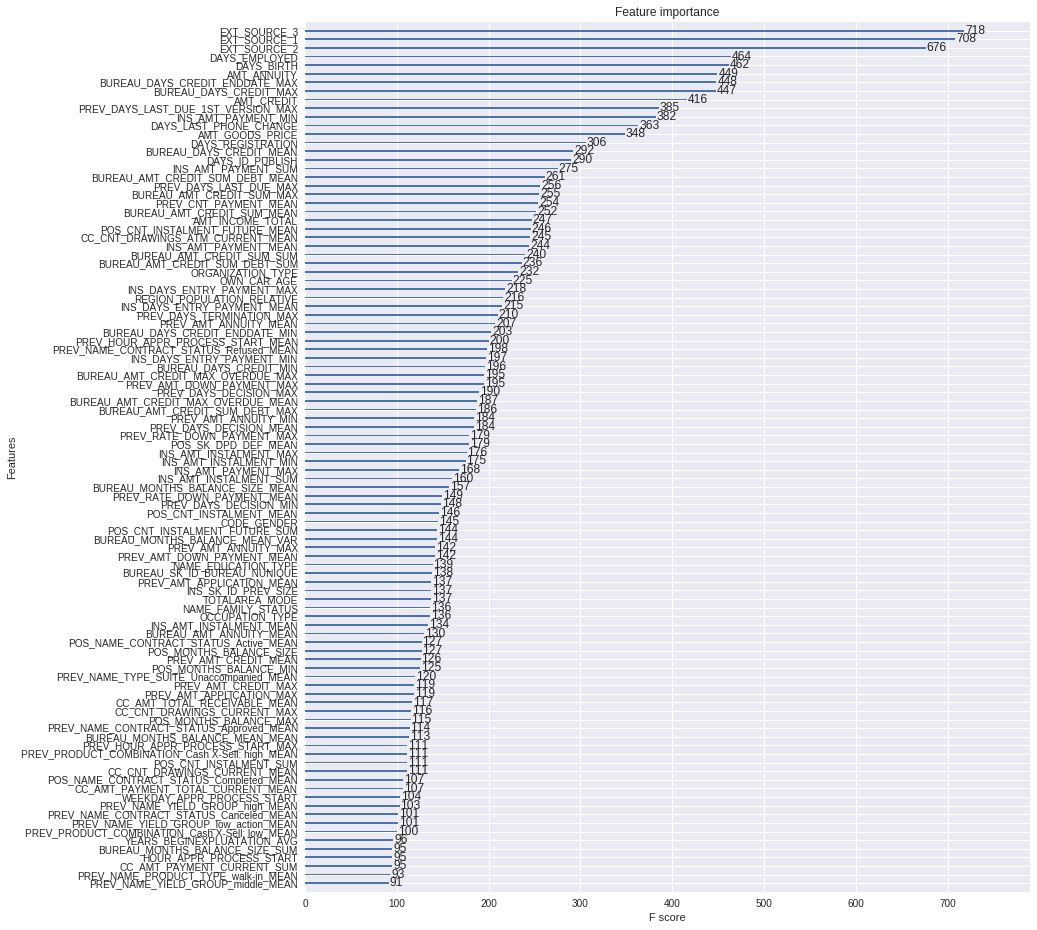

In [0]:
# plot feature importance
fig, ax = plt.subplots(figsize=(13, 16))
xgb.plot_importance(xgb_model, ax =ax, max_num_features = 100)
plt.show()

In [0]:
xgb_model.best_iteration

1636

In [0]:
target_pred = xgb_model.predict_proba(test[predictors])[:, 1]
test['TARGET'] = target_pred.copy()
SUBMISSION_SUFIX = "_model_02"
test[['SK_ID_CURR', 'TARGET']].to_csv('submission{}.csv'.format(SUBMISSION_SUFIX), index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [0]:
submit = pd.read_csv("submission_model_02.csv", nrows= None)
submit.head()

,SK_ID_CURR,TARGET
0,100001,0.022897
1,100005,0.134306
2,100013,0.011448
3,100028,0.031662
4,100038,0.201174


In [0]:
submit.shape

(48744, 2)

## XGboost - 4th

In [0]:
# spliting data
del_features = ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index', 'level_0']
predictors = list(filter(lambda v: v not in del_features, train.columns))

y = train['TARGET']
X = train[predictors]

X_acttest = test[predictors]
y_acttest = test['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [0]:
%%time
# Extreme Gradient Boosting
param_int = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "max_depth":4 ,# default: 3 oly for depthwise
    "n_estimators": 2000, # default:500
    "learning_rate": 0.025,# default: 0.05
    "gamma": 0.0,
    "min_child_wweight":10, # default:1
    "subsample":0.7,
    "colsample_bytree": 0.6, # default:1.0
    "colsample_btlevel":0.5, # default:1.0
    "reg_alpha":0.0,
    "reg_lambda":1.0,
    "scale_pse_weight":1.0,
    "random_state":0,
    #
    "silent": True,
    "n_jobs":14,
    #
    "tree_method": "hist", # default: auto
    "grow_policy": "lossguide", # default: depthwise
    "max_leaves": 0, # default: 0 (unlimited)
    "max_bin": 256  # default: 256    
}
param_fit = {
    "eval_metric": "auc",
    "early_stopping_rounds": 500, # default: 10
    "verbose": 200,
    "eval_set": [(X_train,y_train),(X_val,y_val),(X_test,y_test)]
}
xgb_model = xgb.XGBClassifier(**param_int)
xgb_model.fit(X_train,y_train, **param_fit)
evals_result = xgb_model.evals_result()
evals_result



[0]	validation_0-auc:0.715168	validation_1-auc:0.715692	validation_2-auc:0.713753
Multiple eval metrics have been passed: 'validation_2-auc' will be used for early stopping.

Will train until validation_2-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.785339	validation_1-auc:0.771491	validation_2-auc:0.769614
[400]	validation_0-auc:0.810845	validation_1-auc:0.784606	validation_2-auc:0.782785
[600]	validation_0-auc:0.825232	validation_1-auc:0.789404	validation_2-auc:0.787079
[800]	validation_0-auc:0.836954	validation_1-auc:0.791497	validation_2-auc:0.789271
[1000]	validation_0-auc:0.846934	validation_1-auc:0.792727	validation_2-auc:0.790246
[1200]	validation_0-auc:0.85574	validation_1-auc:0.79363	validation_2-auc:0.791237
[1400]	validation_0-auc:0.863698	validation_1-auc:0.793961	validation_2-auc:0.791532
[1600]	validation_0-auc:0.871059	validation_1-auc:0.794095	validation_2-auc:0.791351
[1800]	validation_0-auc:0.877988	validation_1-auc:0.794147	validation_2-auc:0.79129
St

In [0]:
import pickle
# pickle.dump(xgb_model, open("xgb_model_v04.mod","wb"))

# # Saving requirement
# # Install the PyDrive wrapper & import libraries.
# # This only needs to be done once in a notebook.
# !pip install -U -q PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# # Authenticate and create the PyDrive client.
# # This only needs to be done once in a notebook.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)
# # Create & upload a file.
# uploaded = drive.CreateFile({'title': 'xgb_model_v04.mod'})
# uploaded.SetContentFile('xgb_model_v04.mod')
# uploaded.Upload()

xgb_model = pickle.load(open('drive/My Drive/Kaggle/home credit/xgb_model_v04.mod', 'rb'))

In [0]:
# Drop some less-information features
# imp[imp['model'] == 0].index
feature_names = X_2.columns
cols = pd.DataFrame(index=feature_names)
cols['model'] = pd.Series(xgb_model.feature_importances_, index=feature_names)


cols[(cols['model'] == 0)].index

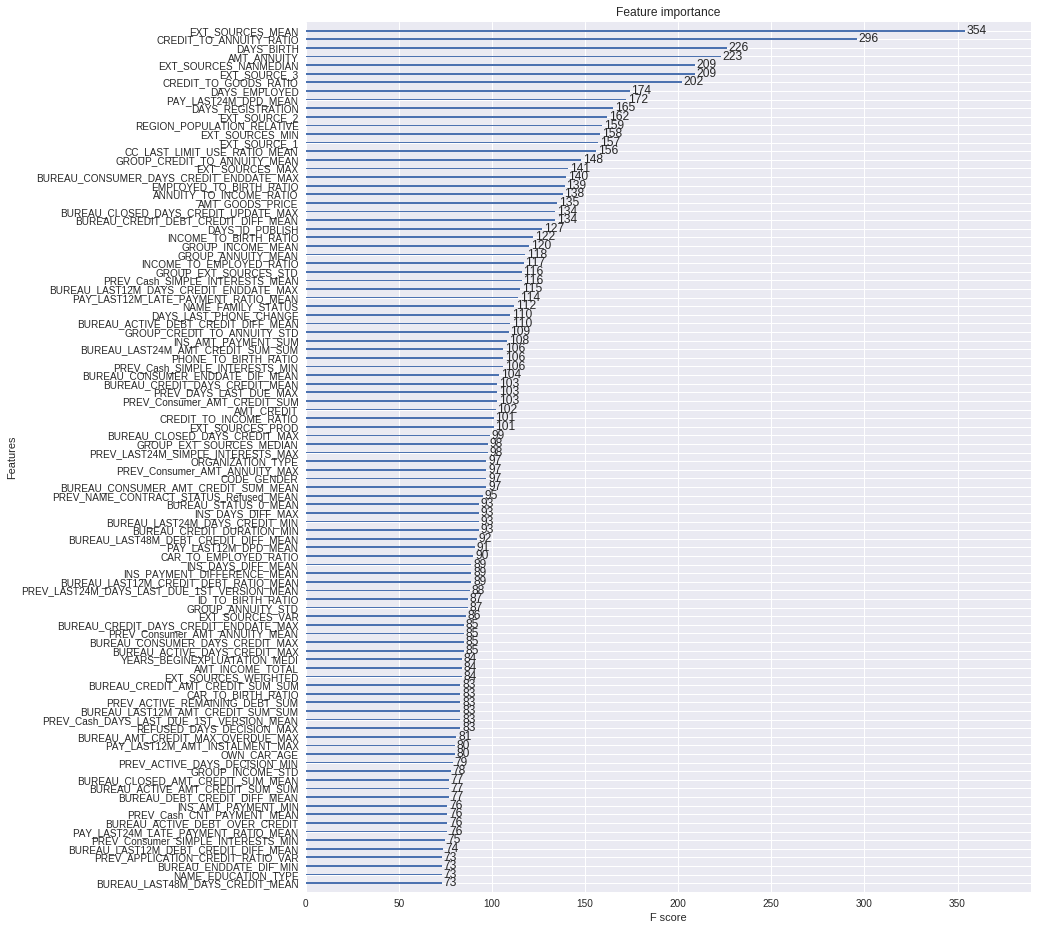

In [0]:
# plot feature importance
fig, ax = plt.subplots(figsize=(13, 16))
xgb.plot_importance(xgb_model, ax =ax, max_num_features = 100)
plt.show()

In [0]:
xgb_model.best_iteration

1468

In [0]:
target_pred = xgb_model.predict_proba(test[predictors])[:, 1]
test['TARGET'] = target_pred.copy()
SUBMISSION_SUFIX = "_model_04"
test[['SK_ID_CURR', 'TARGET']].to_csv('submission{}.csv'.format(SUBMISSION_SUFIX), index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [0]:
submit = pd.read_csv("submission_model_04.csv", nrows= None)
submit.head()

,SK_ID_CURR,TARGET
0,100001,0.024997
1,100005,0.178508
2,100013,0.020253
3,100028,0.050856
4,100038,0.157000


In [0]:
submit.shape

(48744, 2)

## XGboost - 5th

In [0]:
train = df[df['TARGET'].notnull()]
test = df[df['TARGET'].isnull()]
print("Train/valid shape: {}, test shape: {}".format(df.shape, test.shape))

Train/valid shape: (356250, 691), test shape: (48744, 691)


In [0]:
# spliting data
del_features = ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index', 'level_0']
predictors = list(filter(lambda v: v not in del_features, train.columns))

y = train['TARGET']
X = train[predictors]

X_acttest = test[predictors]
y_acttest = test['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [0]:
%%time
# Extreme Gradient Boosting
param_int = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "max_depth":4 ,# default: 3 oly for depthwise
    "n_estimators": 2000, # default:500
    "learning_rate": 0.025,# default: 0.05
    "gamma": 0.0,
    "min_child_wweight":10, # default:1
    "subsample":0.7,
    "colsample_bytree": 0.6, # default:1.0
    "colsample_btlevel":0.5, # default:1.0
    "reg_alpha":0.0,
    "reg_lambda":1.0,
    "scale_pse_weight":1.0,
    "random_state":0,
    #
    "silent": True,
    "n_jobs":14,
    #
    "tree_method": "hist", # default: auto
    "grow_policy": "lossguide", # default: depthwise
    "max_leaves": 0, # default: 0 (unlimited)
    "max_bin": 256  # default: 256    
}
param_fit = {
    "eval_metric": "auc",
    "early_stopping_rounds": 500, # default: 10
    "verbose": 200,
    "eval_set": [(X_train,y_train),(X_val,y_val),(X_test,y_test)]
}
xgb_model = xgb.XGBClassifier(**param_int)
xgb_model.fit(X_train,y_train, **param_fit)
evals_result = xgb_model.evals_result()
evals_result



[0]	validation_0-auc:0.699372	validation_1-auc:0.704818	validation_2-auc:0.701246
Multiple eval metrics have been passed: 'validation_2-auc' will be used for early stopping.

Will train until validation_2-auc hasn't improved in 500 rounds.
[200]	validation_0-auc:0.786021	validation_1-auc:0.772555	validation_2-auc:0.770429
[400]	validation_0-auc:0.811502	validation_1-auc:0.785575	validation_2-auc:0.78343
[600]	validation_0-auc:0.826071	validation_1-auc:0.790255	validation_2-auc:0.787836
[800]	validation_0-auc:0.837911	validation_1-auc:0.792446	validation_2-auc:0.789632
[1000]	validation_0-auc:0.8481	validation_1-auc:0.793883	validation_2-auc:0.791074
[1200]	validation_0-auc:0.857262	validation_1-auc:0.794712	validation_2-auc:0.791947
[1400]	validation_0-auc:0.865267	validation_1-auc:0.795388	validation_2-auc:0.792333
[1600]	validation_0-auc:0.872562	validation_1-auc:0.795916	validation_2-auc:0.792525
[1800]	validation_0-auc:0.879489	validation_1-auc:0.796124	validation_2-auc:0.792456
[1

In [0]:
import pickle
pickle.dump(xgb_model, open("xgb_model_v05.mod","wb"))

# Saving requirement
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
# Create & upload a file.
uploaded = drive.CreateFile({'title': 'xgb_model_v05.mod'})
uploaded.SetContentFile('xgb_model_v05.mod')
# uploaded.Upload()

# xgb_model = pickle.load(open('drive/My Drive/Kaggle/home credit/xgb_model_v05.mod', 'rb'))

In [0]:
# Drop some less-information features
# imp[imp['model'] == 0].index
feature_names = X.columns
cols = pd.DataFrame(index=feature_names)
cols['model'] = pd.Series(xgb_model.feature_importances_, index=feature_names)


cols[(cols['model'] == 0)].index

Index(['CC_NAME_CONTRACT_STATUS_Approved_MEAN',
       'CC_NAME_CONTRACT_STATUS_Demand_MEAN',
       'CC_NAME_CONTRACT_STATUS_Refused_MEAN',
       'CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN', 'INS_24M_SK_DPD_MAX',
       'INS_24M_TDRAWING_TPAYMENT_RATIO_MEAN', 'INS_48M_SK_DPD_SUM',
       'INS_48M_TDRAWING_BALANCE_RATIO_MEAN',
       'POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN',
       'POS_NAME_CONTRACT_STATUS_Canceled_MEAN',
       'POS_NAME_CONTRACT_STATUS_XNA_MEAN',
       'BUREAU_CLOSED_CREDIT_DEBT_RATIO_MEAN',
       'BUREAU_CONSUMER_AMT_CREDIT_SUM_OVERDUE_SUM'],
      dtype='object')

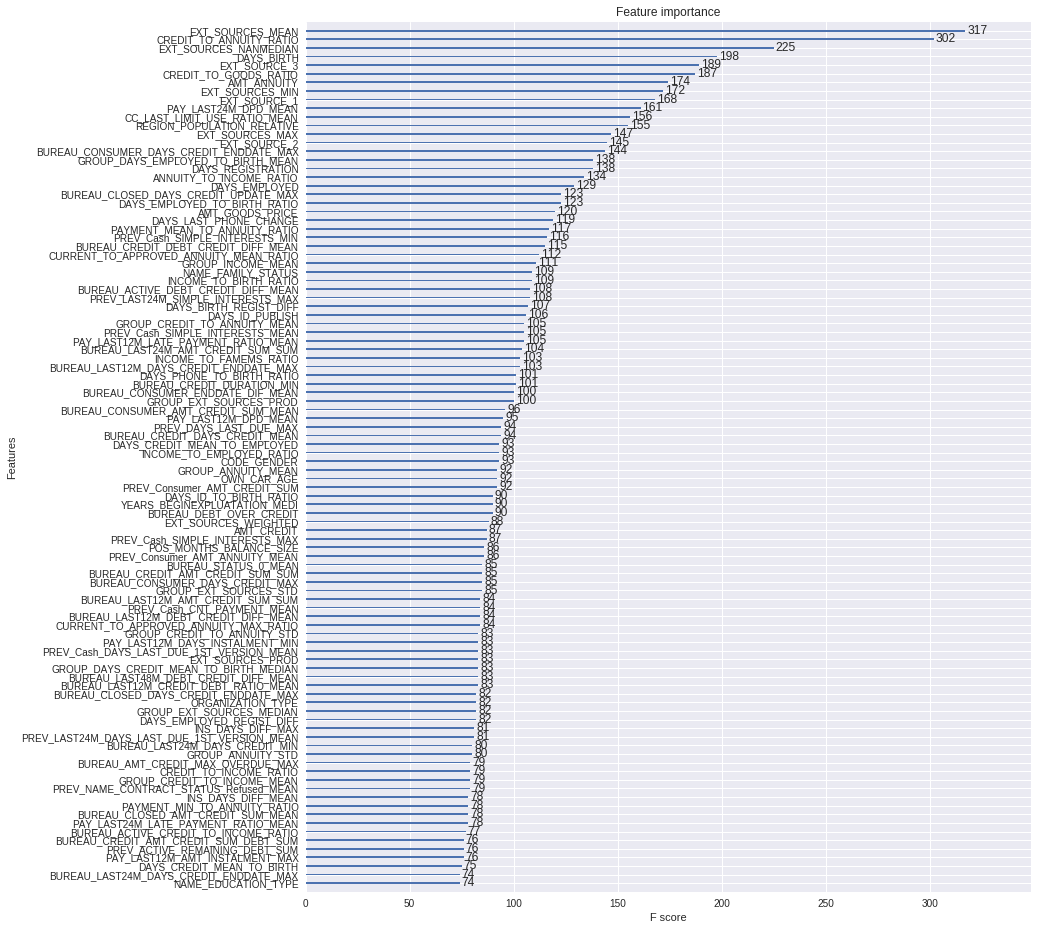

In [0]:
# plot feature importance
fig, ax = plt.subplots(figsize=(13, 16))
xgb.plot_importance(xgb_model, ax =ax, max_num_features = 100)
plt.show()

In [0]:
xgb_model.best_iteration

1597

In [0]:
target_pred = xgb_model.predict_proba(test[predictors])[:, 1]
test['TARGET'] = target_pred.copy()
SUBMISSION_SUFIX = "_model_05"
test[['SK_ID_CURR', 'TARGET']].to_csv('submission{}.csv'.format(SUBMISSION_SUFIX), index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [0]:
submit = pd.read_csv("submission_model_05.csv", nrows= None)
submit.head()

,SK_ID_CURR,TARGET
0,100001,0.027979
1,100005,0.169136
2,100013,0.026590
3,100028,0.051557
4,100038,0.178549


In [0]:
submit.shape

(48744, 2)

## XGboost - 6th

In [0]:
train = df[df['TARGET'].notnull()]
test = df[df['TARGET'].isnull()]
print("Train/valid shape: {}, test shape: {}".format(df.shape, test.shape))

Train/valid shape: (356250, 688), test shape: (48744, 688)


In [0]:
# spliting data
del_features = ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index', 'level_0']
predictors = list(filter(lambda v: v not in del_features, train.columns))

y = train['TARGET']
X = train[predictors]

X_acttest = test[predictors]
y_acttest = test['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [0]:
%%time
# Extreme Gradient Boosting
param_int = {
    # general
    "booster": "gbtree",
    
    # learning
    "objective": "binary:logistic",
    
    # Booster parameters    
    "max_depth": 6 ,# default: 3 oly for depthwise
    "n_estimators": 3000, # default:500
    "learning_rate": 0.015, #0.025,# default: 0.05
    "gamma": 0.0,
    "min_child_wweight":10, # default:1
    "subsample":0.7,
    "colsample_bytree": 0.6, # default:1.0
    "colsample_btlevel":0.5, # default:1.0
    "reg_alpha": 0.5, #0.0,
    "reg_lambda": 0.5, #1.0,
    "scale_pse_weight":1.0,
    "random_state":0,
    #
    "silent": True,
    "n_jobs":14,
    #
    "tree_method": "hist", # default: auto
    "grow_policy": "lossguide", # default: depthwise
    "max_leaves": 0, # default: 0 (unlimited)
    "max_bin": 256  # default: 256    
}
param_fit = {
    "eval_metric": "auc",
    "early_stopping_rounds": 400, # default: 10
    "verbose": 200,
    "eval_set": [(X_train,y_train),(X_val,y_val),(X_test,y_test)]
}
xgb_model = xgb.XGBClassifier(**param_int)
xgb_model.fit(X_train,y_train, **param_fit)
evals_result = xgb_model.evals_result()
evals_result



[0]	validation_0-auc:0.731505	validation_1-auc:0.726839	validation_2-auc:0.723547
Multiple eval metrics have been passed: 'validation_2-auc' will be used for early stopping.

Will train until validation_2-auc hasn't improved in 400 rounds.
[200]	validation_0-auc:0.802328	validation_1-auc:0.767364	validation_2-auc:0.764959
[400]	validation_0-auc:0.841587	validation_1-auc:0.783359	validation_2-auc:0.781581
[600]	validation_0-auc:0.865249	validation_1-auc:0.788743	validation_2-auc:0.787161
[800]	validation_0-auc:0.88343	validation_1-auc:0.791557	validation_2-auc:0.78977
[1000]	validation_0-auc:0.899055	validation_1-auc:0.79278	validation_2-auc:0.790871
[1200]	validation_0-auc:0.912496	validation_1-auc:0.79376	validation_2-auc:0.791358
[1400]	validation_0-auc:0.923343	validation_1-auc:0.794216	validation_2-auc:0.7915
[1600]	validation_0-auc:0.933112	validation_1-auc:0.794567	validation_2-auc:0.791569
[1800]	validation_0-auc:0.941519	validation_1-auc:0.794736	validation_2-auc:0.791602
[2000

In [0]:
import pickle
pickle.dump(xgb_model, open("xgb_model_v06.mod","wb"))

# Saving requirement
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
# Create & upload a file.
uploaded = drive.CreateFile({'title': 'xgb_model_v06.mod'})
uploaded.SetContentFile('xgb_model_v06.mod')
# uploaded.Upload()

# xgb_model = pickle.load(open('drive/My Drive/Kaggle/home credit/xgb_model_v06.mod', 'rb'))

In [0]:
# Drop some less-information features
# imp[imp['model'] == 0].index
feature_names = X.columns
cols = pd.DataFrame(index=feature_names)
cols['model'] = pd.Series(xgb_model.feature_importances_, index=feature_names)


cols[(cols['model'] == 0)].index

Index(['CC_NAME_CONTRACT_STATUS_Approved_MEAN',
       'CC_NAME_CONTRACT_STATUS_Demand_MEAN',
       'CC_NAME_CONTRACT_STATUS_Refused_MEAN',
       'CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN', 'INS_48M_SK_DPD_SUM',
       'POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN',
       'POS_NAME_CONTRACT_STATUS_Canceled_MEAN',
       'POS_NAME_CONTRACT_STATUS_XNA_MEAN'],
      dtype='object')

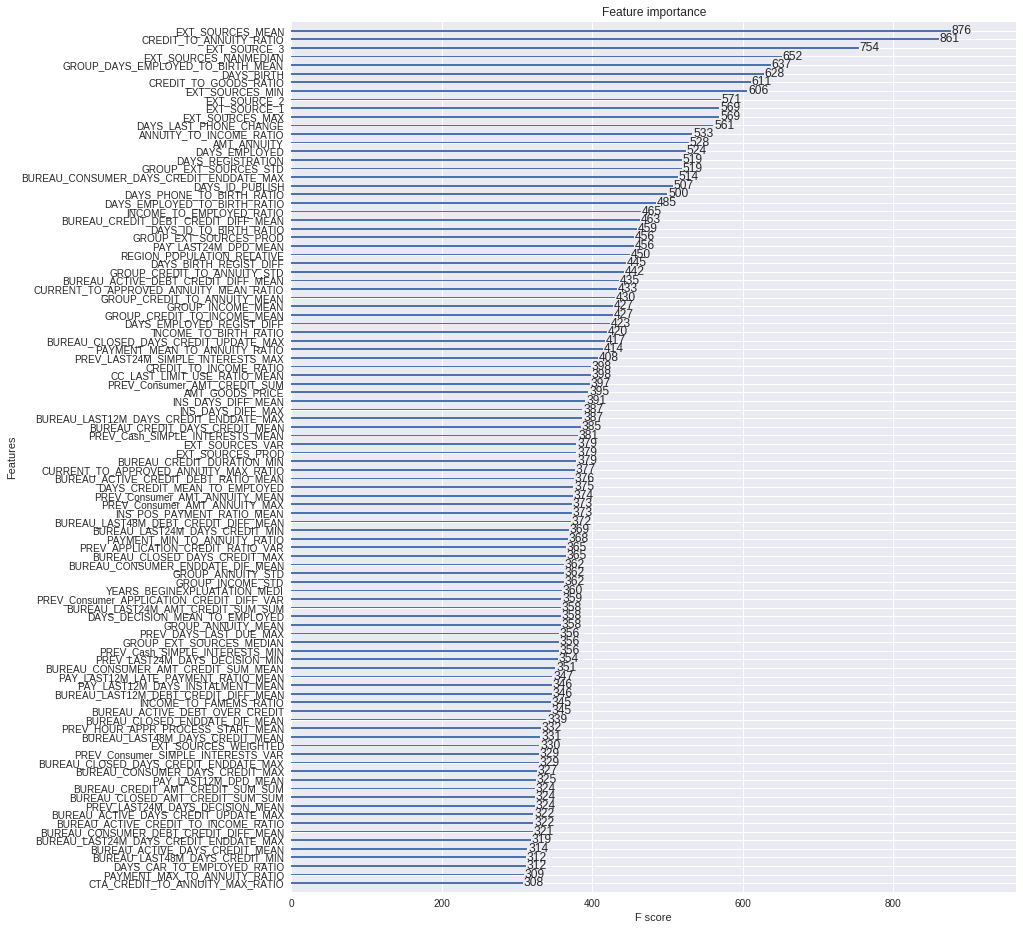

In [0]:
# plot feature importance
fig, ax = plt.subplots(figsize=(13, 16))
xgb.plot_importance(xgb_model, ax =ax, max_num_features = 100)
plt.show()

In [0]:
xgb_model.best_iteration

1890

In [0]:
target_pred = xgb_model.predict_proba(test[predictors])[:, 1]
test['TARGET'] = target_pred.copy()
SUBMISSION_SUFIX = "_model_06"
test[['SK_ID_CURR', 'TARGET']].to_csv('submission{}.csv'.format(SUBMISSION_SUFIX), index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [0]:
submit = pd.read_csv("submission_model_05.csv", nrows= None)
submit.head()

,SK_ID_CURR,TARGET
0,100001,0.027979
1,100005,0.169136
2,100013,0.026590
3,100028,0.051557
4,100038,0.178549


In [0]:
submit.shape

(48744, 2)

## XGboost - 7th

In [0]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import xgboost as xgb

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection  import GridSearchCV

In [0]:
train = df[df['TARGET'].notnull()]
test = df[df['TARGET'].isnull()]
print("Train/valid shape: {}, test shape: {}".format(df.shape, test.shape))

Train/valid shape: (356250, 778), test shape: (48744, 778)


In [0]:
# spliting data
del_features = ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index', 'level_0']
predictors = list(filter(lambda v: v not in del_features, train.columns))

y = train['TARGET']
X = train[predictors]

X_acttest = test[predictors]
y_acttest = test['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [0]:
%%time
# tunning 1
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
param_int = {
    # general
    "booster": "gbtree",   
#    "nthread":4, core running
    # learning
    "objective": "binary:logistic",    
    "seed": 20, # random seed for quick learning/ tunning parameter
    
    # Booster parameters   
    "learning_rate": 0.015, #0.025,# default: 0.05    
#     "max_depth": 6 ,# default: 3 oly for depthwise
#     "min_child_weight":10, # default:1
    "gamma": 0.0,
    "subsample":0.7,
    "colsample_bytree": 0.6, # default:1.0
    
    "n_estimators": 10, # default:500  
    
    "colsample_btlevel":0.5, # default:1.0
#     "reg_alpha": 0.5, #0.0,
#     "reg_lambda": 0.5, #1.0,
    "scale_pos_weight":1.0,
    "random_state":0,
    #
    "silent": True,
    "n_jobs":14,
    #
    "tree_method": "hist", # default: auto
    "grow_policy": "lossguide", # default: depthwise
    "max_leaves": 0, # default: 0 (unlimited)
    "max_bin": 256  # default: 256         
}
# learning_rate =0.1, n_estimators=140, max_depth=5,
#  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
#  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)


gsearch1 = GridSearchCV(
    estimator = xgb.XGBClassifier(**param_int), 
    param_grid = param_test1,
    scoring='roc_auc',
    n_jobs=2,
    iid=False, cv=3)

gsearch1.fit(X_train,y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_


In [0]:
%%time
# tuning 2
# Extreme Gradient Boosting
param_int = {
    # general
    "booster": "gbtree",    
    # learning
    "objective": "binary:logistic",    
    # Booster parameters   
    "learning_rate": 0.05, #0.025,# default: 0.05    
    "max_depth": 6 ,# default: 3 oly for depthwise
    "min_child_weight":10, # default:1
    "gamma": 0.0,
    "subsample":0.75, # 0.7
    "colsample_bytree": 0.6, # default:1.0
    
    "n_estimators": 500, # default:500  
    
    "colsample_btlevel":0.5, # default:1.0
    "reg_alpha": 0.5, #0.0,
    "reg_lambda": 0.5, #1.0,
    "scale_pos_weight":1.0,
    "random_state":0,
    #
    "silent": True,
    "n_jobs":14,
    #
    "tree_method": "hist", # default: auto
    "grow_policy": "lossguide", # default: depthwise
    "max_leaves": 0, # default: 0 (unlimited)
    "max_bin": 256  # default: 256    
}
param_fit = {
    "eval_metric": "auc",
    "early_stopping_rounds": 400, # default: 10
    "verbose": 100,
    "eval_set": [(X_train,y_train),(X_val,y_val),(X_test,y_test)]
}
xgb_model = xgb.XGBClassifier(**param_int)
xgb_model.fit(X_train,y_train, **param_fit)
evals_result = xgb_model.evals_result()
evals_result



[0]	validation_0-auc:0.729253	validation_1-auc:0.723863	validation_2-auc:0.720313
Multiple eval metrics have been passed: 'validation_2-auc' will be used for early stopping.

Will train until validation_2-auc hasn't improved in 400 rounds.
[100]	validation_0-auc:0.856293	validation_1-auc:0.7868	validation_2-auc:0.78399
[200]	validation_0-auc:0.891905	validation_1-auc:0.789012	validation_2-auc:0.785251
[300]	validation_0-auc:0.91834	validation_1-auc:0.788548	validation_2-auc:0.784869
[400]	validation_0-auc:0.939757	validation_1-auc:0.787307	validation_2-auc:0.783139
[499]	validation_0-auc:0.954729	validation_1-auc:0.785451	validation_2-auc:0.782078
CPU times: user 28min 48s, sys: 24 s, total: 29min 12s
Wall time: 15min 57s


In [0]:
%%time
# tunning 3
# Extreme Gradient Boosting
param_int = {
    # general
    "booster": "gbtree",    
    # learning
    "objective": "binary:logistic",    
    # Booster parameters   
    "learning_rate": 0.05, #0.025,# default: 0.05    
    "max_depth": 6 ,# default: 3 oly for depthwise
    "min_child_weight":10, # default:1
    "gamma": 0.0,
    "subsample":0.65, # 0.7
    "colsample_bytree": 0.6, # default:1.0
    
    "n_estimators": 500, # default:500  
    
    "colsample_btlevel":0.5, # default:1.0
    "reg_alpha": 0.5, #0.0,
    "reg_lambda": 0.5, #1.0,
    "scale_pos_weight":1.0,
    "random_state":0,
    #
    "silent": True,
    "n_jobs":14,
    #
    "tree_method": "hist", # default: auto
    "grow_policy": "lossguide", # default: depthwise
    "max_leaves": 0, # default: 0 (unlimited)
    "max_bin": 256  # default: 256    
}
param_fit = {
    "eval_metric": "auc",
    "early_stopping_rounds": 400, # default: 10
    "verbose": 100,
    "eval_set": [(X_train,y_train),(X_val,y_val),(X_test,y_test)]
}
xgb_model = xgb.XGBClassifier(**param_int)
xgb_model.fit(X_train,y_train, **param_fit)
evals_result = xgb_model.evals_result()
evals_result



[0]	validation_0-auc:0.730407	validation_1-auc:0.724417	validation_2-auc:0.720723
Multiple eval metrics have been passed: 'validation_2-auc' will be used for early stopping.

Will train until validation_2-auc hasn't improved in 400 rounds.
[100]	validation_0-auc:0.822969	validation_1-auc:0.779604	validation_2-auc:0.776534
[200]	validation_0-auc:0.855188	validation_1-auc:0.788454	validation_2-auc:0.785466
[300]	validation_0-auc:0.87699	validation_1-auc:0.791649	validation_2-auc:0.787674
[400]	validation_0-auc:0.893554	validation_1-auc:0.792258	validation_2-auc:0.78832
[499]	validation_0-auc:0.907618	validation_1-auc:0.79292	validation_2-auc:0.787992
CPU times: user 28min 34s, sys: 26.2 s, total: 29min
Wall time: 15min 54s


In [0]:
%%time
# tunning 4
# Extreme Gradient Boosting
param_int = {
    # general
    "booster": "gbtree",    
    # learning
    "objective": "binary:logistic",    
    # Booster parameters   
    "learning_rate": 0.05, #0.025,# default: 0.05    
    "max_depth": 6 ,# default: 3 oly for depthwise
    "min_child_weight":10, # default:1
    "gamma": 0.0,
    "subsample":0.65, # 0.7 # Lower values make the algorithm more conservative
                            #and prevents overfitting but too small values might lead to under-fitting.
    "colsample_bytree": 0.65, # default:1.0
    
    "n_estimators": 500, # default:500  
    
    "colsample_btlevel":0.7, # 0.5, default:1.0 # Denotes the subsample ratio of columns for each split, in each level.
    "reg_alpha": 0.7, #0.0,
    "reg_lambda": 0.7, #1.0,
    "scale_pos_weight":1.0,
    "random_state":0,
    #
    "silent": True,
    "n_jobs":14,
    #
    "tree_method": "hist", # default: auto
    "grow_policy": "lossguide", # default: depthwise
    "max_leaves": 0, # default: 0 (unlimited)
    "max_bin": 256  # default: 256    
}
param_fit = {
    "eval_metric": "auc",
    "early_stopping_rounds": 400, # default: 10
    "verbose": 100,
    "eval_set": [(X_train,y_train),(X_val,y_val),(X_test,y_test)]
}
xgb_model = xgb.XGBClassifier(**param_int)
xgb_model.fit(X_train,y_train, **param_fit)
evals_result = xgb_model.evals_result()
evals_result



[0]	validation_0-auc:0.730243	validation_1-auc:0.724443	validation_2-auc:0.7206
Multiple eval metrics have been passed: 'validation_2-auc' will be used for early stopping.

Will train until validation_2-auc hasn't improved in 400 rounds.
[100]	validation_0-auc:0.823302	validation_1-auc:0.779239	validation_2-auc:0.778023
[200]	validation_0-auc:0.856375	validation_1-auc:0.788662	validation_2-auc:0.787589
[300]	validation_0-auc:0.877791	validation_1-auc:0.791572	validation_2-auc:0.789493
[400]	validation_0-auc:0.894758	validation_1-auc:0.792298	validation_2-auc:0.789784
[499]	validation_0-auc:0.908865	validation_1-auc:0.792559	validation_2-auc:0.789603
CPU times: user 28min 43s, sys: 23.1 s, total: 29min 6s
Wall time: 15min 55s


In [0]:
%%time
# tunning 5
# Extreme Gradient Boosting
param_int = {
    # general
    "booster": "gbtree",    
    # learning
    "objective": "binary:logistic",    
    # Booster parameters   
    "learning_rate": 0.015, #0.025,# default: 0.05    
    "max_depth": 6 ,# default: 3 oly for depthwise
    "min_child_weight":10, # default:1
    "gamma": 0.0,
    "subsample":0.65, # 0.7 # Lower values make the algorithm more conservative
                            #and prevents overfitting but too small values might lead to under-fitting.
    "colsample_bytree": 0.65, # default:1.0
    
    "n_estimators": 2000, # default:500  
    
    "colsample_btlevel":0.65, # 0.5, default:1.0 # Denotes the subsample ratio of columns for each split, in each level.
    "reg_alpha": 0.65, #0.0,
    "reg_lambda": 0.65, #1.0,
    "scale_pos_weight":1.0,
    "random_state":0,
    #
    "silent": True,
    "n_jobs":14,
    #
    "tree_method": "hist", # default: auto
    "grow_policy": "lossguide", # default: depthwise
    "max_leaves": 0, # default: 0 (unlimited)
    "max_bin": 256  # default: 256     
}
param_fit = {
    "eval_metric": "auc",
    "early_stopping_rounds": 400, # default: 10
    "verbose": 100,
    "eval_set": [(X_train,y_train),(X_val,y_val),(X_test,y_test)]
}
xgb_model = xgb.XGBClassifier(**param_int)
xgb_model.fit(X_train,y_train, **param_fit)
evals_result = xgb_model.evals_result()
evals_result



[0]	validation_0-auc:0.730245	validation_1-auc:0.724444	validation_2-auc:0.720601
Multiple eval metrics have been passed: 'validation_2-auc' will be used for early stopping.

Will train until validation_2-auc hasn't improved in 400 rounds.
[100]	validation_0-auc:0.780333	validation_1-auc:0.758897	validation_2-auc:0.756248
[200]	validation_0-auc:0.79895	validation_1-auc:0.767973	validation_2-auc:0.766077
[300]	validation_0-auc:0.818292	validation_1-auc:0.777296	validation_2-auc:0.776081
[400]	validation_0-auc:0.832513	validation_1-auc:0.783186	validation_2-auc:0.78234
[500]	validation_0-auc:0.843135	validation_1-auc:0.786833	validation_2-auc:0.785612
[600]	validation_0-auc:0.852334	validation_1-auc:0.789317	validation_2-auc:0.787871
[700]	validation_0-auc:0.860057	validation_1-auc:0.790511	validation_2-auc:0.789266
[800]	validation_0-auc:0.867544	validation_1-auc:0.791479	validation_2-auc:0.790357
[900]	validation_0-auc:0.873996	validation_1-auc:0.79226	validation_2-auc:0.791076
[1000]	

In [0]:
%%time
# Extreme Gradient Boosting
param_int = {
    # general
    "booster": "gbtree",    
    # learning
    "objective": "binary:logistic",    
    # Booster parameters   
    "learning_rate": 0.015, #0.025,# default: 0.05    
    "max_depth": 6 ,# default: 3 oly for depthwise
    "min_child_weight":10, # default:1
    "gamma": 0.0,
    "subsample":0.76, # 0.7 # Lower values make the algorithm more conservative
                            #and prevents overfitting but too small values might lead to under-fitting.
    "colsample_bytree": 0.66, # default:1.0
    
    "n_estimators": 5000, # default:500  
    
    "colsample_btlevel":0.5, # 0.5, default:1.0 # Denotes the subsample ratio of columns for each split, in each level.
    "reg_alpha": 0.56, #0.0,
    "reg_lambda": 0.56, #1.0,
    "scale_pos_weight":1.0,
    "random_state":  737851,#0,
    #
    "silent": True,
    "n_jobs":14,
    #
    "tree_method": "hist", # default: auto
    "grow_policy": "lossguide", # default: depthwise
    "max_leaves": 0, # default: 0 (unlimited)
    "max_bin": 256  # default: 256     
}


param_fit = {
    "eval_metric": "auc",
    "early_stopping_rounds": 250, # default: 10
    "verbose": 250,
    "eval_set": [(X_train,y_train),(X_val,y_val),(X_test,y_test)]
}
xgb_model = xgb.XGBClassifier(**param_int)
xgb_model.fit(X_train,y_train, **param_fit)
evals_result = xgb_model.evals_result()
evals_result



[0]	validation_0-auc:0.734407	validation_1-auc:0.727428	validation_2-auc:0.72327
Multiple eval metrics have been passed: 'validation_2-auc' will be used for early stopping.

Will train until validation_2-auc hasn't improved in 250 rounds.


In [0]:
import pickle
pickle.dump(xgb_model, open("xgb_model_v07-1.mod","wb"))

# Saving requirement
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
# Create & upload a file.
uploaded = drive.CreateFile({'title': 'xgb_model_v07-1.mod'})
uploaded.SetContentFile('xgb_model_v07-1.mod')
uploaded.Upload()

# xgb_model = pickle.load(open('drive/My Drive/Kaggle/home credit/xgb_model_v07.mod', 'rb'))

In [0]:
# show some less important features
# imp[imp['model'] == 0].index
feature_names = X.columns
cols = pd.DataFrame(index=feature_names)
cols['model'] = pd.Series(xgb_model.feature_importances_, index=feature_names)


cols[(cols['model'] == 0)].index

Index(['AMT_REQ_CREDIT_BUREAU_HOUR',
       'PREV_NAME_TYPE_SUITE_Group of people_MEAN',
       'PREV_FLAG_LAST_APPL_PER_CONTRACT_N_MEAN',
       'CC_CNT_DRAWINGS_OTHER_CURRENT_SUM',
       'CC_NAME_CONTRACT_STATUS_Approved_MEAN',
       'CC_NAME_CONTRACT_STATUS_Demand_MEAN',
       'CC_NAME_CONTRACT_STATUS_Refused_MEAN',
       'CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN', 'INS_24M_SK_DPD_MAX',
       'INS_24M_SK_DPD_SUM', 'INS_48M_SK_DPD_MAX', 'INS_48M_SK_DPD_SUM',
       'INS_48M_TDRAWING_TPAYMENT_RATIO_MEAN',
       'POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN',
       'POS_NAME_CONTRACT_STATUS_Canceled_MEAN',
       'POS_NAME_CONTRACT_STATUS_Demand_MEAN',
       'POS_NAME_CONTRACT_STATUS_XNA_MEAN'],
      dtype='object')

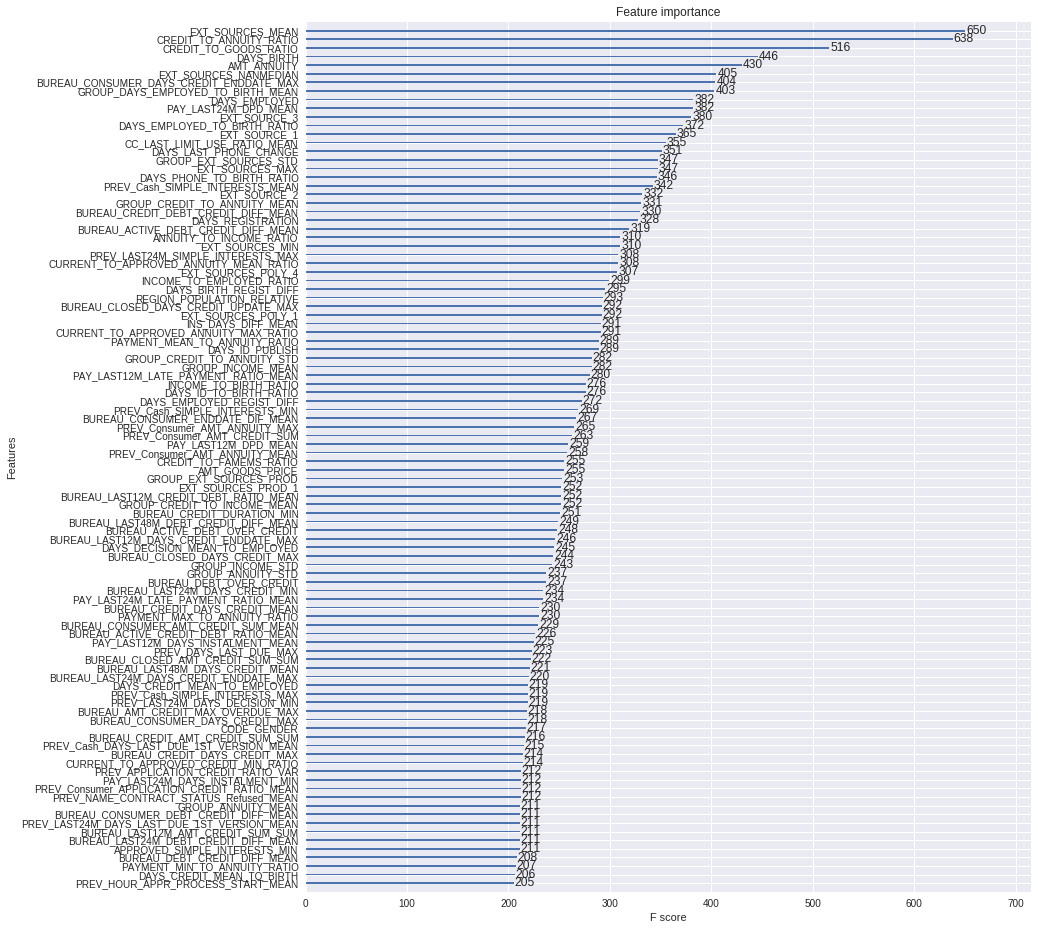

In [0]:
# plot feature importance
fig, ax = plt.subplots(figsize=(13, 16))
xgb.plot_importance(xgb_model, ax =ax, max_num_features = 100)
plt.show()

In [0]:
xgb_model.best_iteration

1742

In [0]:
target_pred = xgb_model.predict_proba(test[predictors])[:, 1]
test['TARGET'] = target_pred.copy()
SUBMISSION_SUFIX = "_model_07-1"
test[['SK_ID_CURR', 'TARGET']].to_csv('submission{}.csv'.format(SUBMISSION_SUFIX), index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [0]:
submit = pd.read_csv("submission_model_07.csv", nrows= None)
submit.head()

,SK_ID_CURR,TARGET
0,100001,0.027979
1,100005,0.169136
2,100013,0.026590
3,100028,0.051557
4,100038,0.178549


In [0]:
submit.shape

(48744, 2)

## LGBM - 1st


In [0]:
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

In [0]:
train = df[df['TARGET'].notnull()]
test = df[df['TARGET'].isnull()]
print("Train/valid shape: {}, test shape: {}".format(df.shape, test.shape))

Train/valid shape: (356250, 688), test shape: (48744, 688)


In [0]:
# spliting data
del_features = ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index', 'level_0']
predictors = list(filter(lambda v: v not in del_features, train.columns))

y = train['TARGET']
X = train[predictors]

X_acttest = test[predictors]
y_acttest = test['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [0]:
# LIGHTGBM CONFIGURATION AND HYPER-PARAMETERS

RANDOM_SEED = 737851


LIGHTGBM_PARAMS = {
    'boosting_type': 'goss',
    'n_estimators': 2000, #10000,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 1,
    'is_unbalance': False,
    'silent':-1,
    'verbose':-1,
    #
    'random_state': RANDOM_SEED, 
    'nthread': 4
}
param_fit ={
    'eval_set' : [(X_train,y_train),(X_val,y_val),(X_test,y_test)],        
    'eval_metric':'auc', 
    'verbose':400, 
    'early_stopping_rounds': 500,
#     'feature_name'= list(df[predictors].columns), 
#     'categorical_feature'= categorical_feature
           }

lgbm_model = LGBMClassifier(**LIGHTGBM_PARAMS)

In [0]:
lgbm_model.fit(X_train,y_train, **param_fit)
# evals_result = lgbm_model.evals_result()
# evals_result

In [0]:
lgbm_model.

LGBMClassifier(boosting_type='goss', class_weight=None,
        colsample_bytree=0.508716, importance_type='split',
        is_unbalance=False, learning_rate=0.005134, max_depth=10,
        min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.024766, n_estimators=2000, n_jobs=-1, nthread=4,
        num_leaves=54, objective=None, random_state=737851,
        reg_alpha=0.436193, reg_lambda=0.479169, silent=-1, subsample=1,
        subsample_for_bin=240000, subsample_freq=0, verbose=-1)

In [0]:
import pickle
pickle.dump(lgbm_model, open("lgbm_model_v01.mod","wb"))

# Saving requirement
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
# Create & upload a file.
uploaded = drive.CreateFile({'title': 'lgbm_model_v01.mod'})
uploaded.SetContentFile('lgbm_model_v01.mod')
# uploaded.Upload()

# lgbm_model = pickle.load(open('drive/My Drive/Kaggle/home credit/lgbm_model_v01.mod', 'rb'))

In [0]:
# Drop some less-information features
# imp[imp['model'] == 0].index
feature_names = X.columns
cols = pd.DataFrame(index=feature_names)
cols['model'] = pd.Series(lgbm_model.feature_importances_, index=feature_names)


cols[(cols['model'] == 0)].index

Index(['CC_SK_ID_PREV_NUNIQUE', 'CC_NAME_CONTRACT_STATUS_Approved_MEAN',
       'CC_NAME_CONTRACT_STATUS_Demand_MEAN',
       'CC_NAME_CONTRACT_STATUS_Refused_MEAN',
       'CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN',
       'POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN',
       'POS_NAME_CONTRACT_STATUS_Canceled_MEAN',
       'POS_NAME_CONTRACT_STATUS_XNA_MEAN',
       'BUREAU_CLOSED_CREDIT_DEBT_RATIO_MEAN'],
      dtype='object')

In [0]:
# plot feature importance
fig, ax = plt.subplots(figsize=(13, 16))
xgb.plot_importance(lgbm_model, ax =ax, max_num_features = 100)
plt.show()

In [0]:
xgb_model.best_iteration

1597

In [0]:
target_pred = lgbm_model.predict_proba(test[predictors])[:, 1]
test['TARGET'] = target_pred.copy()
SUBMISSION_SUFIX = "_lgbmmodel_01"
test[['SK_ID_CURR', 'TARGET']].to_csv('submission{}.csv'.format(SUBMISSION_SUFIX), index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## LGBM - 2nd


In [0]:
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

In [0]:
train = df[df['TARGET'].notnull()]
test = df[df['TARGET'].isnull()]
print("Train/valid shape: {}, test shape: {}".format(df.shape, test.shape))

Train/valid shape: (356250, 733), test shape: (48744, 733)


In [0]:
# spliting data
del_features = ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index', 'level_0']
predictors = list(filter(lambda v: v not in del_features, train.columns))

y = train['TARGET']
X = train[predictors]

X_acttest = test[predictors]
y_acttest = test['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [0]:
# LIGHTGBM CONFIGURATION AND HYPER-PARAMETERS

RANDOM_SEED = 737851


LIGHTGBM_PARAMS = {
    'boosting_type': 'goss',
    'n_estimators': 5000, #10000,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 1,
    'is_unbalance': False,
    'silent':-1,
 #   'verbose':-1,
    #
    'random_state': RANDOM_SEED, 
    'nthread': 4
}
param_fit ={
    'eval_set' : [(X_train,y_train),(X_val,y_val),(X_test,y_test)],        
    'eval_metric':'auc', 
    'verbose':200, 
    'early_stopping_rounds': 200,
#     'feature_name'= list(df[predictors].columns), 
#     'categorical_feature'= categorical_feature
           }

lgbm_model = LGBMClassifier(**LIGHTGBM_PARAMS)

In [0]:
lgbm_model.fit(X_train,y_train, **param_fit)


Training until validation scores don't improve for 200 rounds.
[200]	training's binary_logloss: 0.246811	training's auc: 0.785864	valid_1's binary_logloss: 0.251403	valid_1's auc: 0.763003	valid_2's binary_logloss: 0.253067	valid_2's auc: 0.759768
[400]	training's binary_logloss: 0.233898	training's auc: 0.812749	valid_1's binary_logloss: 0.243868	valid_1's auc: 0.772898	valid_2's binary_logloss: 0.245466	valid_2's auc: 0.770479
[600]	training's binary_logloss: 0.225531	training's auc: 0.8304	valid_1's binary_logloss: 0.240266	valid_1's auc: 0.779549	valid_2's binary_logloss: 0.241781	valid_2's auc: 0.777546
[800]	training's binary_logloss: 0.219003	training's auc: 0.8442	valid_1's binary_logloss: 0.238091	valid_1's auc: 0.784269	valid_2's binary_logloss: 0.239626	valid_2's auc: 0.782262
[1000]	training's binary_logloss: 0.21352	training's auc: 0.855871	valid_1's binary_logloss: 0.236681	valid_1's auc: 0.787458	valid_2's binary_logloss: 0.238213	valid_2's auc: 0.785517
[1200]	training'

LGBMClassifier(boosting_type='goss', class_weight=None,
        colsample_bytree=0.508716, importance_type='split',
        is_unbalance=False, learning_rate=0.005134, max_depth=10,
        min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.024766, n_estimators=5000, n_jobs=-1, nthread=4,
        num_leaves=54, objective=None, random_state=737851,
        reg_alpha=0.436193, reg_lambda=0.479169, silent=-1, subsample=1,
        subsample_for_bin=240000, subsample_freq=0)

In [0]:
lgbm_model.

LGBMClassifier(boosting_type='goss', class_weight=None,
        colsample_bytree=0.508716, importance_type='split',
        is_unbalance=False, learning_rate=0.005134, max_depth=10,
        min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.024766, n_estimators=2000, n_jobs=-1, nthread=4,
        num_leaves=54, objective=None, random_state=737851,
        reg_alpha=0.436193, reg_lambda=0.479169, silent=-1, subsample=1,
        subsample_for_bin=240000, subsample_freq=0, verbose=-1)

In [0]:
import pickle
pickle.dump(lgbm_model, open("lgbm_model_v02.mod","wb"))

# Saving requirement
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
# Create & upload a file.
uploaded = drive.CreateFile({'title': 'lgbm_model_v02.mod'})
uploaded.SetContentFile('lgbm_model_v02.mod')
uploaded.Upload()

# lgbm_model = pickle.load(open('drive/My Drive/Kaggle/home credit/lgbm_model_v01.mod', 'rb'))

In [0]:
# Drop some less-information features
# imp[imp['model'] == 0].index
feature_names = X.columns
cols = pd.DataFrame(index=feature_names)
cols['model'] = pd.Series(lgbm_model.feature_importances_, index=feature_names)


cols[(cols['model'] == 0)].index

Index(['CC_NAME_CONTRACT_STATUS_Approved_MEAN',
       'CC_NAME_CONTRACT_STATUS_Demand_MEAN',
       'CC_NAME_CONTRACT_STATUS_Refused_MEAN',
       'CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN',
       'POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN',
       'POS_NAME_CONTRACT_STATUS_Canceled_MEAN',
       'POS_NAME_CONTRACT_STATUS_XNA_MEAN',
       'BUREAU_CLOSED_CREDIT_DEBT_RATIO_MEAN'],
      dtype='object')

In [0]:
target_pred = lgbm_model.predict_proba(test[predictors])[:, 1]
test['TARGET'] = target_pred.copy()
SUBMISSION_SUFIX = "_lgbmmodel_02"
test[['SK_ID_CURR', 'TARGET']].to_csv('submission{}.csv'.format(SUBMISSION_SUFIX), index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## LGBM - 3rd


In [0]:
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

In [0]:
train = df[df['TARGET'].notnull()]
test = df[df['TARGET'].isnull()]
print("Train/valid shape: {}, test shape: {}".format(df.shape, test.shape))

Train/valid shape: (356250, 778), test shape: (48744, 778)


In [0]:
# spliting data
del_features = ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index', 'level_0']
predictors = list(filter(lambda v: v not in del_features, train.columns))

y = train['TARGET']
X = train[predictors]

X_acttest = test[predictors]
y_acttest = test['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [0]:
# LIGHTGBM CONFIGURATION AND HYPER-PARAMETERS

LIGHTGBM_PARAMS = {
    # general
    'boosting_type': 'goss',
    # booster
    'n_estimators': 5000, #10000,
    'learning_rate': 0.005134,
    'num_leaves': 54, #number of leaves in full tree
    'max_depth': 10,
    'subsample_for_bin': 240000, #Number of samples for constructing bins.
    'reg_alpha': 0.7, #0.436193,
    'reg_lambda': 0.7, #0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 0.7,#1,
    # controller
    'is_unbalance': False,
    'silent':-1,
 #   'verbose':-1,
    #
    'random_state': 737851,  # this seed is used to generate other seeds
    'nthread': 4
}
param_fit ={
    'eval_set' : [(X_train,y_train),(X_val,y_val),(X_test,y_test)],        
    'eval_metric':'auc', 
    'verbose':200, 
    'early_stopping_rounds': 200,
#     'feature_name'= list(df[predictors].columns), 
#     'categorical_feature'= categorical_feature
           }

lgbm_model = LGBMClassifier(**LIGHTGBM_PARAMS)

In [0]:
lgbm_model.fit(X_train,y_train, **param_fit)


Training until validation scores don't improve for 200 rounds.
[200]	training's binary_logloss: 0.24694	training's auc: 0.786093	valid_1's binary_logloss: 0.251406	valid_1's auc: 0.763365	valid_2's binary_logloss: 0.25311	valid_2's auc: 0.760281
[400]	training's binary_logloss: 0.234114	training's auc: 0.812159	valid_1's binary_logloss: 0.24384	valid_1's auc: 0.773067	valid_2's binary_logloss: 0.245475	valid_2's auc: 0.770566
[600]	training's binary_logloss: 0.225815	training's auc: 0.829331	valid_1's binary_logloss: 0.240238	valid_1's auc: 0.779528	valid_2's binary_logloss: 0.241725	valid_2's auc: 0.777902
[800]	training's binary_logloss: 0.219409	training's auc: 0.842904	valid_1's binary_logloss: 0.238081	valid_1's auc: 0.784122	valid_2's binary_logloss: 0.239561	valid_2's auc: 0.782588
[1000]	training's binary_logloss: 0.214016	training's auc: 0.854445	valid_1's binary_logloss: 0.236723	valid_1's auc: 0.787037	valid_2's binary_logloss: 0.238233	valid_2's auc: 0.785587
[1200]	trainin

LGBMClassifier(boosting_type='goss', class_weight=None,
        colsample_bytree=0.508716, importance_type='split',
        is_unbalance=False, learning_rate=0.005134, max_depth=10,
        min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.024766, n_estimators=5000, n_jobs=-1, nthread=4,
        num_leaves=54, objective=None, random_state=737851, reg_alpha=0.7,
        reg_lambda=0.7, silent=-1, subsample=0.7, subsample_for_bin=240000,
        subsample_freq=0)

In [0]:
lgbm_model

LGBMClassifier(boosting_type='goss', class_weight=None,
        colsample_bytree=0.508716, importance_type='split',
        is_unbalance=False, learning_rate=0.005134, max_depth=10,
        min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.024766, n_estimators=5000, n_jobs=-1, nthread=4,
        num_leaves=54, objective=None, random_state=737851, reg_alpha=0.6,
        reg_lambda=0.6, silent=-1, subsample=0.8, subsample_for_bin=240000,
        subsample_freq=0)

In [0]:
import pickle
# pickle.dump(lgbm_model, open("lgbm_model_v03-2.mod","wb"))

# # # Saving requirement
# # # Install the PyDrive wrapper & import libraries.
# # # This only needs to be done once in a notebook.
# # !pip install -U -q PyDrive
# # from pydrive.auth import GoogleAuth
# # from pydrive.drive import GoogleDrive
# # from google.colab import auth
# # from oauth2client.client import GoogleCredentials

# # Authenticate and create the PyDrive client.
# # This only needs to be done once in a notebook.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)
# # Create & upload a file.
# uploaded = drive.CreateFile({'title': 'lgbm_model_v03-2.mod'})
# uploaded.SetContentFile('lgbm_model_v03-2.mod')
# uploaded.Upload()

lgbm_model = pickle.load(open('drive/My Drive/Kaggle/home credit/lgbm_model_v03-2.mod', 'rb'))

In [0]:
# Drop some less-information features
# imp[imp['model'] == 0].index
feature_names = X.columns
cols = pd.DataFrame(index=feature_names)
cols['model'] = pd.Series(lgbm_model.feature_importances_, index=feature_names)


cols[(cols['model'] == 0)].index

Index(['REG_REGION_NOT_LIVE_REGION', 'CC_NAME_CONTRACT_STATUS_Approved_MEAN',
       'CC_NAME_CONTRACT_STATUS_Demand_MEAN',
       'CC_NAME_CONTRACT_STATUS_Refused_MEAN',
       'CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN',
       'POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN',
       'POS_NAME_CONTRACT_STATUS_Canceled_MEAN',
       'POS_NAME_CONTRACT_STATUS_XNA_MEAN',
       'BUREAU_CLOSED_CREDIT_DEBT_RATIO_MEAN'],
      dtype='object')

In [0]:
target_pred = lgbm_model.predict_proba(test[predictors])[:, 1]
test['TARGET'] = target_pred.copy()
SUBMISSION_SUFIX = "_lgbmmodel_03-2"
test[['SK_ID_CURR', 'TARGET']].to_csv('submission{}.csv'.format(SUBMISSION_SUFIX), index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
